In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from metrics import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

current：GT 抗体-抗原
- 输入抗原，复现/重构抗体
- diff？

refineGNN
- framework
- CDR H3

current：MEAN
- 输入：离CDR H1~H3最近的48个AA + 轻链 + framework
- 生成：CDR H1/H2/H3

ideal：输入抗原chain（no sturcture） asdsbdjkasdkjsah
- 生成抗体

ideal：输入抗原链
- 找epitope
- 根据epitope设计paratope（CDR）= generation + docking
- 根据CDR完善补全整条抗体链

In [2]:
data = pd.read_csv("../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv")
data

,Index,AB_name,Class,Paratope,Epitope
0,1,m396,0,SYTWGGITILIANYQRDTVMGGSKWDSSDY,FSTFRGDEVRNNGQPTYGVGYQY
1,2,80R,0,SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW,RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ
2,3,F26G19,0,YVSYTTYRYPGNDTTTEGIPQL,AFSTGDRWNNNPTYGVGYQY
3,4,1AF10,0,NWRENRYDPYYAMDIQHYQQTDSWPT,FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG
4,5,6D3,1,WHEDDYINYEYGLLAQNNFYTY,NVFAEHVNNSS
...,...,...,...,...,...
305,306,scFv_E4,1,VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS,RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY
306,307,N3113,1,YEALEWSYHSRTYNPSWASGSTGDW,VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS
307,308,N3113.1,1,QWYSRYNPSWASGST,ATRFASYANKDKVGNYNYLYITEINGVKFPLQSYG
308,309,RBD-chAb-15,1,GHWTTWGGSTNGYYV,YASFSTFKRGDRAWNTYGVGYQPY


In [3]:
len1 = []
len2 = []

for i in range(data.shape[0]):
    len1.append(len(data["Paratope"].iloc[i]))
    len2.append(len(data["Epitope"].iloc[i]))
    
np.mean(len1), np.std(len1), np.max(len1), np.min(len1)

(24.767741935483873, 7.183600817667714, 60, 2)

In [4]:
np.mean(len2), np.std(len2), np.max(len2), np.min(len2)

(24.738709677419354, 9.685678733502161, 75, 4)

(array([  3.,  14.,  53., 105.,  74.,  47.,  12.,   1.,   0.,   1.]),
 array([ 2. ,  7.8, 13.6, 19.4, 25.2, 31. , 36.8, 42.6, 48.4, 54.2, 60. ]),
 <BarContainer object of 10 artists>)

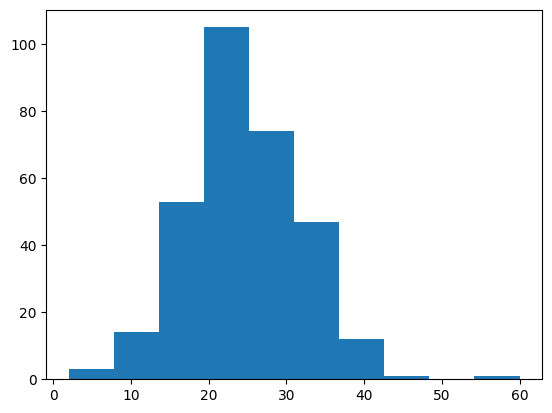

In [5]:
plt.hist(len1)

In [6]:
max(len1)

60

(array([ 21.,  54., 112.,  69.,  36.,  12.,   2.,   1.,   2.,   1.]),
 array([ 4. , 11.1, 18.2, 25.3, 32.4, 39.5, 46.6, 53.7, 60.8, 67.9, 75. ]),
 <BarContainer object of 10 artists>)

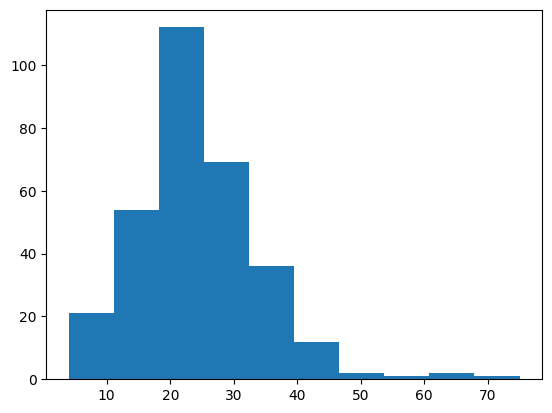

In [7]:
plt.hist(len2)

In [8]:
max(len2)

75

<AxesSubplot:>

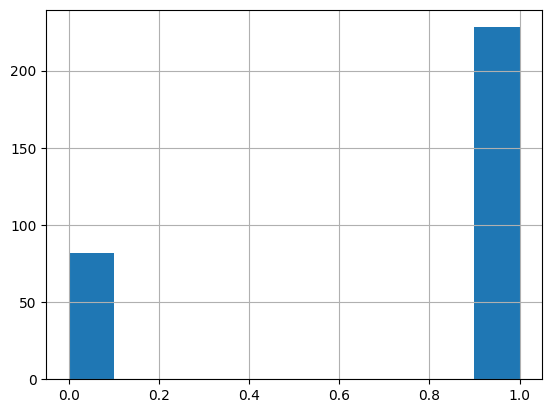

In [9]:
data["Class"].hist()

In [10]:
len(data["Paratope"].unique())

310

In [11]:
len(data["Epitope"].unique())

306

# Fine-tuning

In [26]:
clip_norm = 1

# model name
# model_name = "demo"
model_name = "masonscnn"
# model_name = "lstm"

# model_name = "InteractTransformer"
# model_name = "InteractCoAttnTransformer"

# model_name = "InteractTransformerLSTM"

# model_name = "SetTransformer"
# model_name = "SetCoAttnTransformer"

# model_name = "SetModel"
# model_name = "SetCoAttnModel"
# model_name = "SetModel_ablation"

# model_name = "FTransformer"

# model_name = "EnsembleModel"
# model_name = "PESI"

use_fine_tune = True
# use_fine_tune = False

# fix_FE = True
fix_FE = False

if use_fine_tune==True:
    model_name += "_ft"
    
    # use_pair = True
    use_pair = False

    if use_pair==True:
        model_name += "_pairPreTrain"

os.makedirs("./results/CoV-AbDab/{}/".format(model_name), exist_ok=True)

# model_list = [
#     "InteractCoattnTransformer", 
#     "SetTransformer", 
#     "SetCoAttnTransformer", 
#     "SetModel", 
#     "SetCoAttnModel"
# ]

print("model name: {}".format(model_name))

kfold_labels = []
kfold_preds = []

for k_iter in range(10):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                               kfold=10, holdout_fold=k_iter, is_train_test_full="train", \
                               use_pair=False, balance_samples=False)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, \
                                               collate_fn=my_collate_fn2)

    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                              kfold=10, holdout_fold=k_iter, is_train_test_full="test", \
                              use_pair=False, balance_samples=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, \
                                               collate_fn=my_collate_fn1)

    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        
        epochs = 100
        lr = 6e-5
        
    elif model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 100
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn/model_best.pth")

        if fix_FE==True:
            for name, param in model.cnnmodule.named_parameters():
                param.requires_grad = False
            for name, param in model.cnnmodule2.named_parameters():
                param.requires_grad = False


        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft_pairPreTrain":

        encoder = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn_encoder/model_best.pth")
        model = TowerBaseModel(embed_size=32, encoder=encoder, use_two_towers=False, use_coattn=False, fusion=0).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/lstm/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.LSTM_para.named_parameters():
                param.requires_grad = False
            for name, param in model.LSTM_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="lstm_ft_pairPreTrain":

        encoder = torch.load("./results/SAbDab/full/seq1_neg0/lstm_encoder/model_best.pth")
        model = TowerBaseModel(embed_size=64, encoder=encoder, use_two_towers=False, use_coattn=False, fusion=1).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3, 
                                    use_coattn=False).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False

        epochs = 1000
        lr = 1e-4
        l2_coef = 5e-4
                
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractCoAttnTransformer/model_best.pth")
        model.train()
    
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=True).cuda()
        epochs = 200
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformerLSTM/model_best.pth")
        model.train()
        
        epochs = 200
        lr = 6e-5
                
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True).cuda()
        epochs = 500
        lr = 1e-4
        
    elif model_name=="SetCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer_ft_pairPreTrain":
        
        encoder = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer_encoder/model_best.pth")
        model = TowerBaseModel(embed_size=32, encoder=encoder, use_two_towers=False, use_coattn=True, fusion=1).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
    
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 200
        lr = 3e-5
    
    elif model_name=="SetCoAttnModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="FTransformer":
        model = FTransformer(embed_size=32, 
                             hidden=64, 
                             num_layers=2, 
                             dropout=0.5, 
                             k4kmer=3, 
                             use_pretrain=False, 
                             use_coattn=True, 
                             seq_encoder_type="transformer", 
                             num_heads=2).cuda()
        
        epochs = 100
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=True, 
                      dropout=0.5, 
                      use_coattn=True).cuda()
        
        epochs = 500
        lr = 1e-5
        
    elif model_name=="EnsembleModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/EnsembleModel/model_best.pth")
        model.train()
        
        epochs = 500
        lr = 1e-4
        
    elif model_name=="PESI":
#         model = PESI(embed_size=7, 
#                      hidden=512, 
#                      max_len=100, 
#                      num_heads=2, 
#                      num_inds=6, 
#                      num_outputs=6, 
#                      ln=True, 
#                      dropout=0.5, 
#                      use_coattn=True).cuda()
        model = PESI(embed_size=8, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
#         wd = 3e-4
        l2_coef = 5e-4
        
    elif model_name=="PESI_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/PESI/model_best.pth")
        model.train()
        
        # freeze frame feature extractor
        for name, param in model.Frame_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Frame_epi.named_parameters():
            param.requires_grad = False
            
        # freeze frame feature extractor        
        for name, param in model.Set_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Set_epi.named_parameters():
            param.requires_grad = False
        
        epochs = 500
        lr = 3e-5
        l2_coef = 5e-4

    else:
        print("wrong model name!!!")
        break

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=wd)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    val_gmean_buf = []
    val_mcc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())
            
            param_l2_loss = 0
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    param_l2_loss += torch.norm(param, p=2)
            param_l2_loss = l2_coef * param_l2_loss
            loss += param_l2_loss

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(test_loader):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.stack(preds, axis=1).view(-1)
            labels = torch.stack(labels, axis=1).view(-1)

#             acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
#             f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
#             auc = roc_auc_score(y_true=labels, y_score=preds)

            acc, f1, auc, gmean, mcc = evaluate_metrics(pred_proba=preds, label=labels)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_gmean_buf.append(gmean)
            val_mcc_buf.append(mcc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f} \n Val GMean\t{:.4f} \n Val MCC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc, gmean, mcc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/CoV-AbDab/{}/model_{}_best.pth".format(model_name, k_iter))
                np.save("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, k_iter), acc)
                np.save("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, k_iter), f1)
                np.save("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, k_iter), auc)
                np.save("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, k_iter), gmean)
                np.save("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, k_iter), mcc)

        model.train()
    
    torch.save(model, "./results/CoV-AbDab/{}/model_{}.pth".format(model_name, k_iter))
    np.save("./results/CoV-AbDab/{}/loss_buf_{}.npy".format(model_name, k_iter), np.array(loss_buf))
    np.save("./results/CoV-AbDab/{}/val_loss_buf_{}.npy".format(model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/CoV-AbDab/{}/val_acc_buf_{}.npy".format(model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/CoV-AbDab/{}/val_f1_buf_{}.npy".format(model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/CoV-AbDab/{}/val_auc_buf_{}.npy".format(model_name, k_iter), np.array(val_auc_buf))
    np.save("./results/CoV-AbDab/{}/val_gmean_buf_{}.npy".format(model_name, k_iter), np.array(val_gmean_buf))
    np.save("./results/CoV-AbDab/{}/val_mcc_buf_{}.npy".format(model_name, k_iter), np.array(val_mcc_buf))
    
    
    kfold_labels.append(labels)
    kfold_preds.append(preds)
    
#     break

/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model name: masonscnn_ft
fold 0 as val set
model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7673 
 Val Loss	0.6909 
 Val Acc	0.4634 
 Val F1		0.5000 
 Val AUC	0.5287 
 Val GMean	0.4588 
 Val MCC	-0.0789


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.60it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7647 
 Val Loss	0.6900 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.5311 
 Val GMean	0.5176 
 Val MCC	0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.41it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7498 
 Val Loss	0.6892 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.5335 
 Val GMean	0.5083 
 Val MCC	0.1556


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.90it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7559 
 Val Loss	0.6887 
 Val Acc	0.6098 
 Val F1		0.7037 
 Val AUC	0.5311 
 Val GMean	0.5222 
 Val MCC	0.2162


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.49it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7540 
 Val Loss	0.6883 
 Val Acc	0.6098 
 Val F1		0.7037 
 Val AUC	0.5431 
 Val GMean	0.5222 
 Val MCC	0.2162


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.85it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7556 
 Val Loss	0.6880 
 Val Acc	0.6098 
 Val F1		0.7037 
 Val AUC	0.5407 
 Val GMean	0.5222 
 Val MCC	0.2162


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7540 
 Val Loss	0.6877 
 Val Acc	0.6098 
 Val F1		0.7037 
 Val AUC	0.5407 
 Val GMean	0.5222 
 Val MCC	0.2162


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.04it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7535 
 Val Loss	0.6874 
 Val Acc	0.6098 
 Val F1		0.7037 
 Val AUC	0.5383 
 Val GMean	0.5222 
 Val MCC	0.2162


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.42it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7526 
 Val Loss	0.6871 
 Val Acc	0.6341 
 Val F1		0.7273 
 Val AUC	0.5431 
 Val GMean	0.5358 
 Val MCC	0.2830


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.13it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7506 
 Val Loss	0.6868 
 Val Acc	0.6341 
 Val F1		0.7273 
 Val AUC	0.5478 
 Val GMean	0.5358 
 Val MCC	0.2830


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.03it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7525 
 Val Loss	0.6866 
 Val Acc	0.6341 
 Val F1		0.7273 
 Val AUC	0.5455 
 Val GMean	0.5358 
 Val MCC	0.2830


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.52it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7512 
 Val Loss	0.6864 
 Val Acc	0.6341 
 Val F1		0.7273 
 Val AUC	0.5407 
 Val GMean	0.5358 
 Val MCC	0.2830


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.34it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7500 
 Val Loss	0.6861 
 Val Acc	0.6341 
 Val F1		0.7273 
 Val AUC	0.5431 
 Val GMean	0.5358 
 Val MCC	0.2830


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.44it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7504 
 Val Loss	0.6858 
 Val Acc	0.6341 
 Val F1		0.7273 
 Val AUC	0.5455 
 Val GMean	0.5358 
 Val MCC	0.2830


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.55it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7495 
 Val Loss	0.6855 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5502 
 Val GMean	0.4375 
 Val MCC	0.1688


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.33it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7470 
 Val Loss	0.6852 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5526 
 Val GMean	0.4375 
 Val MCC	0.1688


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.35it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7467 
 Val Loss	0.6849 
 Val Acc	0.6098 
 Val F1		0.7143 
 Val AUC	0.5550 
 Val GMean	0.4891 
 Val MCC	0.2283


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.07it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7462 
 Val Loss	0.6846 
 Val Acc	0.6098 
 Val F1		0.7143 
 Val AUC	0.5670 
 Val GMean	0.4891 
 Val MCC	0.2283


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7462 
 Val Loss	0.6842 
 Val Acc	0.6098 
 Val F1		0.7143 
 Val AUC	0.5646 
 Val GMean	0.4891 
 Val MCC	0.2283


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7452 
 Val Loss	0.6839 
 Val Acc	0.6098 
 Val F1		0.7143 
 Val AUC	0.5646 
 Val GMean	0.4891 
 Val MCC	0.2283


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.05it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7448 
 Val Loss	0.6836 
 Val Acc	0.6098 
 Val F1		0.7143 
 Val AUC	0.5646 
 Val GMean	0.4891 
 Val MCC	0.2283


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.37it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7443 
 Val Loss	0.6833 
 Val Acc	0.6098 
 Val F1		0.7143 
 Val AUC	0.5694 
 Val GMean	0.4891 
 Val MCC	0.2283


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.71it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7428 
 Val Loss	0.6830 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5694 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.39it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7414 
 Val Loss	0.6828 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5622 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.65it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7406 
 Val Loss	0.6826 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5598 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.32it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7396 
 Val Loss	0.6825 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5598 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.59it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7384 
 Val Loss	0.6823 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5670 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.39it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7383 
 Val Loss	0.6821 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5694 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.62it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7366 
 Val Loss	0.6819 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5718 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.94it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7358 
 Val Loss	0.6817 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5742 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.78it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7348 
 Val Loss	0.6815 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5742 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.56it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7341 
 Val Loss	0.6813 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5718 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.31it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7331 
 Val Loss	0.6812 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5694 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.96it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7327 
 Val Loss	0.6810 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5789 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.49it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7321 
 Val Loss	0.6808 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5789 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.32it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7316 
 Val Loss	0.6806 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5885 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7310 
 Val Loss	0.6805 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5789 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.51it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7306 
 Val Loss	0.6803 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5813 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7301 
 Val Loss	0.6802 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5837 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.11it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7301 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5813 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.83it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7296 
 Val Loss	0.6799 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5742 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.45it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7290 
 Val Loss	0.6797 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5742 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.42it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7283 
 Val Loss	0.6796 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5837 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.39it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7278 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5861 
 Val GMean	0.4483 
 Val MCC	0.2516


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.49it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7273 
 Val Loss	0.6793 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5837 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.08it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7268 
 Val Loss	0.6792 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5861 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.14it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7271 
 Val Loss	0.6791 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5909 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7269 
 Val Loss	0.6790 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5861 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.17it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7264 
 Val Loss	0.6789 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5861 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.28it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7262 
 Val Loss	0.6789 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5933 
 Val GMean	0.4588 
 Val MCC	0.3538


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.88it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7261 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5981 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.82it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7254 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6005 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.14it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7249 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6005 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.51it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7244 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6029 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.92it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7242 
 Val Loss	0.6786 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6053 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.03it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7236 
 Val Loss	0.6786 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6029 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.94it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7235 
 Val Loss	0.6785 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6053 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.27it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7231 
 Val Loss	0.6785 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6029 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.12it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7228 
 Val Loss	0.6784 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6029 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.25it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7226 
 Val Loss	0.6784 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6029 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.87it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7222 
 Val Loss	0.6783 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6005 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.21it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7219 
 Val Loss	0.6783 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6005 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.22it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7214 
 Val Loss	0.6783 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5957 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 164.49it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7210 
 Val Loss	0.6782 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.6005 
 Val GMean	0.3974 
 Val MCC	0.3023


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.91it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7207 
 Val Loss	0.6782 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6077 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.04it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7203 
 Val Loss	0.6782 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6053 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.35it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7200 
 Val Loss	0.6781 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6124 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.73it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7198 
 Val Loss	0.6781 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6077 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.43it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7195 
 Val Loss	0.6780 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6029 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.98it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7192 
 Val Loss	0.6780 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6005 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7188 
 Val Loss	0.6780 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6029 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.52it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7184 
 Val Loss	0.6780 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6077 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7183 
 Val Loss	0.6780 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6124 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7180 
 Val Loss	0.6780 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6124 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.81it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7176 
 Val Loss	0.6780 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6053 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.24it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7173 
 Val Loss	0.6780 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6053 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7169 
 Val Loss	0.6780 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6124 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.56it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7166 
 Val Loss	0.6779 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6172 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.66it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7166 
 Val Loss	0.6779 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6124 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.03it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7164 
 Val Loss	0.6779 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6124 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.32it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7162 
 Val Loss	0.6779 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6148 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.08it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7159 
 Val Loss	0.6779 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6172 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.75it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7157 
 Val Loss	0.6779 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6220 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.15it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7155 
 Val Loss	0.6779 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6196 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.67it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7153 
 Val Loss	0.6778 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6244 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.00it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7152 
 Val Loss	0.6778 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6220 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7150 
 Val Loss	0.6778 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6220 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.91it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7148 
 Val Loss	0.6778 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6244 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.15it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7146 
 Val Loss	0.6777 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6268 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.79it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7144 
 Val Loss	0.6777 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.75it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7142 
 Val Loss	0.6777 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7139 
 Val Loss	0.6776 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.75it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7137 
 Val Loss	0.6776 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6268 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.19it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7137 
 Val Loss	0.6776 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6244 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.74it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7134 
 Val Loss	0.6775 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6268 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.32it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7133 
 Val Loss	0.6775 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6292 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.97it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7132 
 Val Loss	0.6775 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6244 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.52it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7131 
 Val Loss	0.6774 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7129 
 Val Loss	0.6774 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6340 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7128 
 Val Loss	0.6774 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6364 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.42it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7127 
 Val Loss	0.6773 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.22it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7125 
 Val Loss	0.6773 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6364 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.87it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7124 
 Val Loss	0.6773 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6388 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.08it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7123 
 Val Loss	0.6772 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.69it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7123 
 Val Loss	0.6772 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6459 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.89it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7122 
 Val Loss	0.6772 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6364 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.25it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7120 
 Val Loss	0.6771 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6388 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.31it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7118 
 Val Loss	0.6771 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6411 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7117 
 Val Loss	0.6771 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6459 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.98it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7117 
 Val Loss	0.6770 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6483 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.23it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7116 
 Val Loss	0.6770 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.12it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7115 
 Val Loss	0.6770 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6411 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.93it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7114 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.04it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7113 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.58it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7112 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.88it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7110 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6411 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.08it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7110 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6555 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.17it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7107 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6627 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.51it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7106 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6579 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7104 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6627 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.55it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7103 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6603 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.14it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7103 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6627 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.99it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7102 
 Val Loss	0.6767 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6579 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.34it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7103 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6531 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.90it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7102 
 Val Loss	0.6766 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6531 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.95it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7102 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6507 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.57it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7099 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6507 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.30it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7098 
 Val Loss	0.6766 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.16it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7097 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6651 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.15it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7097 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.82it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7096 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.00it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7095 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.87it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7093 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6579 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.17it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7092 
 Val Loss	0.6764 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.93it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7091 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6555 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.50it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7090 
 Val Loss	0.6764 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.14it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7090 
 Val Loss	0.6764 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.96it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7089 
 Val Loss	0.6764 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.64it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7089 
 Val Loss	0.6763 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6651 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.51it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7087 
 Val Loss	0.6763 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6699 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.59it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7086 
 Val Loss	0.6763 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6746 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.11it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7085 
 Val Loss	0.6762 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6722 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.22it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7084 
 Val Loss	0.6762 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6675 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 164.28it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7083 
 Val Loss	0.6762 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.63it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7083 
 Val Loss	0.6762 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.57it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7082 
 Val Loss	0.6761 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.42it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7082 
 Val Loss	0.6761 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.18it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7081 
 Val Loss	0.6761 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.09it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7080 
 Val Loss	0.6761 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6603 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.81it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7079 
 Val Loss	0.6761 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.29it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7078 
 Val Loss	0.6760 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.65it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7076 
 Val Loss	0.6760 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7075 
 Val Loss	0.6760 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.98it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7073 
 Val Loss	0.6760 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.25it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7071 
 Val Loss	0.6760 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.21it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7070 
 Val Loss	0.6760 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.31it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7070 
 Val Loss	0.6759 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.66it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7068 
 Val Loss	0.6759 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6675 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.42it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7068 
 Val Loss	0.6759 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6699 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.32it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7067 
 Val Loss	0.6759 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6699 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.47it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7066 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.6746 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.46it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7065 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.6842 
 Val GMean	0.3789 
 Val MCC	0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.55it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7064 
 Val Loss	0.6758 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6842 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.03it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7063 
 Val Loss	0.6758 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6746 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.38it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7062 
 Val Loss	0.6758 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6722 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.15it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7060 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.6770 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7060 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.6722 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.04it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7060 
 Val Loss	0.6757 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6699 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.81it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7059 
 Val Loss	0.6757 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6722 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.06it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7058 
 Val Loss	0.6757 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.03it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7056 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7056 
 Val Loss	0.6756 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.47it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7056 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.48it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7055 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6651 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7054 
 Val Loss	0.6756 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7053 
 Val Loss	0.6756 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.46it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7052 
 Val Loss	0.6756 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6603 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7051 
 Val Loss	0.6755 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6603 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.39it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7050 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.18it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7049 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.67it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7049 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6651 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.15it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7048 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.91it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7049 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.93it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7048 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7047 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.39it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7047 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.40it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7046 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.84it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7045 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7044 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7043 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.45it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7042 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.34it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7042 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.69it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7041 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.95it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7041 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6459 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7040 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.80it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7039 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6411 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.05it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7038 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.61it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7037 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.24it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7037 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.43it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7036 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7035 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.30it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7034 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.91it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7033 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.21it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7033 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.40it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7032 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.94it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7032 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7031 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.74it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7031 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.29it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7030 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.85it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7029 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.72it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7029 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.51it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7028 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.29it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7028 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.06it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7027 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.88it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7027 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.11it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7026 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.57it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7026 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.56it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7025 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.06it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7025 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6651 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.81it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7024 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6651 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.60it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7024 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6675 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.35it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7023 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6675 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.76it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7023 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6746 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.57it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7023 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6746 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.99it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7022 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6651 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.62it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7021 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6699 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.97it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7021 
 Val Loss	0.6755 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6699 
 Val GMean	0.2187 
 Val MCC	-0.0733


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.50it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7021 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6699 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7021 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6699 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.02it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7021 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6675 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.70it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7020 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.25it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7020 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.53it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7019 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.27it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7018 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.32it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7019 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.99it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7018 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6603 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.77it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7017 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.98it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7017 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.50it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7016 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6627 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.49it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7016 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.16it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7016 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.31it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7015 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7014 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.68it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7014 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.99it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7014 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6579 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.22it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7014 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.24it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7013 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.96it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7012 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6459 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.35it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7012 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.33it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7012 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7011 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.34it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7011 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6459 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.49it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7010 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.48it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7010 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7010 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.67it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7009 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6364 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.39it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7009 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6364 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.87it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7008 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.60it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7008 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.55it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7008 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.05it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7008 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6411 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.35it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7007 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.14it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7006 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.20it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7006 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.78it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7006 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7005 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6459 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.75it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7005 
 Val Loss	0.6755 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.95it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7004 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.33it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7004 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.54it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7004 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.19it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7003 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.74it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7003 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.82it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7002 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.88it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7002 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.08it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7002 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6459 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.31it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7001 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.78it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7001 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.41it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7001 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7000 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6364 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.90it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7000 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6411 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7000 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.56it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6999 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6999 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.59it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6998 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.36it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6998 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.99it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6997 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6997 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6997 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6340 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.08it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6996 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.20it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6996 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6459 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.64it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6995 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.66it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6995 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.54it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6994 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.63it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6994 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.28it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6993 
 Val Loss	0.6757 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6268 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.75it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6993 
 Val Loss	0.6757 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.33it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6992 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.60it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6992 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6992 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6316 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.05it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6993 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.26it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6993 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6316 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.17it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6992 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6411 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 164.44it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6992 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.65it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6992 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6991 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6555 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.35it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6991 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6531 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.60it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6990 
 Val Loss	0.6758 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.25it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6990 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6507 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.07it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6990 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.25it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6990 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.42it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6989 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6507 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.38it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6989 
 Val Loss	0.6758 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.43it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6989 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.37it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6989 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.67it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6988 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.16it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6988 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.01it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6988 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.45it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6987 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.64it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6987 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.99it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6987 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.08it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6987 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.95it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6986 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6316 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.35it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6986 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6340 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.70it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6986 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6340 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6985 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6340 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6985 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.67it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6985 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.94it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6984 
 Val Loss	0.6759 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6435 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.88it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6984 
 Val Loss	0.6759 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6411 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6983 
 Val Loss	0.6759 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6388 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.84it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6983 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6507 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.24it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6983 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6507 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.33it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6982 
 Val Loss	0.6759 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6531 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.28it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6982 
 Val Loss	0.6760 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6507 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.61it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6982 
 Val Loss	0.6760 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6507 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.31it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6982 
 Val Loss	0.6760 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.6483 
 Val GMean	0.3244 
 Val MCC	0.2437


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.12it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6981 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.32it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6981 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.33it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6980 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.31it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6980 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6316 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.76it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6980 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.31it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6979 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6316 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.35it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6979 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6316 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.73it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6979 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6979 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6979 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.67it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6979 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6978 
 Val Loss	0.6760 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6978 
 Val Loss	0.6761 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6977 
 Val Loss	0.6761 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.73it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6977 
 Val Loss	0.6761 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.61it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6977 
 Val Loss	0.6761 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6411 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.19it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6976 
 Val Loss	0.6761 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.71it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6976 
 Val Loss	0.6761 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.98it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6975 
 Val Loss	0.6761 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6975 
 Val Loss	0.6761 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.85it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6975 
 Val Loss	0.6761 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 164.51it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6974 
 Val Loss	0.6761 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6411 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6974 
 Val Loss	0.6762 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6340 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.77it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6974 
 Val Loss	0.6762 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.33it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6974 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6340 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6973 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6364 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.74it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6973 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6973 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.97it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6972 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6364 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.86it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6972 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6340 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6972 
 Val Loss	0.6762 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6340 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.38it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6972 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6316 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.11it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6972 
 Val Loss	0.6763 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6244 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.90it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6971 
 Val Loss	0.6763 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6244 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.33it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6971 
 Val Loss	0.6763 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6244 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.68it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6971 
 Val Loss	0.6763 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6292 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.34it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6970 
 Val Loss	0.6763 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6316 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.24it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6970 
 Val Loss	0.6763 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.84it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6970 
 Val Loss	0.6763 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.57it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6970 
 Val Loss	0.6763 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.82it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6970 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.91it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6969 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.20it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6969 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.56it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6969 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.99it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6969 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6969 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.73it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6969 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.66it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6968 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.55it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6968 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.61it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6968 
 Val Loss	0.6764 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.83it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6967 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.49it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6967 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.79it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6967 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6966 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.65it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6967 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.45it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6966 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.84it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6966 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.26it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6966 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6483 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.68it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6965 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.05it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6965 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.97it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6965 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.54it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6964 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.44it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6964 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.77it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6964 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.47it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6964 
 Val Loss	0.6765 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.75it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6964 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6507 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.79it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6963 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.41it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6963 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.48it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6963 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6531 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.43it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6962 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6483 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.44it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6962 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.25it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6961 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6961 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.20it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6961 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6960 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.76it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6960 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.18it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6960 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6959 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.58it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6959 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.32it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6959 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6959 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.50it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6959 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.67it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6958 
 Val Loss	0.6766 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6411 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6958 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.43it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6958 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6459 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.99it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6958 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6435 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.27it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6958 
 Val Loss	0.6767 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6435 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.11it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6958 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6483 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.65it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6958 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6459 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.94it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6957 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6411 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.66it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6957 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6411 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.11it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6957 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.59it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6957 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6459 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.14it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6957 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6459 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.84it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6956 
 Val Loss	0.6767 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.6459 
 Val GMean	0.3882 
 Val MCC	0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.33it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6956 
 Val Loss	0.6767 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.6435 
 Val GMean	0.3882 
 Val MCC	0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.42it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6956 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6388 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.16it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6956 
 Val Loss	0.6767 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.83it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6956 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.62it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6956 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6244 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.91it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6955 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.62it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6955 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.09it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6955 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6220 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.51it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6955 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6196 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.01it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6954 
 Val Loss	0.6767 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.47it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6954 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6340 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.94it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6954 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6364 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.64it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6954 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6364 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.10it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6953 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6364 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.54it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6953 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6388 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.64it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6953 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.95it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6952 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6435 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.32it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6952 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6411 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.82it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6952 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6364 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.04it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6952 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6952 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6340 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.76it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6951 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6340 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.92it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6951 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6316 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6951 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6316 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6951 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6316 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.23it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6950 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6364 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.01it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6950 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6340 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.77it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6950 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6340 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.86it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6950 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6388 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.67it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6950 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6364 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.70it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6950 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6364 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.80it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6950 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6316 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.29it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6949 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6220 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.08it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6949 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6316 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.79it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6949 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6388 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6948 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.30it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6948 
 Val Loss	0.6768 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.07it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6948 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.59it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6948 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6244 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.99it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6947 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.09it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6947 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6268 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6947 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.32it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6947 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.35it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6947 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6316 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.27it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6947 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.48it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6946 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6340 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.70it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6946 
 Val Loss	0.6769 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6292 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6946 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6340 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.55it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6946 
 Val Loss	0.6769 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6292 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6946 
 Val Loss	0.6769 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6244 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.44it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6946 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.6292 
 Val GMean	0.2294 
 Val MCC	0.1701


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.87it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6945 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6268 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.27it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6945 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6196 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.79it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6945 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6244 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.54it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6945 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6244 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6944 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6292 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.59it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6944 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6292 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6944 
 Val Loss	0.6769 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.6268 
 Val GMean	0.3882 
 Val MCC	0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.78it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6944 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6268 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.18it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6944 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.06it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6944 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6292 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6943 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6292 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.92it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6943 
 Val Loss	0.6769 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.06it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6943 
 Val Loss	0.6770 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6316 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6943 
 Val Loss	0.6770 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6292 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.28it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6943 
 Val Loss	0.6770 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6292 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.21it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6943 
 Val Loss	0.6770 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.6244 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.84it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6942 
 Val Loss	0.6770 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.6316 
 Val GMean	0.3882 
 Val MCC	0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6942 
 Val Loss	0.6770 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.6340 
 Val GMean	0.3882 
 Val MCC	0.1890
fold 1 as val set


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.93it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7672 
 Val Loss	0.6421 
 Val Acc	0.5854 
 Val F1		0.6047 
 Val AUC	0.6794 
 Val GMean	0.5849 
 Val MCC	0.1865


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.66it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7720 
 Val Loss	0.6454 
 Val Acc	0.6585 
 Val F1		0.6957 
 Val AUC	0.6770 
 Val GMean	0.6489 
 Val MCC	0.3598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.61it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7617 
 Val Loss	0.6487 
 Val Acc	0.6341 
 Val F1		0.6809 
 Val AUC	0.6770 
 Val GMean	0.6187 
 Val MCC	0.3179


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7559 
 Val Loss	0.6515 
 Val Acc	0.6098 
 Val F1		0.6667 
 Val AUC	0.6770 
 Val GMean	0.5869 
 Val MCC	0.2753


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7619 
 Val Loss	0.6533 
 Val Acc	0.6098 
 Val F1		0.6667 
 Val AUC	0.6770 
 Val GMean	0.5869 
 Val MCC	0.2753


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.90it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7630 
 Val Loss	0.6549 
 Val Acc	0.6341 
 Val F1		0.6939 
 Val AUC	0.6770 
 Val GMean	0.6050 
 Val MCC	0.3419


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.71it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7671 
 Val Loss	0.6564 
 Val Acc	0.6341 
 Val F1		0.6939 
 Val AUC	0.6722 
 Val GMean	0.6050 
 Val MCC	0.3419


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.39it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7653 
 Val Loss	0.6577 
 Val Acc	0.6098 
 Val F1		0.6800 
 Val AUC	0.6651 
 Val GMean	0.5704 
 Val MCC	0.3000


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.98it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7616 
 Val Loss	0.6589 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7603 
 Val Loss	0.6599 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7624 
 Val Loss	0.6608 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7663 
 Val Loss	0.6616 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.16it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7648 
 Val Loss	0.6623 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.95it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7650 
 Val Loss	0.6630 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.79it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7630 
 Val Loss	0.6636 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7631 
 Val Loss	0.6642 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6675 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.29it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7621 
 Val Loss	0.6647 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6651 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.90it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7606 
 Val Loss	0.6652 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6675 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.28it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7599 
 Val Loss	0.6656 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6722 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.55it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7587 
 Val Loss	0.6659 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6699 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.75it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7587 
 Val Loss	0.6663 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6627 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.38it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7580 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6579 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.26it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7593 
 Val Loss	0.6670 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.6507 
 Val GMean	0.5336 
 Val MCC	0.2565


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7586 
 Val Loss	0.6674 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.6531 
 Val GMean	0.5083 
 Val MCC	0.2917


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.75it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7568 
 Val Loss	0.6678 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.6555 
 Val GMean	0.5083 
 Val MCC	0.2917


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.49it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7553 
 Val Loss	0.6682 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.6555 
 Val GMean	0.5083 
 Val MCC	0.2917


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.26it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7547 
 Val Loss	0.6686 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.6555 
 Val GMean	0.5083 
 Val MCC	0.2917


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7536 
 Val Loss	0.6689 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.6555 
 Val GMean	0.5083 
 Val MCC	0.2917


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.30it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7518 
 Val Loss	0.6693 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.6579 
 Val GMean	0.5083 
 Val MCC	0.2917


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.09it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7517 
 Val Loss	0.6696 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.6579 
 Val GMean	0.5083 
 Val MCC	0.2917


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.18it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7507 
 Val Loss	0.6700 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.6555 
 Val GMean	0.4640 
 Val MCC	0.2464


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.28it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7496 
 Val Loss	0.6703 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6555 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.77it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7492 
 Val Loss	0.6706 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6555 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.07it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7483 
 Val Loss	0.6710 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6555 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.81it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7472 
 Val Loss	0.6713 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6531 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.35it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7467 
 Val Loss	0.6717 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6579 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.30it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7465 
 Val Loss	0.6720 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6603 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7462 
 Val Loss	0.6724 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6627 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.47it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7454 
 Val Loss	0.6728 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6651 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.57it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7448 
 Val Loss	0.6731 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6603 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.24it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7442 
 Val Loss	0.6735 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6555 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.85it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7436 
 Val Loss	0.6738 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6555 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.37it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7427 
 Val Loss	0.6741 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6579 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.47it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7422 
 Val Loss	0.6744 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6579 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.81it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7416 
 Val Loss	0.6748 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6579 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7409 
 Val Loss	0.6750 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6579 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.34it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7407 
 Val Loss	0.6753 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6507 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.56it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7403 
 Val Loss	0.6756 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6459 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.94it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7399 
 Val Loss	0.6759 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6507 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.02it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7393 
 Val Loss	0.6762 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6459 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.91it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7387 
 Val Loss	0.6765 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6459 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7381 
 Val Loss	0.6768 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6483 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.24it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7379 
 Val Loss	0.6770 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6435 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7374 
 Val Loss	0.6773 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6483 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.98it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7368 
 Val Loss	0.6776 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6435 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.54it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7365 
 Val Loss	0.6778 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6435 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.95it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7359 
 Val Loss	0.6781 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6411 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.41it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7354 
 Val Loss	0.6783 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6411 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.74it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7351 
 Val Loss	0.6785 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6388 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.29it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7346 
 Val Loss	0.6788 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.6340 
 Val GMean	0.4150 
 Val MCC	0.1969


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.45it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7342 
 Val Loss	0.6790 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6292 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.88it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7339 
 Val Loss	0.6792 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6244 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.73it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7335 
 Val Loss	0.6795 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6172 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.27it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7334 
 Val Loss	0.6797 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6196 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.17it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7331 
 Val Loss	0.6799 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6196 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.46it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7329 
 Val Loss	0.6800 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6172 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.75it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7327 
 Val Loss	0.6802 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6244 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.16it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7321 
 Val Loss	0.6804 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6196 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7316 
 Val Loss	0.6806 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6124 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.32it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7314 
 Val Loss	0.6808 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6124 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.43it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7313 
 Val Loss	0.6810 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6100 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.99it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7308 
 Val Loss	0.6812 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6100 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7306 
 Val Loss	0.6814 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.59it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7300 
 Val Loss	0.6816 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7298 
 Val Loss	0.6819 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6172 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.04it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7296 
 Val Loss	0.6821 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.09it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7294 
 Val Loss	0.6823 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.14it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7292 
 Val Loss	0.6825 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.18it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7289 
 Val Loss	0.6827 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.99it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7286 
 Val Loss	0.6828 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6124 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.10it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7283 
 Val Loss	0.6830 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6124 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7282 
 Val Loss	0.6832 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6172 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7283 
 Val Loss	0.6834 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.35it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7281 
 Val Loss	0.6835 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6148 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.02it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7277 
 Val Loss	0.6837 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6124 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.56it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7275 
 Val Loss	0.6839 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6100 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7272 
 Val Loss	0.6840 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6077 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.33it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7270 
 Val Loss	0.6842 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6029 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.15it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7268 
 Val Loss	0.6843 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5957 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.90it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7267 
 Val Loss	0.6845 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5909 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.34it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7265 
 Val Loss	0.6847 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5885 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.34it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7264 
 Val Loss	0.6849 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5933 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.01it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7261 
 Val Loss	0.6850 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6029 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.86it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7259 
 Val Loss	0.6852 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.6077 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.20it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7257 
 Val Loss	0.6853 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5909 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.38it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7257 
 Val Loss	0.6855 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5933 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.72it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7255 
 Val Loss	0.6856 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5933 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.50it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7253 
 Val Loss	0.6858 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5885 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7249 
 Val Loss	0.6859 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5885 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.56it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7247 
 Val Loss	0.6861 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5766 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.65it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7246 
 Val Loss	0.6862 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5766 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.25it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7245 
 Val Loss	0.6864 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5766 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.80it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7242 
 Val Loss	0.6865 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5766 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.95it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7240 
 Val Loss	0.6867 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5766 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7237 
 Val Loss	0.6868 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5813 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.97it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7236 
 Val Loss	0.6870 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5837 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.01it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7235 
 Val Loss	0.6871 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5789 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.77it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7232 
 Val Loss	0.6873 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5813 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.14it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7231 
 Val Loss	0.6874 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5813 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.76it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7231 
 Val Loss	0.6875 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5885 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.80it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7230 
 Val Loss	0.6877 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5885 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.57it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7229 
 Val Loss	0.6878 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5861 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.07it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7227 
 Val Loss	0.6879 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5861 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.68it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7226 
 Val Loss	0.6881 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5885 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.97it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7226 
 Val Loss	0.6882 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5909 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.87it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7224 
 Val Loss	0.6883 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5909 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7224 
 Val Loss	0.6885 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5933 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.68it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7223 
 Val Loss	0.6886 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5933 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.05it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7222 
 Val Loss	0.6887 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5909 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.61it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7221 
 Val Loss	0.6888 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5933 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.25it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7220 
 Val Loss	0.6890 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5861 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.87it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7219 
 Val Loss	0.6891 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5837 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7219 
 Val Loss	0.6893 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5813 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.74it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7217 
 Val Loss	0.6894 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5837 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.28it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7216 
 Val Loss	0.6895 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5837 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.19it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7215 
 Val Loss	0.6896 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5837 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.83it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7214 
 Val Loss	0.6898 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5789 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.20it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7213 
 Val Loss	0.6899 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5789 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.44it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7213 
 Val Loss	0.6900 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5766 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.16it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7212 
 Val Loss	0.6901 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5742 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7210 
 Val Loss	0.6902 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5742 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7208 
 Val Loss	0.6903 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5670 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.41it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7206 
 Val Loss	0.6904 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5646 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.09it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7206 
 Val Loss	0.6905 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5598 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.38it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7204 
 Val Loss	0.6906 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5670 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.27it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7203 
 Val Loss	0.6908 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5694 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.01it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7202 
 Val Loss	0.6909 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5646 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.20it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7201 
 Val Loss	0.6910 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5598 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.49it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7199 
 Val Loss	0.6911 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.93it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7198 
 Val Loss	0.6912 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.79it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7196 
 Val Loss	0.6913 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.44it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7195 
 Val Loss	0.6914 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.86it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7194 
 Val Loss	0.6915 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5622 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.04it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7192 
 Val Loss	0.6916 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5598 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.26it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7191 
 Val Loss	0.6917 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5622 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.80it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7191 
 Val Loss	0.6918 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.69it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7190 
 Val Loss	0.6919 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.22it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7189 
 Val Loss	0.6920 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.12it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7188 
 Val Loss	0.6921 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7188 
 Val Loss	0.6922 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.76it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7187 
 Val Loss	0.6923 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.13it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7185 
 Val Loss	0.6923 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.11it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7184 
 Val Loss	0.6924 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.53it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7183 
 Val Loss	0.6925 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.73it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7182 
 Val Loss	0.6926 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5455 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.93it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7182 
 Val Loss	0.6927 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.28it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7180 
 Val Loss	0.6928 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5502 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.40it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7179 
 Val Loss	0.6929 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.23it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7178 
 Val Loss	0.6930 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.26it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7177 
 Val Loss	0.6931 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7175 
 Val Loss	0.6932 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5598 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.31it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7175 
 Val Loss	0.6932 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.60it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7173 
 Val Loss	0.6933 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.45it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7173 
 Val Loss	0.6934 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.97it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7172 
 Val Loss	0.6935 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.71it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7171 
 Val Loss	0.6936 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.84it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7170 
 Val Loss	0.6937 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5502 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.48it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7169 
 Val Loss	0.6937 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.84it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7168 
 Val Loss	0.6938 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5455 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.30it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7167 
 Val Loss	0.6939 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7167 
 Val Loss	0.6940 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5455 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.06it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7165 
 Val Loss	0.6940 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.03it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7164 
 Val Loss	0.6941 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.63it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7164 
 Val Loss	0.6942 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5502 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.47it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7163 
 Val Loss	0.6943 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5598 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.41it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7163 
 Val Loss	0.6943 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.46it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7161 
 Val Loss	0.6944 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.57it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7161 
 Val Loss	0.6945 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.37it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7161 
 Val Loss	0.6945 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.39it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7159 
 Val Loss	0.6946 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.04it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7158 
 Val Loss	0.6947 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.64it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7157 
 Val Loss	0.6948 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5526 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.41it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7157 
 Val Loss	0.6948 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5335 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7156 
 Val Loss	0.6949 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5383 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.73it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7155 
 Val Loss	0.6950 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5431 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.03it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7154 
 Val Loss	0.6950 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5478 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.51it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7153 
 Val Loss	0.6951 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5431 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.54it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7152 
 Val Loss	0.6952 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5407 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7151 
 Val Loss	0.6952 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5311 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.74it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7150 
 Val Loss	0.6953 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5311 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.64it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7150 
 Val Loss	0.6953 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5311 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.39it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7150 
 Val Loss	0.6954 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5359 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.67it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7149 
 Val Loss	0.6954 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5455 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.82it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7148 
 Val Loss	0.6955 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5550 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7148 
 Val Loss	0.6955 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5574 
 Val GMean	0.3594 
 Val MCC	0.1407


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.51it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7148 
 Val Loss	0.6956 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.69it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7147 
 Val Loss	0.6956 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.49it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7146 
 Val Loss	0.6957 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.07it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7145 
 Val Loss	0.6957 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.07it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7144 
 Val Loss	0.6958 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.59it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7144 
 Val Loss	0.6958 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.42it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7144 
 Val Loss	0.6959 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5574 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.51it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7144 
 Val Loss	0.6959 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.40it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7143 
 Val Loss	0.6959 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7142 
 Val Loss	0.6960 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.83it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7141 
 Val Loss	0.6960 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.92it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7141 
 Val Loss	0.6961 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.82it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7140 
 Val Loss	0.6961 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.40it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7139 
 Val Loss	0.6962 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.79it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7139 
 Val Loss	0.6962 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.66it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7138 
 Val Loss	0.6963 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.27it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7137 
 Val Loss	0.6963 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5478 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.26it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7137 
 Val Loss	0.6963 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7137 
 Val Loss	0.6964 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.57it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7136 
 Val Loss	0.6964 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.54it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7136 
 Val Loss	0.6965 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.00it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7135 
 Val Loss	0.6965 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7134 
 Val Loss	0.6966 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.41it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7134 
 Val Loss	0.6966 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.06it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7134 
 Val Loss	0.6966 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.25it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7133 
 Val Loss	0.6967 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.93it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7132 
 Val Loss	0.6967 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.04it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7132 
 Val Loss	0.6968 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.86it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7131 
 Val Loss	0.6968 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.38it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7130 
 Val Loss	0.6968 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.59it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7128 
 Val Loss	0.6969 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.24it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7127 
 Val Loss	0.6969 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7126 
 Val Loss	0.6969 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.33it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7126 
 Val Loss	0.6970 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.41it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7125 
 Val Loss	0.6970 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.48it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7124 
 Val Loss	0.6970 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.34it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7124 
 Val Loss	0.6971 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7124 
 Val Loss	0.6971 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.49it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7123 
 Val Loss	0.6971 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.80it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7122 
 Val Loss	0.6972 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.93it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7122 
 Val Loss	0.6972 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7121 
 Val Loss	0.6972 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.29it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7121 
 Val Loss	0.6973 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.61it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7121 
 Val Loss	0.6973 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.05it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7120 
 Val Loss	0.6973 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7119 
 Val Loss	0.6974 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.40it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7119 
 Val Loss	0.6974 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.50it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7118 
 Val Loss	0.6975 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.48it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7119 
 Val Loss	0.6975 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.56it/s]

lr:  0.0001


Epoch 244: 
 Train Loss	0.7118 
 Val Loss	0.6975 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.84it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7118 
 Val Loss	0.6976 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.93it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7117 
 Val Loss	0.6976 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.04it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7116 
 Val Loss	0.6976 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.60it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7116 
 Val Loss	0.6976 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.52it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7115 
 Val Loss	0.6977 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.41it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7115 
 Val Loss	0.6977 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7115 
 Val Loss	0.6977 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7114 
 Val Loss	0.6977 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.34it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7113 
 Val Loss	0.6977 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7113 
 Val Loss	0.6978 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.75it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7112 
 Val Loss	0.6978 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.45it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7111 
 Val Loss	0.6978 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.27it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7111 
 Val Loss	0.6978 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.89it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7110 
 Val Loss	0.6979 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.43it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7110 
 Val Loss	0.6979 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.96it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7110 
 Val Loss	0.6979 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.26it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7109 
 Val Loss	0.6979 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.09it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7108 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.60it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7107 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.01it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7107 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7106 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.05it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7106 
 Val Loss	0.6981 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7105 
 Val Loss	0.6981 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.70it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7104 
 Val Loss	0.6981 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.73it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7103 
 Val Loss	0.6981 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.64it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7103 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.86it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7102 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.07it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7102 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.32it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7102 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.94it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7101 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.24it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7101 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.05it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7100 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.89it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7100 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.44it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7100 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.48it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7099 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.49it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7099 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.90it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7099 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.39it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7098 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7098 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7097 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.02it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.7097 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.68it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.7097 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.42it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.7096 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.90it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.7096 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.95it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.7095 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.59it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.7095 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5574 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.69it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.7094 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5574 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.05it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.7093 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.7093 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.7092 
 Val Loss	0.6988 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5478 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.7092 
 Val Loss	0.6988 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.94it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.7091 
 Val Loss	0.6988 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5574 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.93it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.7091 
 Val Loss	0.6988 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5574 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.94it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.7091 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.7090 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5502 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.45it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.7089 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5502 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.7089 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5502 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.57it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.7088 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.89it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.7088 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5502 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.24it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.7088 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5526 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.7087 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5502 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.02it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.7087 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.92it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.7087 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.78it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.7086 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.33it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.7086 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.59it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.7085 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.7085 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5526 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.30it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.7085 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5526 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.18it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.7084 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.89it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.7084 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.90it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.7083 
 Val Loss	0.6993 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5526 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.70it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.7083 
 Val Loss	0.6993 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5550 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.48it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.7083 
 Val Loss	0.6993 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.94it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.7083 
 Val Loss	0.6993 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.42it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.7082 
 Val Loss	0.6993 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.28it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.7082 
 Val Loss	0.6994 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.7081 
 Val Loss	0.6994 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.01it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.7081 
 Val Loss	0.6994 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.73it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.7080 
 Val Loss	0.6994 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.34it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.7080 
 Val Loss	0.6994 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.44it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.7079 
 Val Loss	0.6995 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.39it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.7079 
 Val Loss	0.6995 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.93it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.7079 
 Val Loss	0.6995 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.80it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.7078 
 Val Loss	0.6995 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.23it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.7078 
 Val Loss	0.6996 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.36it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.7077 
 Val Loss	0.6996 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.01it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.7077 
 Val Loss	0.6996 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.55it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.7076 
 Val Loss	0.6996 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.76it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.7076 
 Val Loss	0.6996 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.37it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.7076 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.99it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.7075 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.7075 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.83it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.7075 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.06it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.7075 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.7074 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.22it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.7074 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.03it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.7073 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.7073 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.7073 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.22it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.7072 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.09it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.7072 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.45it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.7071 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.66it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.7071 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.59it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.7070 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.80it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.7069 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.7069 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.23it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.7069 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.84it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.7068 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.19it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.7068 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.7068 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.19it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.7067 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.36it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.7067 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.62it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.7066 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.07it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.7066 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.62it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.7066 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.47it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.7066 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.68it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.7065 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.7065 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.59it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.7065 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.7064 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.07it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.7064 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.32it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.7064 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.05it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.7064 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.66it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.7064 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.79it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.7063 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.51it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.7063 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.79it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.7063 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.61it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.7063 
 Val Loss	0.7003 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.40it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.7062 
 Val Loss	0.7003 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.16it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.7062 
 Val Loss	0.7003 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.7062 
 Val Loss	0.7003 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.06it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.7061 
 Val Loss	0.7003 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.7061 
 Val Loss	0.7003 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.30it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.7060 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.30it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.7060 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.51it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.7060 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.34it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.7060 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.7060 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5885 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.75it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.7059 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.45it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.7059 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.46it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.7059 
 Val Loss	0.7005 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.49it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.7058 
 Val Loss	0.7005 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.13it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.7058 
 Val Loss	0.7005 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.34it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.7058 
 Val Loss	0.7005 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.63it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.7058 
 Val Loss	0.7005 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.45it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.7057 
 Val Loss	0.7005 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.26it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.7057 
 Val Loss	0.7005 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.58it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.7057 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.31it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.7057 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.50it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.7056 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.76it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.7056 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.08it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.7056 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.55it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.7055 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.65it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.7055 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.96it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.7055 
 Val Loss	0.7006 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.08it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.7054 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.62it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.7054 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.79it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.7054 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.87it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.7053 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.7053 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.7053 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.7052 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5574 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.92it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.7052 
 Val Loss	0.7008 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.71it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.7052 
 Val Loss	0.7008 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5526 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.53it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.7051 
 Val Loss	0.7008 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5574 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.7051 
 Val Loss	0.7008 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5598 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.41it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.7051 
 Val Loss	0.7008 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.84it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.7050 
 Val Loss	0.7008 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.46it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.7050 
 Val Loss	0.7008 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.96it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.7050 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.54it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.7049 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.7049 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.7049 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.64it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.7049 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.99it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.7049 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.74it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.7049 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.43it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.7048 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.26it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.7048 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.21it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.7048 
 Val Loss	0.7009 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.88it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.7047 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.72it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.7047 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.11it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.7047 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.20it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.7047 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.68it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.7046 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.94it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.7046 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.97it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.7046 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.87it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.7046 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.31it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.7045 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.11it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.7045 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.92it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.7045 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.81it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.7044 
 Val Loss	0.7010 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.25it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.7044 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.45it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.7044 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5622 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.82it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.7043 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.72it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.7043 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.81it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.7043 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.15it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.7043 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.7042 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.98it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.7042 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.46it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.7041 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5837 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.17it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.7041 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.00it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.7041 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.98it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.7041 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.55it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.7040 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.42it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.7040 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.7040 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.60it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.7040 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.94it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.7039 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.19it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.7039 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.15it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.7038 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.37it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.7038 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.82it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.7038 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.60it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.7038 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.7038 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.68it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.7037 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5789 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.19it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.7037 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.63it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.7037 
 Val Loss	0.7012 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.69it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.7037 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.75it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.7037 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.70it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.7036 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.30it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.7036 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.15it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.7036 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.12it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.7036 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5813 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.23it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.7035 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.82it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.7035 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.7034 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.37it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.7034 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.7034 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.18it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.7033 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.46it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.7033 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5670 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.37it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.7033 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.7033 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.56it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.7032 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.70it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.7032 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.71it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.7032 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.09it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.7032 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5646 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.38it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.7031 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.7031 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5766 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.79it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.7031 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.77it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.7030 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.85it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.7030 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5694 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.04it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.7030 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5718 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.64it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.7030 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.7029 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5742 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.88it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.7029 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5861 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.64it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.7029 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5885 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.44it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.7029 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5909 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.45it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.7029 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5909 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.43it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.7028 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5957 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.64it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.7028 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5957 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.02it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.7028 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5933 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.74it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.7028 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.6077 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.7028 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.6077 
 Val GMean	0.3693 
 Val MCC	0.2611


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.63it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.7027 
 Val Loss	0.7014 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.6100 
 Val GMean	0.4264 
 Val MCC	0.3056


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.7027 
 Val Loss	0.7014 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.6053 
 Val GMean	0.3693 
 Val MCC	0.2611
fold 2 as val set


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.92it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7408 
 Val Loss	0.7156 
 Val Acc	0.4878 
 Val F1		0.5333 
 Val AUC	0.5383 
 Val GMean	0.4792 
 Val MCC	-0.0337


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.44it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7441 
 Val Loss	0.7161 
 Val Acc	0.4634 
 Val F1		0.5417 
 Val AUC	0.5407 
 Val GMean	0.4320 
 Val MCC	-0.0966


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.89it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7515 
 Val Loss	0.7166 
 Val Acc	0.4634 
 Val F1		0.5417 
 Val AUC	0.5383 
 Val GMean	0.4320 
 Val MCC	-0.0966


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7455 
 Val Loss	0.7172 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.5383 
 Val GMean	0.4483 
 Val MCC	-0.0503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.12it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7588 
 Val Loss	0.7173 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.5407 
 Val GMean	0.4483 
 Val MCC	-0.0503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.11it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7562 
 Val Loss	0.7173 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.5359 
 Val GMean	0.4092 
 Val MCC	-0.1077


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7559 
 Val Loss	0.7174 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.5335 
 Val GMean	0.4092 
 Val MCC	-0.1077


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.89it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7569 
 Val Loss	0.7176 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.5287 
 Val GMean	0.4092 
 Val MCC	-0.1077


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.65it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7547 
 Val Loss	0.7178 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.5239 
 Val GMean	0.4092 
 Val MCC	-0.1077


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7578 
 Val Loss	0.7180 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.5287 
 Val GMean	0.4092 
 Val MCC	-0.1077


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.20it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7570 
 Val Loss	0.7183 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5239 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.55it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7561 
 Val Loss	0.7187 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5167 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.23it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7558 
 Val Loss	0.7191 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5120 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.53it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7552 
 Val Loss	0.7196 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5072 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7534 
 Val Loss	0.7201 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5048 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.69it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7507 
 Val Loss	0.7206 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5000 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7491 
 Val Loss	0.7211 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4952 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.68it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7471 
 Val Loss	0.7217 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4928 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.82it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7454 
 Val Loss	0.7222 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5000 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.38it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7443 
 Val Loss	0.7226 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4952 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.00it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7427 
 Val Loss	0.7230 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4904 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7425 
 Val Loss	0.7233 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4976 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.17it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7420 
 Val Loss	0.7237 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4904 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.86it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7409 
 Val Loss	0.7240 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.54it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7409 
 Val Loss	0.7243 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.32it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7408 
 Val Loss	0.7246 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4904 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.94it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7402 
 Val Loss	0.7248 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.43it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7397 
 Val Loss	0.7250 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.98it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7389 
 Val Loss	0.7252 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.91it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7388 
 Val Loss	0.7253 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.78it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7382 
 Val Loss	0.7255 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7375 
 Val Loss	0.7256 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4880 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.42it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7367 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4904 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.00it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7364 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4856 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.88it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7358 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4856 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.40it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7354 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4833 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7357 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4809 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7351 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4809 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7350 
 Val Loss	0.7265 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4809 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.81it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7349 
 Val Loss	0.7266 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4761 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.62it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7344 
 Val Loss	0.7267 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4737 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.78it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7338 
 Val Loss	0.7267 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4737 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7333 
 Val Loss	0.7269 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4713 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.52it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7333 
 Val Loss	0.7270 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4689 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.36it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7327 
 Val Loss	0.7272 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4689 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.55it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7323 
 Val Loss	0.7274 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4641 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.28it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7320 
 Val Loss	0.7275 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4617 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.84it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7318 
 Val Loss	0.7276 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4665 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7312 
 Val Loss	0.7277 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.4689 
 Val GMean	0.4236 
 Val MCC	-0.0603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.90it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7310 
 Val Loss	0.7278 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4665 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7306 
 Val Loss	0.7279 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4617 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.35it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7301 
 Val Loss	0.7281 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4617 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.37it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7296 
 Val Loss	0.7282 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4617 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7291 
 Val Loss	0.7283 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4617 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.62it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7288 
 Val Loss	0.7284 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4641 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7280 
 Val Loss	0.7285 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4641 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.31it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7277 
 Val Loss	0.7286 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4617 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7274 
 Val Loss	0.7287 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4569 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.95it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7272 
 Val Loss	0.7288 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4545 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.88it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7270 
 Val Loss	0.7289 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4450 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.19it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7267 
 Val Loss	0.7290 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4474 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.18it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7265 
 Val Loss	0.7292 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4474 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.49it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7263 
 Val Loss	0.7293 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4474 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.62it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7261 
 Val Loss	0.7294 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4354 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.26it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7258 
 Val Loss	0.7296 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4402 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.95it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7255 
 Val Loss	0.7298 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4354 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.32it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7251 
 Val Loss	0.7300 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4354 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.30it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7250 
 Val Loss	0.7301 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4378 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.41it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7247 
 Val Loss	0.7303 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4402 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7244 
 Val Loss	0.7304 
 Val Acc	0.4390 
 Val F1		0.5490 
 Val AUC	0.4402 
 Val GMean	0.3660 
 Val MCC	-0.1678


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.20it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7242 
 Val Loss	0.7306 
 Val Acc	0.4390 
 Val F1		0.5490 
 Val AUC	0.4378 
 Val GMean	0.3660 
 Val MCC	-0.1678


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.68it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7237 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4378 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.96it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7235 
 Val Loss	0.7308 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4402 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.51it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7231 
 Val Loss	0.7310 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4402 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.34it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7229 
 Val Loss	0.7311 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4426 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7228 
 Val Loss	0.7311 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4498 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7225 
 Val Loss	0.7312 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4498 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.03it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7222 
 Val Loss	0.7312 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4498 
 Val GMean	0.3789 
 Val MCC	-0.1212


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7220 
 Val Loss	0.7313 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4498 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.12it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7218 
 Val Loss	0.7314 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4474 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.64it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7215 
 Val Loss	0.7314 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4450 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.15it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7213 
 Val Loss	0.7315 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4450 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.17it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7208 
 Val Loss	0.7316 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4474 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.00it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7206 
 Val Loss	0.7317 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.55it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7204 
 Val Loss	0.7317 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7201 
 Val Loss	0.7318 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.32it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7200 
 Val Loss	0.7318 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.03it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7197 
 Val Loss	0.7319 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.81it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7195 
 Val Loss	0.7320 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4533 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7192 
 Val Loss	0.7321 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4617 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7189 
 Val Loss	0.7321 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.95it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7188 
 Val Loss	0.7321 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.36it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7186 
 Val Loss	0.7321 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4617 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.92it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7185 
 Val Loss	0.7321 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4641 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.69it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7183 
 Val Loss	0.7321 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4689 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7181 
 Val Loss	0.7320 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4809 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.72it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7179 
 Val Loss	0.7320 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4809 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.30it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7179 
 Val Loss	0.7319 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4809 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.05it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7179 
 Val Loss	0.7318 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4809 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7176 
 Val Loss	0.7318 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.39it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7174 
 Val Loss	0.7318 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.39it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7173 
 Val Loss	0.7317 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4809 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.42it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7170 
 Val Loss	0.7317 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4809 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.02it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7167 
 Val Loss	0.7316 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.47it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7165 
 Val Loss	0.7316 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.86it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7164 
 Val Loss	0.7315 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4689 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.11it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7163 
 Val Loss	0.7315 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4689 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.15it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7161 
 Val Loss	0.7315 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4665 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.10it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7160 
 Val Loss	0.7315 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.52it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7158 
 Val Loss	0.7314 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.93it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7157 
 Val Loss	0.7314 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.11it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7157 
 Val Loss	0.7313 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.22it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7157 
 Val Loss	0.7313 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.73it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7156 
 Val Loss	0.7312 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4785 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.08it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7155 
 Val Loss	0.7312 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.84it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7155 
 Val Loss	0.7311 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.82it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7153 
 Val Loss	0.7311 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4761 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.43it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7151 
 Val Loss	0.7310 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.21it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7150 
 Val Loss	0.7310 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.93it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7149 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.72it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7148 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4713 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.77it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7147 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.41it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7146 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.00it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7145 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.93it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7144 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4737 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.81it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7142 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4617 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.69it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7140 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4617 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.62it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7139 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.70it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7138 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7136 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.36it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7135 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.44it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7135 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.84it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7134 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.58it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7132 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7131 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4641 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.63it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7130 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4617 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.18it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7129 
 Val Loss	0.7306 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4593 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.26it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7127 
 Val Loss	0.7307 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4593 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.64it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7125 
 Val Loss	0.7307 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4617 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7123 
 Val Loss	0.7307 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4593 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7122 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.84it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7121 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.65it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7119 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.29it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7118 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.41it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7118 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.52it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7116 
 Val Loss	0.7308 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4569 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 163.63it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7115 
 Val Loss	0.7309 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4593 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.07it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7114 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.49it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7114 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.02it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7114 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7113 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4593 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.75it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7112 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7110 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.23it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7110 
 Val Loss	0.7309 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4545 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7110 
 Val Loss	0.7309 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4545 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.08it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7109 
 Val Loss	0.7309 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4545 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7109 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.65it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7108 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4498 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.49it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7107 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.72it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7106 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7105 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.62it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7104 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.02it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7104 
 Val Loss	0.7309 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4545 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.45it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7103 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.80it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7102 
 Val Loss	0.7309 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.79it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7102 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.44it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7101 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4569 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7100 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.01it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7099 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7098 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7097 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.72it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7097 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.56it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7095 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.53it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7095 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.22it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7094 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4545 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7093 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7093 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.02it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7092 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4498 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.34it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7090 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4522 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.46it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7090 
 Val Loss	0.7308 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4522 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.20it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7089 
 Val Loss	0.7308 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4498 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.02it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7088 
 Val Loss	0.7308 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4474 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.80it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7087 
 Val Loss	0.7308 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4474 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.39it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7087 
 Val Loss	0.7308 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4498 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.05it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7086 
 Val Loss	0.7307 
 Val Acc	0.4146 
 Val F1		0.5385 
 Val AUC	0.4474 
 Val GMean	0.3170 
 Val MCC	-0.2316


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.35it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7086 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4474 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.51it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7084 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4450 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.82it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7084 
 Val Loss	0.7307 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4450 
 Val GMean	0.3281 
 Val MCC	-0.1861


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.27it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7083 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7082 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.23it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7081 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.39it/s]

lr:  0.0001


Epoch 191: 
 Train Loss	0.7081 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.97it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7080 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.03it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7079 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4498 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.83it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7078 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4498 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.81it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7077 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.21it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7076 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4522 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.90it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7075 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.73it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7074 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.95it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7073 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4498 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.74it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7072 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4498 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.88it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7072 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.36it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7071 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.45it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7070 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.93it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7070 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.29it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7069 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7069 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.53it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7068 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4426 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.00it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7068 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4426 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.22it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7067 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7067 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4426 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.46it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7066 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.08it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7065 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.82it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7065 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.30it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7065 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4426 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.81it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7063 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.64it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7062 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4426 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.98it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7061 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7060 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.65it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7059 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4426 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.81it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7059 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.98it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7058 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.17it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7057 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4378 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.53it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7057 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4426 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.73it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7056 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.97it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7056 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4498 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.09it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7056 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4450 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.62it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7055 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.78it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7055 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.87it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7055 
 Val Loss	0.7305 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4474 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7054 
 Val Loss	0.7305 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4498 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.45it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7054 
 Val Loss	0.7304 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4522 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.94it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7053 
 Val Loss	0.7304 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4569 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.22it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7053 
 Val Loss	0.7304 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4593 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7052 
 Val Loss	0.7303 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4545 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.20it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7051 
 Val Loss	0.7303 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.15it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7051 
 Val Loss	0.7303 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.18it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7051 
 Val Loss	0.7303 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7051 
 Val Loss	0.7303 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.10it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7050 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4474 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7050 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.51it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7050 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7049 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.18it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7048 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4378 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.57it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7048 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7048 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.84it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7047 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.90it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7047 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7047 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.04it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7046 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.40it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7045 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4354 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.68it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7045 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4330 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.20it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7044 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4330 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.67it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7044 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4354 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7043 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4330 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.68it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7043 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4330 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.16it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7042 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4378 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.57it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7042 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4378 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.79it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7042 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4306 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.43it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7041 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4378 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.71it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7040 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4330 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.70it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7040 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4354 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.24it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7040 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4354 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.41it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7039 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4330 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7039 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4330 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.15it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7038 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4330 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.99it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7037 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4306 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.85it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7037 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4258 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.31it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7037 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4330 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7036 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4354 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.95it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7036 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4378 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.73it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7036 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7035 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.37it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7035 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4498 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.49it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7034 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4498 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.25it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7033 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.09it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7033 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.88it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7032 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.37it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7032 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4378 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.70it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7032 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4354 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.69it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7031 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7031 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4378 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7031 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.51it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7031 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.42it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7030 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4474 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.45it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.7030 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.49it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.7029 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.55it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.7029 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.96it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.7028 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.98it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.7027 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.7027 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4426 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.12it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.7026 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.00it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.7026 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.22it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.7026 
 Val Loss	0.7297 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4498 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.83it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.7026 
 Val Loss	0.7297 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.34it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.7025 
 Val Loss	0.7297 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.7025 
 Val Loss	0.7297 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4474 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.31it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.7024 
 Val Loss	0.7296 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.01it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.7024 
 Val Loss	0.7296 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4498 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.58it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.7023 
 Val Loss	0.7296 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4522 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.7023 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.93it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.7023 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.13it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.7022 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.39it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.7022 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.7022 
 Val Loss	0.7294 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4498 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.01it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.7022 
 Val Loss	0.7294 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.7021 
 Val Loss	0.7294 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4522 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.26it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.7020 
 Val Loss	0.7294 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4522 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.96it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.7020 
 Val Loss	0.7293 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4569 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.7020 
 Val Loss	0.7293 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.87it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.7019 
 Val Loss	0.7293 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4498 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.01it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.7019 
 Val Loss	0.7293 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4498 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.51it/s]

lr:  0.0001


Epoch 312: 
 Train Loss	0.7019 
 Val Loss	0.7292 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4450 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.85it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.7018 
 Val Loss	0.7292 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.57it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.7018 
 Val Loss	0.7292 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4474 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.09it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.7017 
 Val Loss	0.7291 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4474 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.63it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.7017 
 Val Loss	0.7291 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4498 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.7017 
 Val Loss	0.7291 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4474 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.36it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.7016 
 Val Loss	0.7291 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4498 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.74it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.7016 
 Val Loss	0.7291 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.93it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.7015 
 Val Loss	0.7290 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4498 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.20it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.7015 
 Val Loss	0.7290 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.93it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.7014 
 Val Loss	0.7290 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4593 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.89it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.7014 
 Val Loss	0.7290 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.47it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.7013 
 Val Loss	0.7290 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.49it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.7013 
 Val Loss	0.7289 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4617 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.31it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.7013 
 Val Loss	0.7289 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.90it/s]

lr:  0.0001


Epoch 327: 
 Train Loss	0.7012 
 Val Loss	0.7289 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4498 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.7012 
 Val Loss	0.7289 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4617 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.71it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.7011 
 Val Loss	0.7289 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4545 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.86it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.7011 
 Val Loss	0.7289 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4569 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.64it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.7011 
 Val Loss	0.7289 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.85it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.7010 
 Val Loss	0.7288 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.06it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.7010 
 Val Loss	0.7288 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.18it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.7009 
 Val Loss	0.7288 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.65it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.7009 
 Val Loss	0.7288 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.7009 
 Val Loss	0.7287 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.43it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.7008 
 Val Loss	0.7287 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.84it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.7008 
 Val Loss	0.7287 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.97it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.7007 
 Val Loss	0.7286 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.12it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.7007 
 Val Loss	0.7286 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.64it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.7007 
 Val Loss	0.7286 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.22it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.7007 
 Val Loss	0.7285 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4856 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.90it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.7006 
 Val Loss	0.7285 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.49it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.7005 
 Val Loss	0.7284 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4833 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.27it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.7005 
 Val Loss	0.7284 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4856 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.15it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.7005 
 Val Loss	0.7283 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4904 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.48it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.7005 
 Val Loss	0.7283 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4928 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.08it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.7004 
 Val Loss	0.7283 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4952 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.11it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.7004 
 Val Loss	0.7282 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4928 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.05it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.7003 
 Val Loss	0.7282 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4880 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.05it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.7003 
 Val Loss	0.7282 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4833 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.46it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.7002 
 Val Loss	0.7281 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.00it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.7002 
 Val Loss	0.7281 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.7001 
 Val Loss	0.7281 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4904 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.99it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.7001 
 Val Loss	0.7280 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4880 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.7001 
 Val Loss	0.7280 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4833 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.31it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.7001 
 Val Loss	0.7279 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.86it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.7001 
 Val Loss	0.7279 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.62it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.7000 
 Val Loss	0.7279 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.88it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.7000 
 Val Loss	0.7278 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.55it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6999 
 Val Loss	0.7278 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.37it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6999 
 Val Loss	0.7278 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6999 
 Val Loss	0.7278 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.08it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6999 
 Val Loss	0.7277 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4617 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.53it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6998 
 Val Loss	0.7277 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6998 
 Val Loss	0.7277 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.45it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6998 
 Val Loss	0.7277 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.92it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6997 
 Val Loss	0.7277 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.07it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6997 
 Val Loss	0.7276 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4498 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.92it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6996 
 Val Loss	0.7276 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4450 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.76it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6996 
 Val Loss	0.7276 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4426 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6996 
 Val Loss	0.7276 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4426 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.93it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6995 
 Val Loss	0.7276 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4426 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.53it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6995 
 Val Loss	0.7276 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4402 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.09it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6995 
 Val Loss	0.7276 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4378 
 Val GMean	0.2852 
 Val MCC	-0.1617


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.09it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6995 
 Val Loss	0.7276 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4402 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.55it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6994 
 Val Loss	0.7276 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4330 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.86it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6994 
 Val Loss	0.7276 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4426 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.10it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6993 
 Val Loss	0.7276 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4426 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.23it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6993 
 Val Loss	0.7276 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4450 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.49it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6992 
 Val Loss	0.7275 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4498 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.84it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6992 
 Val Loss	0.7275 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.68it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6992 
 Val Loss	0.7275 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.19it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6991 
 Val Loss	0.7275 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.58it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6991 
 Val Loss	0.7275 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.50it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6991 
 Val Loss	0.7274 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4665 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.52it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6991 
 Val Loss	0.7274 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.47it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6991 
 Val Loss	0.7274 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.19it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6990 
 Val Loss	0.7274 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.12it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6990 
 Val Loss	0.7273 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.94it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6990 
 Val Loss	0.7273 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.70it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6989 
 Val Loss	0.7273 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4665 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.75it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6989 
 Val Loss	0.7273 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.87it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6989 
 Val Loss	0.7272 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.05it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6988 
 Val Loss	0.7272 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4665 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.64it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6988 
 Val Loss	0.7272 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.03it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6988 
 Val Loss	0.7272 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.75it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6988 
 Val Loss	0.7271 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.82it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6988 
 Val Loss	0.7271 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.11it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6988 
 Val Loss	0.7271 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.52it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6987 
 Val Loss	0.7271 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6987 
 Val Loss	0.7270 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.30it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6987 
 Val Loss	0.7270 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4689 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6986 
 Val Loss	0.7270 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4689 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.27it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6986 
 Val Loss	0.7270 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4593 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.25it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6986 
 Val Loss	0.7270 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.66it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6985 
 Val Loss	0.7270 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6985 
 Val Loss	0.7269 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4522 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.05it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6984 
 Val Loss	0.7269 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.42it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6984 
 Val Loss	0.7269 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4593 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.81it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6984 
 Val Loss	0.7269 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.98it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6984 
 Val Loss	0.7269 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4665 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.26it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6983 
 Val Loss	0.7269 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4617 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.93it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6983 
 Val Loss	0.7268 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6983 
 Val Loss	0.7268 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4617 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6982 
 Val Loss	0.7268 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4617 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.79it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6982 
 Val Loss	0.7268 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.04it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6982 
 Val Loss	0.7268 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4617 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.34it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6981 
 Val Loss	0.7268 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.58it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6981 
 Val Loss	0.7268 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4593 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.00it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6981 
 Val Loss	0.7267 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.14it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6980 
 Val Loss	0.7267 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.13it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6980 
 Val Loss	0.7267 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.56it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6979 
 Val Loss	0.7267 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.02it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6979 
 Val Loss	0.7266 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.75it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6979 
 Val Loss	0.7266 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.03it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6979 
 Val Loss	0.7266 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6978 
 Val Loss	0.7266 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.44it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6978 
 Val Loss	0.7265 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.92it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6978 
 Val Loss	0.7265 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.16it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6978 
 Val Loss	0.7265 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6978 
 Val Loss	0.7265 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.54it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6977 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4641 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6977 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4689 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.03it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6976 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4689 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.97it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6976 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4617 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.43it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6975 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4593 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.02it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6975 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4545 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.07it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6974 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.44it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6974 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4569 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.32it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6974 
 Val Loss	0.7264 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4665 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6974 
 Val Loss	0.7263 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.37it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6974 
 Val Loss	0.7263 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6974 
 Val Loss	0.7263 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.26it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6973 
 Val Loss	0.7263 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6973 
 Val Loss	0.7263 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6973 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.75it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6972 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.21it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6972 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4689 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6972 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.70it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6972 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.96it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6972 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.72it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6972 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.87it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6972 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.29it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6972 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.82it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6971 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4689 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.97it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6971 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4689 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.95it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6971 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.31it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6971 
 Val Loss	0.7261 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.27it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6971 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6970 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.03it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6970 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4665 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.77it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6970 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.40it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6970 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6970 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6970 
 Val Loss	0.7259 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4833 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.76it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6969 
 Val Loss	0.7259 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6969 
 Val Loss	0.7259 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6968 
 Val Loss	0.7259 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.93it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6968 
 Val Loss	0.7259 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4713 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.63it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6968 
 Val Loss	0.7259 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.61it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6968 
 Val Loss	0.7259 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6968 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.65it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6968 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4856 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.07it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6967 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4761 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.36it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6967 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.37it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6967 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.95it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6966 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.20it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6966 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.51it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6966 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.39it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6966 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4737 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.84it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6966 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.90it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6966 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.84it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6966 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.76it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6965 
 Val Loss	0.7256 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6965 
 Val Loss	0.7256 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4833 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.77it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6965 
 Val Loss	0.7256 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4856 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.51it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6965 
 Val Loss	0.7256 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4856 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6965 
 Val Loss	0.7255 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4833 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6964 
 Val Loss	0.7255 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.95it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6964 
 Val Loss	0.7255 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.45it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6964 
 Val Loss	0.7255 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.22it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6963 
 Val Loss	0.7255 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.15it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6963 
 Val Loss	0.7254 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4833 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6963 
 Val Loss	0.7254 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4809 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.12it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6963 
 Val Loss	0.7254 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.93it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6962 
 Val Loss	0.7254 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.10it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6962 
 Val Loss	0.7253 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.07it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6962 
 Val Loss	0.7253 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4785 
 Val GMean	0.2935 
 Val MCC	-0.1080


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


fold 3 as val set
model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.58it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7495 
 Val Loss	0.7557 
 Val Acc	0.4634 
 Val F1		0.5000 
 Val AUC	0.5048 
 Val GMean	0.4588 
 Val MCC	-0.0789


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7506 
 Val Loss	0.7536 
 Val Acc	0.4878 
 Val F1		0.5333 
 Val AUC	0.5048 
 Val GMean	0.4792 
 Val MCC	-0.0337


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.51it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7440 
 Val Loss	0.7519 
 Val Acc	0.5122 
 Val F1		0.5652 
 Val AUC	0.5096 
 Val GMean	0.4988 
 Val MCC	0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7435 
 Val Loss	0.7505 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5096 
 Val GMean	0.5176 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.02it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7394 
 Val Loss	0.7491 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5072 
 Val GMean	0.5176 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.68it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7413 
 Val Loss	0.7476 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5120 
 Val GMean	0.5176 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.23it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7380 
 Val Loss	0.7462 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5120 
 Val GMean	0.5176 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7373 
 Val Loss	0.7450 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.5096 
 Val GMean	0.5358 
 Val MCC	0.1065


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.75it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7387 
 Val Loss	0.7438 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.5096 
 Val GMean	0.5358 
 Val MCC	0.1065


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.94it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7348 
 Val Loss	0.7427 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.5120 
 Val GMean	0.5358 
 Val MCC	0.1065


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.63it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7349 
 Val Loss	0.7417 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5144 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.29it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7336 
 Val Loss	0.7407 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5144 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.82it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7347 
 Val Loss	0.7397 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5144 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7344 
 Val Loss	0.7388 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5120 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.00it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7335 
 Val Loss	0.7379 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5120 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.91it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7327 
 Val Loss	0.7370 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5096 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.87it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7325 
 Val Loss	0.7361 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5096 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.03it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7306 
 Val Loss	0.7353 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5120 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.16it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7296 
 Val Loss	0.7346 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5144 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.50it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7307 
 Val Loss	0.7338 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.5144 
 Val GMean	0.5534 
 Val MCC	0.1560


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.12it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7303 
 Val Loss	0.7331 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.5167 
 Val GMean	0.5176 
 Val MCC	0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.93it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7299 
 Val Loss	0.7323 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.5215 
 Val GMean	0.5176 
 Val MCC	0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.56it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7296 
 Val Loss	0.7316 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.5191 
 Val GMean	0.5176 
 Val MCC	0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7291 
 Val Loss	0.7309 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.5191 
 Val GMean	0.4792 
 Val MCC	0.0472


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7280 
 Val Loss	0.7302 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.5215 
 Val GMean	0.4375 
 Val MCC	-0.0108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.09it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7281 
 Val Loss	0.7296 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.5191 
 Val GMean	0.3913 
 Val MCC	-0.0722


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7278 
 Val Loss	0.7289 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.5167 
 Val GMean	0.3913 
 Val MCC	-0.0722


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.92it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7272 
 Val Loss	0.7284 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.5144 
 Val GMean	0.3913 
 Val MCC	-0.0722


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.58it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7274 
 Val Loss	0.7278 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.5144 
 Val GMean	0.3913 
 Val MCC	-0.0722


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.71it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7276 
 Val Loss	0.7272 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.5167 
 Val GMean	0.3913 
 Val MCC	-0.0722


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.39it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7266 
 Val Loss	0.7267 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.5167 
 Val GMean	0.3913 
 Val MCC	-0.0722


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.72it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7264 
 Val Loss	0.7261 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.5215 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.74it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7261 
 Val Loss	0.7255 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.5191 
 Val GMean	0.3389 
 Val MCC	-0.1383


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7261 
 Val Loss	0.7249 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5239 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.21it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7259 
 Val Loss	0.7243 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5263 
 Val GMean	0.4033 
 Val MCC	-0.0202


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7258 
 Val Loss	0.7238 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5263 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7254 
 Val Loss	0.7232 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5263 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.21it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7251 
 Val Loss	0.7226 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5287 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.84it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7249 
 Val Loss	0.7221 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5287 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.46it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7248 
 Val Loss	0.7215 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5287 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.39it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7241 
 Val Loss	0.7210 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5335 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7237 
 Val Loss	0.7205 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5311 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.30it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7236 
 Val Loss	0.7201 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5287 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.70it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7234 
 Val Loss	0.7196 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5359 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7231 
 Val Loss	0.7192 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5359 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7231 
 Val Loss	0.7188 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5335 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7226 
 Val Loss	0.7184 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5359 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.78it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7227 
 Val Loss	0.7179 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5383 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.27it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7224 
 Val Loss	0.7175 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5335 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.72it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7221 
 Val Loss	0.7171 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5335 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.04it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7215 
 Val Loss	0.7167 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5311 
 Val GMean	0.3493 
 Val MCC	-0.0873


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.68it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7213 
 Val Loss	0.7163 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5263 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.72it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7210 
 Val Loss	0.7159 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7207 
 Val Loss	0.7156 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.68it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7205 
 Val Loss	0.7152 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.35it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7199 
 Val Loss	0.7148 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.87it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7197 
 Val Loss	0.7145 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5215 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.51it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7195 
 Val Loss	0.7141 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5215 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.40it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7193 
 Val Loss	0.7138 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.70it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7189 
 Val Loss	0.7135 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7185 
 Val Loss	0.7132 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.24it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7183 
 Val Loss	0.7129 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.32it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7185 
 Val Loss	0.7126 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.81it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7187 
 Val Loss	0.7123 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5215 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7184 
 Val Loss	0.7120 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5311 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.55it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7182 
 Val Loss	0.7118 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5311 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.58it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7180 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5383 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.53it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7177 
 Val Loss	0.7113 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5335 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.82it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7172 
 Val Loss	0.7110 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.88it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7169 
 Val Loss	0.7108 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5215 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7168 
 Val Loss	0.7105 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.07it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7167 
 Val Loss	0.7103 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.90it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7168 
 Val Loss	0.7101 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7166 
 Val Loss	0.7098 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5311 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.21it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7163 
 Val Loss	0.7096 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.5311 
 Val GMean	0.3594 
 Val MCC	-0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.52it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7161 
 Val Loss	0.7094 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7161 
 Val Loss	0.7092 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.71it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7157 
 Val Loss	0.7090 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.63it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7155 
 Val Loss	0.7088 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.09it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7154 
 Val Loss	0.7086 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5359 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.34it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7153 
 Val Loss	0.7084 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.48it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7152 
 Val Loss	0.7082 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.16it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7151 
 Val Loss	0.7081 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.20it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7149 
 Val Loss	0.7079 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.21it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7147 
 Val Loss	0.7077 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.23it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7146 
 Val Loss	0.7075 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.60it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7145 
 Val Loss	0.7073 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7144 
 Val Loss	0.7072 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.61it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7143 
 Val Loss	0.7070 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.14it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7141 
 Val Loss	0.7068 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.96it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7141 
 Val Loss	0.7067 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7139 
 Val Loss	0.7065 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.48it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7136 
 Val Loss	0.7064 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5359 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.59it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7136 
 Val Loss	0.7062 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.01it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7133 
 Val Loss	0.7061 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.80it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7132 
 Val Loss	0.7059 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.38it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7130 
 Val Loss	0.7058 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.97it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7129 
 Val Loss	0.7056 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.63it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7129 
 Val Loss	0.7055 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5335 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.67it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7129 
 Val Loss	0.7053 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5359 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.55it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7127 
 Val Loss	0.7052 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5383 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.61it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7128 
 Val Loss	0.7051 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5359 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.44it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7127 
 Val Loss	0.7049 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.62it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7128 
 Val Loss	0.7048 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.37it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7127 
 Val Loss	0.7046 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.61it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7126 
 Val Loss	0.7045 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7124 
 Val Loss	0.7043 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.81it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7123 
 Val Loss	0.7042 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.36it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7122 
 Val Loss	0.7041 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.02it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7121 
 Val Loss	0.7039 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7120 
 Val Loss	0.7038 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.66it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7119 
 Val Loss	0.7036 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.12it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7117 
 Val Loss	0.7035 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.67it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7115 
 Val Loss	0.7034 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.53it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7114 
 Val Loss	0.7033 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.98it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7112 
 Val Loss	0.7031 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.32it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7111 
 Val Loss	0.7030 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.71it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7110 
 Val Loss	0.7029 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5311 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.44it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7110 
 Val Loss	0.7028 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.88it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7108 
 Val Loss	0.7027 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5263 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.78it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7108 
 Val Loss	0.7026 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.24it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7107 
 Val Loss	0.7025 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5239 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.72it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7105 
 Val Loss	0.7024 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5287 
 Val GMean	0.3693 
 Val MCC	0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.65it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7104 
 Val Loss	0.7023 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.00it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7103 
 Val Loss	0.7022 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5263 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.63it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7102 
 Val Loss	0.7021 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7100 
 Val Loss	0.7020 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5263 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.03it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7099 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5263 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.74it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7099 
 Val Loss	0.7018 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.43it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7098 
 Val Loss	0.7017 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.92it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7097 
 Val Loss	0.7016 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.75it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7095 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5215 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.31it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7094 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5215 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.75it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7092 
 Val Loss	0.7014 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5263 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.42it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7092 
 Val Loss	0.7013 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.06it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7091 
 Val Loss	0.7012 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.71it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7090 
 Val Loss	0.7011 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.08it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7089 
 Val Loss	0.7010 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5335 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.70it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7089 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.55it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7088 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.00it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7088 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.36it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7087 
 Val Loss	0.7007 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.50it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7085 
 Val Loss	0.7006 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.17it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7084 
 Val Loss	0.7005 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5263 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.51it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7083 
 Val Loss	0.7004 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.38it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7082 
 Val Loss	0.7004 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.70it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7082 
 Val Loss	0.7003 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.74it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7081 
 Val Loss	0.7002 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.73it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7080 
 Val Loss	0.7002 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.03it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7079 
 Val Loss	0.7001 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5263 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.29it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7077 
 Val Loss	0.7000 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5263 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.07it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7076 
 Val Loss	0.7000 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.14it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7075 
 Val Loss	0.6999 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.83it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7074 
 Val Loss	0.6998 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.85it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7072 
 Val Loss	0.6998 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.27it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7071 
 Val Loss	0.6997 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5359 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.37it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7070 
 Val Loss	0.6997 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5383 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.63it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7070 
 Val Loss	0.6996 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5431 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.99it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7070 
 Val Loss	0.6995 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5407 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.63it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7068 
 Val Loss	0.6995 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5359 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.90it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7067 
 Val Loss	0.6994 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.38it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7067 
 Val Loss	0.6994 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5335 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.87it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7066 
 Val Loss	0.6993 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5359 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.76it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7065 
 Val Loss	0.6993 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5383 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7064 
 Val Loss	0.6992 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5359 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.25it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7062 
 Val Loss	0.6992 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5383 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7062 
 Val Loss	0.6991 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5383 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7060 
 Val Loss	0.6991 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5407 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7060 
 Val Loss	0.6990 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5407 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.82it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7059 
 Val Loss	0.6990 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5407 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.71it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7059 
 Val Loss	0.6989 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5407 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.92it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7059 
 Val Loss	0.6989 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5383 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.58it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7058 
 Val Loss	0.6988 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.72it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7057 
 Val Loss	0.6988 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5359 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.28it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7057 
 Val Loss	0.6988 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5311 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.65it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7056 
 Val Loss	0.6987 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5335 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.44it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7056 
 Val Loss	0.6987 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5335 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.72it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7055 
 Val Loss	0.6986 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5359 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.25it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7055 
 Val Loss	0.6986 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5359 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.45it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7054 
 Val Loss	0.6986 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5287 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.75it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7054 
 Val Loss	0.6985 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5239 
 Val GMean	0.3015 
 Val MCC	-0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.93it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7054 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5263 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.75it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7053 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5239 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7053 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5335 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.30it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7053 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5311 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.15it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7052 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5287 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.12it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7051 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5287 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7050 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5311 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.52it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7049 
 Val Loss	0.6983 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5335 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7049 
 Val Loss	0.6983 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5359 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.31it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7047 
 Val Loss	0.6982 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5359 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7047 
 Val Loss	0.6982 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5311 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7046 
 Val Loss	0.6982 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5359 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7046 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5311 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.29it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7046 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5335 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.16it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7045 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5335 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7045 
 Val Loss	0.6981 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5287 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.71it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7044 
 Val Loss	0.6981 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5215 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.42it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7042 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5287 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.21it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7042 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5239 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.13it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7041 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5239 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.54it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7041 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5239 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.91it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7040 
 Val Loss	0.6980 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5239 
 Val GMean	0.3093 
 Val MCC	0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.52it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7039 
 Val Loss	0.6980 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.87it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7039 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7037 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.26it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7037 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7037 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.25it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7036 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.23it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7035 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.57it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7035 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.86it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7035 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.66it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7034 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.31it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7033 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7033 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.14it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7032 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.71it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7032 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.84it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7032 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.76it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7031 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.32it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7031 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.93it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7031 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.54it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7030 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.37it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7030 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.66it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7030 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7029 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7029 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.26it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7028 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.47it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7027 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.05it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7027 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.98it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7026 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.53it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7026 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.46it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7025 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7025 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.59it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7024 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.10it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7024 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.02it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7023 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.83it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7023 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.60it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7022 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5311 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.69it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7021 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5287 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.32it/s]

lr:  0.0001


Epoch 239: 
 Train Loss	0.7021 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.32it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7020 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5287 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7020 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.45it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7020 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7020 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7019 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7019 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.19it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7018 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7018 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.94it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7017 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.13it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7016 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.23it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7016 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5287 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.07it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7015 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.10it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7014 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.34it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7013 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5120 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.28it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7013 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5120 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.24it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7012 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.20it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7012 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.96it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7012 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.15it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7011 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.48it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7011 
 Val Loss	0.6975 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5120 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.73it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7010 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.47it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7010 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.66it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7010 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.91it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7009 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7009 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.96it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7008 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5120 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.86it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7008 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.43it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7007 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.11it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7007 
 Val Loss	0.6976 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5096 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.78it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7006 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5096 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.65it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7006 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5120 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.24it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7005 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.64it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7005 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7004 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.45it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7004 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.90it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7003 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5287 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.09it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7003 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7002 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5287 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.34it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7002 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.20it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7001 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.32it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7001 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.40it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7000 
 Val Loss	0.6978 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.28it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6999 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5239 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.81it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6999 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.69it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6999 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.93it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6999 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.91it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6999 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6999 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.11it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6998 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.78it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6998 
 Val Loss	0.6980 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.62it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6998 
 Val Loss	0.6980 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5215 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.54it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6998 
 Val Loss	0.6980 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.32it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6997 
 Val Loss	0.6980 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5120 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.70it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6997 
 Val Loss	0.6980 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.51it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6997 
 Val Loss	0.6980 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5120 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.12it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6996 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.38it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6996 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5167 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.48it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6996 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.88it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6995 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5144 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.35it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6995 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.73it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6995 
 Val Loss	0.6981 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5263 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.40it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6994 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5263 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.08it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6994 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5287 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.55it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6993 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5287 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.06it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6992 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5359 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.12it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6992 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5287 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6991 
 Val Loss	0.6982 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5311 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.43it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6991 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5359 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.07it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6991 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5263 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.74it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6990 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.78it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6990 
 Val Loss	0.6983 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.73it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6989 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.49it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6989 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.61it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6988 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.62it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6987 
 Val Loss	0.6984 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.79it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6987 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.98it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6987 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.68it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6986 
 Val Loss	0.6985 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6986 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.15it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6986 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6985 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.34it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6985 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.90it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6985 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.09it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6985 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.57it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6985 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.41it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6984 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.11it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6984 
 Val Loss	0.6987 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.86it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6984 
 Val Loss	0.6988 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.92it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6983 
 Val Loss	0.6988 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.10it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6983 
 Val Loss	0.6988 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.75it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6982 
 Val Loss	0.6988 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5263 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6982 
 Val Loss	0.6988 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5287 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6982 
 Val Loss	0.6988 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5191 
 Val GMean	0.3170 
 Val MCC	0.1145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.50it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6982 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.70it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6981 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.23it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6981 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.69it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6981 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6980 
 Val Loss	0.6989 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.05it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6980 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.66it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6980 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.40it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6979 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.17it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6979 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.73it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6978 
 Val Loss	0.6990 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5263 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.26it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6978 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5239 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.75it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6977 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6977 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.53it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6977 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.66it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6976 
 Val Loss	0.6991 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.78it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6976 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.54it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6976 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5215 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.61it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6976 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.86it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6975 
 Val Loss	0.6992 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5167 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.14it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6975 
 Val Loss	0.6993 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.71it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6974 
 Val Loss	0.6993 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.79it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6974 
 Val Loss	0.6993 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.10it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6974 
 Val Loss	0.6993 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5191 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6973 
 Val Loss	0.6994 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.50it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6973 
 Val Loss	0.6994 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.24it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6972 
 Val Loss	0.6994 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.17it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6972 
 Val Loss	0.6995 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.74it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6971 
 Val Loss	0.6995 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.70it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6971 
 Val Loss	0.6995 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.54it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6970 
 Val Loss	0.6996 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.25it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6970 
 Val Loss	0.6996 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.45it/s]

lr:  0.0001


Epoch 364: 
 Train Loss	0.6970 
 Val Loss	0.6996 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5144 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.80it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6969 
 Val Loss	0.6996 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6969 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5096 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6969 
 Val Loss	0.6997 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.07it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6968 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5072 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.49it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6968 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5096 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.82it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6967 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.04it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6967 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5072 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.42it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6967 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.81it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6967 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.75it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6967 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.32it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6966 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5000 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.31it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6966 
 Val Loss	0.7000 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.94it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6966 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5072 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.48it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6966 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.63it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6965 
 Val Loss	0.7001 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.47it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6965 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.32it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6965 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5048 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.04it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6964 
 Val Loss	0.7002 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5072 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.37it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6964 
 Val Loss	0.7003 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.87it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6964 
 Val Loss	0.7003 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.08it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6963 
 Val Loss	0.7003 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6963 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.28it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6963 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.23it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6962 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5072 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.53it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6962 
 Val Loss	0.7004 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6962 
 Val Loss	0.7005 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.09it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6961 
 Val Loss	0.7005 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.15it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6961 
 Val Loss	0.7005 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.59it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6960 
 Val Loss	0.7006 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6960 
 Val Loss	0.7006 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.12it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6960 
 Val Loss	0.7006 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.17it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6959 
 Val Loss	0.7006 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.27it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6959 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5120 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.00it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6959 
 Val Loss	0.7007 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5191 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.79it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6959 
 Val Loss	0.7007 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6958 
 Val Loss	0.7007 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5215 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.31it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6958 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5215 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.96it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6958 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5191 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6957 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.70it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6957 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.39it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6957 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6957 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6957 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.28it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6956 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.74it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6956 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6956 
 Val Loss	0.7010 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6955 
 Val Loss	0.7010 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5191 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6955 
 Val Loss	0.7010 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.18it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6954 
 Val Loss	0.7010 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.27it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6954 
 Val Loss	0.7010 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.81it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6954 
 Val Loss	0.7011 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.54it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6953 
 Val Loss	0.7011 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.33it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6953 
 Val Loss	0.7011 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6953 
 Val Loss	0.7012 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.48it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6953 
 Val Loss	0.7012 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.77it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6953 
 Val Loss	0.7012 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.44it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6952 
 Val Loss	0.7012 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.45it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6952 
 Val Loss	0.7013 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.98it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6952 
 Val Loss	0.7013 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.14it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6952 
 Val Loss	0.7013 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6951 
 Val Loss	0.7013 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6951 
 Val Loss	0.7014 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.09it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6950 
 Val Loss	0.7014 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.66it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6950 
 Val Loss	0.7014 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.81it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6950 
 Val Loss	0.7014 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.03it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6950 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.91it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6949 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.92it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6949 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.86it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6949 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.03it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6949 
 Val Loss	0.7016 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.75it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6948 
 Val Loss	0.7016 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.19it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6948 
 Val Loss	0.7016 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.47it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6948 
 Val Loss	0.7016 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.91it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6948 
 Val Loss	0.7017 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.67it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6948 
 Val Loss	0.7017 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6948 
 Val Loss	0.7017 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.33it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6948 
 Val Loss	0.7017 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.58it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6948 
 Val Loss	0.7018 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.58it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6947 
 Val Loss	0.7018 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.92it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6947 
 Val Loss	0.7018 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.37it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6947 
 Val Loss	0.7018 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6946 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6946 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.73it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6946 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.82it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6946 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.75it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6946 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.57it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6945 
 Val Loss	0.7020 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.45it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6945 
 Val Loss	0.7020 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6945 
 Val Loss	0.7020 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.29it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6944 
 Val Loss	0.7020 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5144 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.08it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6944 
 Val Loss	0.7021 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5120 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.90it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6944 
 Val Loss	0.7021 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5096 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6944 
 Val Loss	0.7021 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6943 
 Val Loss	0.7021 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6943 
 Val Loss	0.7022 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.31it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6943 
 Val Loss	0.7022 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6943 
 Val Loss	0.7022 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5024 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.00it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6942 
 Val Loss	0.7022 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.85it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6942 
 Val Loss	0.7022 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6942 
 Val Loss	0.7023 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6942 
 Val Loss	0.7023 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.74it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6941 
 Val Loss	0.7023 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.58it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6941 
 Val Loss	0.7023 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.89it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6941 
 Val Loss	0.7024 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5024 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.09it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6940 
 Val Loss	0.7024 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5000 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6940 
 Val Loss	0.7024 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5000 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6940 
 Val Loss	0.7024 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5024 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.89it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6940 
 Val Loss	0.7025 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6939 
 Val Loss	0.7025 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5072 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6939 
 Val Loss	0.7025 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5072 
 Val GMean	0.2241 
 Val MCC	0.0166


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6939 
 Val Loss	0.7026 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.22it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6939 
 Val Loss	0.7026 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5072 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.20it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6939 
 Val Loss	0.7026 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.71it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6939 
 Val Loss	0.7026 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6938 
 Val Loss	0.7027 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.34it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6938 
 Val Loss	0.7027 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.77it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6938 
 Val Loss	0.7027 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.84it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6937 
 Val Loss	0.7027 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5024 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.22it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6937 
 Val Loss	0.7028 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.96it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6937 
 Val Loss	0.7028 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.65it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6937 
 Val Loss	0.7028 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.55it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6937 
 Val Loss	0.7029 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4952 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.24it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6936 
 Val Loss	0.7029 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4952 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.40it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6936 
 Val Loss	0.7029 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4880 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6936 
 Val Loss	0.7030 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4952 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6936 
 Val Loss	0.7030 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.80it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6936 
 Val Loss	0.7030 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.15it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6936 
 Val Loss	0.7030 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.45it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6935 
 Val Loss	0.7031 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.91it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6935 
 Val Loss	0.7031 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4952 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.50it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6935 
 Val Loss	0.7031 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.54it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6935 
 Val Loss	0.7032 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.22it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6934 
 Val Loss	0.7032 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4952 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.77it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6934 
 Val Loss	0.7032 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4928 
 Val GMean	0.0000 
 Val MCC	-0.1469


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6934 
 Val Loss	0.7033 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.4976 
 Val GMean	0.0000 
 Val MCC	-0.1469
fold 4 as val set


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7798 
 Val Loss	0.7273 
 Val Acc	0.4878 
 Val F1		0.5333 
 Val AUC	0.5250 
 Val GMean	0.4899 
 Val MCC	-0.0195


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.60it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7957 
 Val Loss	0.7230 
 Val Acc	0.5122 
 Val F1		0.5652 
 Val AUC	0.5200 
 Val GMean	0.5099 
 Val MCC	0.0195


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.14it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7718 
 Val Loss	0.7196 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5225 
 Val GMean	0.5292 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.98it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7768 
 Val Loss	0.7177 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5200 
 Val GMean	0.5292 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.20it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7717 
 Val Loss	0.7161 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5225 
 Val GMean	0.5292 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.25it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7762 
 Val Loss	0.7147 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5150 
 Val GMean	0.5292 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.03it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7774 
 Val Loss	0.7136 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5225 
 Val GMean	0.5292 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.64it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7737 
 Val Loss	0.7126 
 Val Acc	0.5366 
 Val F1		0.5957 
 Val AUC	0.5225 
 Val GMean	0.5292 
 Val MCC	0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.30it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7677 
 Val Loss	0.7118 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.5175 
 Val GMean	0.5477 
 Val MCC	0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.37it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7680 
 Val Loss	0.7110 
 Val Acc	0.5366 
 Val F1		0.6122 
 Val AUC	0.5150 
 Val GMean	0.5123 
 Val MCC	0.0371


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.95it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7666 
 Val Loss	0.7102 
 Val Acc	0.5366 
 Val F1		0.6122 
 Val AUC	0.5150 
 Val GMean	0.5123 
 Val MCC	0.0371


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.91it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7639 
 Val Loss	0.7093 
 Val Acc	0.5366 
 Val F1		0.6122 
 Val AUC	0.5125 
 Val GMean	0.5123 
 Val MCC	0.0371


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.35it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7618 
 Val Loss	0.7086 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.5100 
 Val GMean	0.5292 
 Val MCC	0.0775


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.24it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7615 
 Val Loss	0.7079 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.5075 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.17it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7600 
 Val Loss	0.7074 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.5050 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.32it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7598 
 Val Loss	0.7068 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.5000 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.20it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7584 
 Val Loss	0.7063 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.4975 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.36it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7572 
 Val Loss	0.7059 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.4975 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.57it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7566 
 Val Loss	0.7055 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.4925 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.27it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7545 
 Val Loss	0.7051 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.4925 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.17it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7532 
 Val Loss	0.7047 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.4925 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.74it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7517 
 Val Loss	0.7043 
 Val Acc	0.5610 
 Val F1		0.6538 
 Val AUC	0.4925 
 Val GMean	0.5050 
 Val MCC	0.0566


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.01it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7510 
 Val Loss	0.7039 
 Val Acc	0.5610 
 Val F1		0.6538 
 Val AUC	0.4925 
 Val GMean	0.5050 
 Val MCC	0.0566


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.04it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7494 
 Val Loss	0.7035 
 Val Acc	0.5610 
 Val F1		0.6538 
 Val AUC	0.4975 
 Val GMean	0.5050 
 Val MCC	0.0566


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.45it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7491 
 Val Loss	0.7031 
 Val Acc	0.5610 
 Val F1		0.6538 
 Val AUC	0.4950 
 Val GMean	0.5050 
 Val MCC	0.0566


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7483 
 Val Loss	0.7027 
 Val Acc	0.5610 
 Val F1		0.6538 
 Val AUC	0.4925 
 Val GMean	0.5050 
 Val MCC	0.0566


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7477 
 Val Loss	0.7024 
 Val Acc	0.5610 
 Val F1		0.6538 
 Val AUC	0.4950 
 Val GMean	0.5050 
 Val MCC	0.0566


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.21it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7476 
 Val Loss	0.7021 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.4950 
 Val GMean	0.4899 
 Val MCC	0.0152


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.76it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7465 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6000 
 Val AUC	0.4950 
 Val GMean	0.4743 
 Val MCC	-0.0250


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.71it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7455 
 Val Loss	0.7016 
 Val Acc	0.5122 
 Val F1		0.6000 
 Val AUC	0.4975 
 Val GMean	0.4743 
 Val MCC	-0.0250


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.68it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7451 
 Val Loss	0.7013 
 Val Acc	0.5366 
 Val F1		0.6415 
 Val AUC	0.4975 
 Val GMean	0.4610 
 Val MCC	-0.0079


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.36it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7440 
 Val Loss	0.7010 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.4950 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.60it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7426 
 Val Loss	0.7007 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.40it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7419 
 Val Loss	0.7005 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7414 
 Val Loss	0.7002 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.03it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7412 
 Val Loss	0.6999 
 Val Acc	0.5854 
 Val F1		0.6909 
 Val AUC	0.5050 
 Val GMean	0.4873 
 Val MCC	0.0798


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.27it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7403 
 Val Loss	0.6997 
 Val Acc	0.5854 
 Val F1		0.6909 
 Val AUC	0.5025 
 Val GMean	0.4873 
 Val MCC	0.0798


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.98it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7406 
 Val Loss	0.6994 
 Val Acc	0.5854 
 Val F1		0.6909 
 Val AUC	0.5025 
 Val GMean	0.4873 
 Val MCC	0.0798


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.44it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7403 
 Val Loss	0.6991 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.86it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7398 
 Val Loss	0.6989 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.86it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7391 
 Val Loss	0.6986 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4975 
 Val GMean	0.4243 
 Val MCC	-0.0330


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.01it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7387 
 Val Loss	0.6984 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.69it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7381 
 Val Loss	0.6981 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7381 
 Val Loss	0.6979 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.4743 
 Val MCC	0.0348


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7380 
 Val Loss	0.6977 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4975 
 Val GMean	0.4243 
 Val MCC	-0.0330


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.06it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7373 
 Val Loss	0.6974 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4975 
 Val GMean	0.4243 
 Val MCC	-0.0330


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.00it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7366 
 Val Loss	0.6972 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4975 
 Val GMean	0.4243 
 Val MCC	-0.0330


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.46it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7361 
 Val Loss	0.6970 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4925 
 Val GMean	0.4243 
 Val MCC	-0.0330


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.87it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7363 
 Val Loss	0.6968 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.4925 
 Val GMean	0.4359 
 Val MCC	0.0114


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.18it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7360 
 Val Loss	0.6966 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4925 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.85it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7357 
 Val Loss	0.6964 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4925 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.99it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7353 
 Val Loss	0.6962 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4900 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7351 
 Val Loss	0.6960 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4900 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7344 
 Val Loss	0.6958 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4950 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.45it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7339 
 Val Loss	0.6956 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4950 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.84it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7335 
 Val Loss	0.6955 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4925 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.62it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7332 
 Val Loss	0.6953 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4925 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.55it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7328 
 Val Loss	0.6952 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4900 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.80it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7326 
 Val Loss	0.6950 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4950 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.72it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7324 
 Val Loss	0.6948 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5000 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.15it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7320 
 Val Loss	0.6946 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5000 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7321 
 Val Loss	0.6945 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4975 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.12it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7318 
 Val Loss	0.6943 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4975 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.50it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7316 
 Val Loss	0.6941 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4975 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7312 
 Val Loss	0.6940 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4875 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7307 
 Val Loss	0.6938 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4825 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.69it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7304 
 Val Loss	0.6936 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4825 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.59it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7302 
 Val Loss	0.6935 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4825 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.82it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7299 
 Val Loss	0.6934 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.4825 
 Val GMean	0.4472 
 Val MCC	0.0589


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7296 
 Val Loss	0.6932 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4825 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7293 
 Val Loss	0.6931 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4825 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.30it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7289 
 Val Loss	0.6929 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7286 
 Val Loss	0.6928 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.16it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7286 
 Val Loss	0.6927 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.74it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7281 
 Val Loss	0.6926 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.06it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7279 
 Val Loss	0.6925 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.99it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7275 
 Val Loss	0.6923 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7270 
 Val Loss	0.6922 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.44it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7268 
 Val Loss	0.6921 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.52it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7264 
 Val Loss	0.6920 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7260 
 Val Loss	0.6919 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4825 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.25it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7259 
 Val Loss	0.6918 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4825 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.75it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7256 
 Val Loss	0.6917 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4800 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.66it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7253 
 Val Loss	0.6917 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4875 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.52it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7251 
 Val Loss	0.6916 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4850 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.70it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7249 
 Val Loss	0.6915 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4825 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.94it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7245 
 Val Loss	0.6914 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4900 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7243 
 Val Loss	0.6913 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4900 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.80it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7241 
 Val Loss	0.6912 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4900 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.91it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7240 
 Val Loss	0.6912 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4900 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.50it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7238 
 Val Loss	0.6911 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4875 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7236 
 Val Loss	0.6910 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4875 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.99it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7234 
 Val Loss	0.6909 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4875 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7233 
 Val Loss	0.6909 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4850 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.55it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7231 
 Val Loss	0.6908 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4875 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.57it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7227 
 Val Loss	0.6907 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4825 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.31it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7223 
 Val Loss	0.6906 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4875 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.59it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7221 
 Val Loss	0.6905 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4900 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.10it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7219 
 Val Loss	0.6904 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4850 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.26it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7218 
 Val Loss	0.6903 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.36it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7217 
 Val Loss	0.6903 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4900 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.21it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7215 
 Val Loss	0.6902 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.00it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7212 
 Val Loss	0.6901 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.28it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7210 
 Val Loss	0.6900 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.56it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7208 
 Val Loss	0.6899 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.00it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7207 
 Val Loss	0.6899 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.32it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7206 
 Val Loss	0.6898 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4925 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7205 
 Val Loss	0.6897 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4925 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.21it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7204 
 Val Loss	0.6897 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4925 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.26it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7204 
 Val Loss	0.6896 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4925 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7202 
 Val Loss	0.6895 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4900 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.55it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7199 
 Val Loss	0.6895 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.84it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7197 
 Val Loss	0.6894 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4850 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.65it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7196 
 Val Loss	0.6893 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4900 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.26it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7193 
 Val Loss	0.6893 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7191 
 Val Loss	0.6892 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4950 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.28it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7190 
 Val Loss	0.6891 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.58it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7189 
 Val Loss	0.6891 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4975 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.56it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7188 
 Val Loss	0.6890 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7187 
 Val Loss	0.6890 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.62it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7186 
 Val Loss	0.6889 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4975 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7184 
 Val Loss	0.6889 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.4925 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.80it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7183 
 Val Loss	0.6888 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5000 
 Val GMean	0.4583 
 Val MCC	0.1108


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.75it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7182 
 Val Loss	0.6887 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.94it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7181 
 Val Loss	0.6887 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4900 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.72it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7180 
 Val Loss	0.6886 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4900 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.46it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7179 
 Val Loss	0.6886 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4900 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.30it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7179 
 Val Loss	0.6886 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4900 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.24it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7177 
 Val Loss	0.6885 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.68it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7176 
 Val Loss	0.6885 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.37it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7175 
 Val Loss	0.6884 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4925 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.40it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7175 
 Val Loss	0.6883 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7173 
 Val Loss	0.6883 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5025 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.24it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7173 
 Val Loss	0.6882 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5050 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.93it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7172 
 Val Loss	0.6882 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5025 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.78it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7170 
 Val Loss	0.6881 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5025 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.71it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7169 
 Val Loss	0.6880 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5050 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.23it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7168 
 Val Loss	0.6880 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5075 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.90it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7167 
 Val Loss	0.6879 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4975 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.46it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7165 
 Val Loss	0.6879 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5000 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.00it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7164 
 Val Loss	0.6878 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4975 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.56it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7163 
 Val Loss	0.6878 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.17it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7161 
 Val Loss	0.6877 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.29it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7160 
 Val Loss	0.6877 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5000 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.22it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7159 
 Val Loss	0.6876 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5100 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.22it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7159 
 Val Loss	0.6876 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5000 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.65it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7158 
 Val Loss	0.6875 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.54it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7157 
 Val Loss	0.6874 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4950 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.25it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7156 
 Val Loss	0.6874 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.4975 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.78it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7154 
 Val Loss	0.6873 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5050 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.47it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7153 
 Val Loss	0.6873 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5050 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.53it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7152 
 Val Loss	0.6872 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5025 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.65it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7151 
 Val Loss	0.6872 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5025 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.72it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7151 
 Val Loss	0.6871 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5025 
 Val GMean	0.3969 
 Val MCC	0.0357


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.05it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7149 
 Val Loss	0.6871 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5150 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.17it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7148 
 Val Loss	0.6870 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5175 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.59it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7146 
 Val Loss	0.6870 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5150 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.65it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7145 
 Val Loss	0.6869 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.46it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7145 
 Val Loss	0.6869 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5150 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.70it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7144 
 Val Loss	0.6868 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5150 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.31it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7143 
 Val Loss	0.6868 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5200 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.72it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7142 
 Val Loss	0.6867 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5150 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.14it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7141 
 Val Loss	0.6867 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5150 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.37it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7140 
 Val Loss	0.6866 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.76it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7139 
 Val Loss	0.6866 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7138 
 Val Loss	0.6865 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.58it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7137 
 Val Loss	0.6865 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.84it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7137 
 Val Loss	0.6864 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.01it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7135 
 Val Loss	0.6864 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.57it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7134 
 Val Loss	0.6863 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.18it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7133 
 Val Loss	0.6863 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.03it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7132 
 Val Loss	0.6862 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5125 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7130 
 Val Loss	0.6862 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5125 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7130 
 Val Loss	0.6861 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.53it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7130 
 Val Loss	0.6861 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5025 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.48it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7129 
 Val Loss	0.6860 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7129 
 Val Loss	0.6860 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.03it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7128 
 Val Loss	0.6859 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5075 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.27it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7127 
 Val Loss	0.6859 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5075 
 Val GMean	0.4153 
 Val MCC	0.1603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.44it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7126 
 Val Loss	0.6858 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7125 
 Val Loss	0.6858 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5125 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.09it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7124 
 Val Loss	0.6857 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5125 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7123 
 Val Loss	0.6857 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5125 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.68it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7123 
 Val Loss	0.6856 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.51it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7122 
 Val Loss	0.6856 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5125 
 Val GMean	0.4153 
 Val MCC	0.1603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.17it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7121 
 Val Loss	0.6855 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5125 
 Val GMean	0.4153 
 Val MCC	0.1603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.60it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7120 
 Val Loss	0.6855 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5125 
 Val GMean	0.4153 
 Val MCC	0.1603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.27it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7119 
 Val Loss	0.6854 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5125 
 Val GMean	0.4153 
 Val MCC	0.1603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.04it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7119 
 Val Loss	0.6854 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5075 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.94it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7118 
 Val Loss	0.6853 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5100 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.43it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7117 
 Val Loss	0.6853 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5050 
 Val GMean	0.4062 
 Val MCC	0.0932


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.49it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7117 
 Val Loss	0.6852 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5075 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.49it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7116 
 Val Loss	0.6852 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5075 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.84it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7115 
 Val Loss	0.6851 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.59it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7114 
 Val Loss	0.6851 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.44it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7114 
 Val Loss	0.6850 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5050 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.13it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7113 
 Val Loss	0.6850 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5075 
 Val GMean	0.4153 
 Val MCC	0.1603


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.93it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7113 
 Val Loss	0.6849 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.55it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7112 
 Val Loss	0.6849 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5050 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.09it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7110 
 Val Loss	0.6849 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5000 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.12it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7109 
 Val Loss	0.6848 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5025 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.81it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7109 
 Val Loss	0.6848 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5075 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.08it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7109 
 Val Loss	0.6847 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5025 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.13it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7108 
 Val Loss	0.6847 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5025 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.52it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7107 
 Val Loss	0.6847 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5050 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.96it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7106 
 Val Loss	0.6846 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5050 
 Val GMean	0.3317 
 Val MCC	0.0075


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.53it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7105 
 Val Loss	0.6846 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5025 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.97it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7105 
 Val Loss	0.6845 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.44it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7104 
 Val Loss	0.6845 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5025 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.99it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7103 
 Val Loss	0.6845 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.35it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7103 
 Val Loss	0.6844 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5100 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.19it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7103 
 Val Loss	0.6844 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5075 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7102 
 Val Loss	0.6843 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5100 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.50it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7101 
 Val Loss	0.6843 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5100 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7101 
 Val Loss	0.6843 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5100 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.81it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7100 
 Val Loss	0.6842 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5075 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.39it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7099 
 Val Loss	0.6842 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.09it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7098 
 Val Loss	0.6841 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5075 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.48it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7098 
 Val Loss	0.6841 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5075 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.42it/s]

lr:  0.0001
Epoch 219: 
 Train Loss	0.7098 
 Val Loss	0.6841 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.15it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7097 
 Val Loss	0.6840 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7096 
 Val Loss	0.6840 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.30it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7095 
 Val Loss	0.6839 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.29it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7095 
 Val Loss	0.6839 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.96it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7094 
 Val Loss	0.6839 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5000 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.02it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7093 
 Val Loss	0.6838 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.96it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7092 
 Val Loss	0.6838 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.00it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7092 
 Val Loss	0.6837 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.24it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7091 
 Val Loss	0.6837 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.87it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7090 
 Val Loss	0.6837 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5050 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.23it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7090 
 Val Loss	0.6836 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.80it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7090 
 Val Loss	0.6836 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.57it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7089 
 Val Loss	0.6836 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7088 
 Val Loss	0.6835 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.78it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7088 
 Val Loss	0.6835 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5050 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.53it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7088 
 Val Loss	0.6835 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.48it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7087 
 Val Loss	0.6834 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.62it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7087 
 Val Loss	0.6834 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7085 
 Val Loss	0.6834 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.39it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7085 
 Val Loss	0.6833 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7084 
 Val Loss	0.6833 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.40it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7083 
 Val Loss	0.6833 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.4975 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.43it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7083 
 Val Loss	0.6833 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.33it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7083 
 Val Loss	0.6832 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.41it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7083 
 Val Loss	0.6832 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.43it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7083 
 Val Loss	0.6832 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.39it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7082 
 Val Loss	0.6831 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4925 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.84it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7082 
 Val Loss	0.6831 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4925 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.83it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7081 
 Val Loss	0.6831 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.30it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7081 
 Val Loss	0.6831 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.77it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7080 
 Val Loss	0.6830 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5025 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.83it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7079 
 Val Loss	0.6830 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5025 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.99it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7079 
 Val Loss	0.6830 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5025 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.79it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7078 
 Val Loss	0.6829 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5000 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.20it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7078 
 Val Loss	0.6829 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.4975 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.62it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7077 
 Val Loss	0.6829 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.4975 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.28it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7077 
 Val Loss	0.6829 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.4975 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.65it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7076 
 Val Loss	0.6828 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.4950 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7076 
 Val Loss	0.6828 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.62it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7075 
 Val Loss	0.6828 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.75it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7075 
 Val Loss	0.6828 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.49it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7075 
 Val Loss	0.6827 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.21it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7074 
 Val Loss	0.6827 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4925 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.01it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7074 
 Val Loss	0.6827 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.28it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7074 
 Val Loss	0.6827 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.96it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7073 
 Val Loss	0.6826 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.09it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7073 
 Val Loss	0.6826 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5025 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.03it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7072 
 Val Loss	0.6826 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5025 
 Val GMean	0.2291 
 Val MCC	-0.1453


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.09it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7072 
 Val Loss	0.6825 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7071 
 Val Loss	0.6825 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5050 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.34it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7071 
 Val Loss	0.6825 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5075 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.74it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7071 
 Val Loss	0.6824 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5075 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.17it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7071 
 Val Loss	0.6824 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5075 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.40it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7070 
 Val Loss	0.6824 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5050 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7070 
 Val Loss	0.6824 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5025 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.87it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7069 
 Val Loss	0.6823 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.15it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7068 
 Val Loss	0.6823 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5050 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7068 
 Val Loss	0.6823 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5050 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.74it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7067 
 Val Loss	0.6822 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5025 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.36it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7067 
 Val Loss	0.6822 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5025 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.11it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7066 
 Val Loss	0.6822 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7066 
 Val Loss	0.6822 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5000 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.73it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7065 
 Val Loss	0.6821 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.5025 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.52it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7064 
 Val Loss	0.6821 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7064 
 Val Loss	0.6821 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4925 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.98it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.7064 
 Val Loss	0.6821 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.29it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.7063 
 Val Loss	0.6820 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.02it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.7062 
 Val Loss	0.6820 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.07it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.7062 
 Val Loss	0.6820 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.80it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.7061 
 Val Loss	0.6820 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4925 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.72it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.7060 
 Val Loss	0.6819 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4950 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.51it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.7060 
 Val Loss	0.6819 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.00it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.7059 
 Val Loss	0.6819 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4925 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.7059 
 Val Loss	0.6818 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.7059 
 Val Loss	0.6818 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.83it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.7058 
 Val Loss	0.6818 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.17it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.7058 
 Val Loss	0.6818 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4925 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.49it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.7058 
 Val Loss	0.6817 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.49it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.7057 
 Val Loss	0.6817 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.00it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.7057 
 Val Loss	0.6817 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.7056 
 Val Loss	0.6817 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.43it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.7056 
 Val Loss	0.6816 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.7056 
 Val Loss	0.6816 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.97it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.7055 
 Val Loss	0.6816 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.50it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.7055 
 Val Loss	0.6815 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.7054 
 Val Loss	0.6815 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.87it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.7054 
 Val Loss	0.6815 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.65it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.7053 
 Val Loss	0.6815 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.7053 
 Val Loss	0.6814 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.7052 
 Val Loss	0.6814 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.7052 
 Val Loss	0.6814 
 Val Acc	0.5610 
 Val F1		0.7097 
 Val AUC	0.4975 
 Val GMean	0.2345 
 Val MCC	-0.0945


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.62it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.7051 
 Val Loss	0.6814 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4925 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.34it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.7051 
 Val Loss	0.6813 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4950 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.71it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.7050 
 Val Loss	0.6813 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.7050 
 Val Loss	0.6813 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5000 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.60it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.7049 
 Val Loss	0.6813 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5000 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.28it/s]

lr:  0.0001


Epoch 316: 
 Train Loss	0.7049 
 Val Loss	0.6812 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.95it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.7049 
 Val Loss	0.6812 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.94it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.7048 
 Val Loss	0.6812 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5000 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.91it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.7048 
 Val Loss	0.6812 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.14it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.7047 
 Val Loss	0.6811 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5000 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.33it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.7047 
 Val Loss	0.6811 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.50it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.7047 
 Val Loss	0.6811 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.30it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.7046 
 Val Loss	0.6811 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.90it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.7045 
 Val Loss	0.6810 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5000 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.76it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.7045 
 Val Loss	0.6810 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.96it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.7045 
 Val Loss	0.6810 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.44it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.7045 
 Val Loss	0.6810 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.67it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.7044 
 Val Loss	0.6809 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.56it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.7044 
 Val Loss	0.6809 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5100 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.48it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.7044 
 Val Loss	0.6809 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.77it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.7043 
 Val Loss	0.6809 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.53it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.7043 
 Val Loss	0.6808 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.93it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.7042 
 Val Loss	0.6808 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.7042 
 Val Loss	0.6808 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.25it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.7042 
 Val Loss	0.6808 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5100 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.7041 
 Val Loss	0.6808 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5100 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.7041 
 Val Loss	0.6807 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5100 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.63it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.7041 
 Val Loss	0.6807 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5125 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.31it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.7040 
 Val Loss	0.6807 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5150 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.54it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.7040 
 Val Loss	0.6807 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.65it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.7039 
 Val Loss	0.6806 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.7039 
 Val Loss	0.6806 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.91it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.7039 
 Val Loss	0.6806 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.99it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.7038 
 Val Loss	0.6805 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.50it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.7038 
 Val Loss	0.6805 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.11it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.7038 
 Val Loss	0.6805 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.63it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.7037 
 Val Loss	0.6805 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.36it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.7036 
 Val Loss	0.6805 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.74it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.7036 
 Val Loss	0.6804 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.34it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.7036 
 Val Loss	0.6804 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.7035 
 Val Loss	0.6804 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.71it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.7035 
 Val Loss	0.6804 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.7035 
 Val Loss	0.6804 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.7034 
 Val Loss	0.6803 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.21it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.7034 
 Val Loss	0.6803 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.72it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.7034 
 Val Loss	0.6803 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.19it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.7034 
 Val Loss	0.6803 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.91it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.7033 
 Val Loss	0.6803 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.06it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.7033 
 Val Loss	0.6802 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.51it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.7032 
 Val Loss	0.6802 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.7032 
 Val Loss	0.6802 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.39it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.7032 
 Val Loss	0.6802 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.09it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.7031 
 Val Loss	0.6802 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.44it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.7031 
 Val Loss	0.6802 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.4975 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.52it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.7031 
 Val Loss	0.6801 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.4950 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.59it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.7031 
 Val Loss	0.6801 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.4950 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.39it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.7030 
 Val Loss	0.6801 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.41it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.7030 
 Val Loss	0.6801 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.92it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.7030 
 Val Loss	0.6801 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.4950 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.30it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.7029 
 Val Loss	0.6801 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.82it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.7029 
 Val Loss	0.6801 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.70it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.7029 
 Val Loss	0.6801 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.71it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.7029 
 Val Loss	0.6801 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.7028 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.00it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.7028 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.86it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.7027 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.52it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.7027 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.42it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.7027 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.7026 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.03it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.7026 
 Val Loss	0.6800 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.65it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.7026 
 Val Loss	0.6799 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.35it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.7026 
 Val Loss	0.6799 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.37it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.7025 
 Val Loss	0.6799 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.61it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.7025 
 Val Loss	0.6799 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.7025 
 Val Loss	0.6799 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.7024 
 Val Loss	0.6799 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.44it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.7024 
 Val Loss	0.6799 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.58it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.7024 
 Val Loss	0.6799 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.95it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.7024 
 Val Loss	0.6799 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.00it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.7023 
 Val Loss	0.6798 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.4975 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.57it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.7023 
 Val Loss	0.6798 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.7023 
 Val Loss	0.6798 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5000 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.64it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.7022 
 Val Loss	0.6798 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.95it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.7022 
 Val Loss	0.6798 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.39it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.7022 
 Val Loss	0.6798 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.4975 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.59it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.7021 
 Val Loss	0.6798 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5075 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.02it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.7021 
 Val Loss	0.6798 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.89it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.7021 
 Val Loss	0.6798 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.7021 
 Val Loss	0.6797 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.30it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.7021 
 Val Loss	0.6797 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.31it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.7020 
 Val Loss	0.6797 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.64it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.7020 
 Val Loss	0.6797 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.7020 
 Val Loss	0.6797 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.26it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.7020 
 Val Loss	0.6797 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.7019 
 Val Loss	0.6796 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.15it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.7019 
 Val Loss	0.6796 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.21it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.7019 
 Val Loss	0.6796 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.84it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.7019 
 Val Loss	0.6796 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.7018 
 Val Loss	0.6796 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.10it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.7018 
 Val Loss	0.6796 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.86it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.7017 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5150 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.7017 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.44it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.7017 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.76it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.7017 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.7017 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.14it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.7016 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.80it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.7016 
 Val Loss	0.6794 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5150 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.91it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.7016 
 Val Loss	0.6794 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5150 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.43it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.7015 
 Val Loss	0.6794 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.30it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.7015 
 Val Loss	0.6794 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.31it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.7014 
 Val Loss	0.6794 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.21it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.7014 
 Val Loss	0.6794 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.11it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.7014 
 Val Loss	0.6793 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.68it/s]

lr:  0.0001


Epoch 424: 
 Train Loss	0.7013 
 Val Loss	0.6793 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.32it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.7013 
 Val Loss	0.6793 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.22it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.7013 
 Val Loss	0.6793 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.62it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.7012 
 Val Loss	0.6793 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.04it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.7012 
 Val Loss	0.6793 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.65it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.7012 
 Val Loss	0.6793 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.47it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.7012 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.57it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.7011 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.12it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.7011 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.05it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.7011 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.85it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.7010 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.80it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.7010 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.89it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.7010 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.7010 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.86it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.7010 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.41it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.7009 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.33it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.7009 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.09it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.7009 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.80it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.7009 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.64it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.7008 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.76it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.7008 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.73it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.7008 
 Val Loss	0.6791 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.39it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.7008 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.7007 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.7007 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.62it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.7007 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5025 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.22it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.7006 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.42it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.7006 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.7006 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.50it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.7005 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.02it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.7005 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.97it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.7004 
 Val Loss	0.6789 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.08it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.7004 
 Val Loss	0.6789 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.7004 
 Val Loss	0.6789 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.7003 
 Val Loss	0.6789 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5100 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.7003 
 Val Loss	0.6789 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5100 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.7003 
 Val Loss	0.6789 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.33it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.7003 
 Val Loss	0.6789 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.83it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.7003 
 Val Loss	0.6789 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.08it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.7002 
 Val Loss	0.6789 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.80it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.7002 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.7002 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.18it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.7001 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5175 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.90it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.7001 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.88it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.7001 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.60it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.7000 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.70it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.7000 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.12it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.7000 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.51it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.7000 
 Val Loss	0.6788 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.25it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6999 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.17it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6999 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5100 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.93it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6999 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5125 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.08it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6999 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5075 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.25it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6999 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5050 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.66it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6998 
 Val Loss	0.6787 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5150 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.71it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6998 
 Val Loss	0.6787 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5075 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.94it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6998 
 Val Loss	0.6787 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5150 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.82it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6998 
 Val Loss	0.6787 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5125 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.61it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6997 
 Val Loss	0.6787 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5100 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.80it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6997 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5150 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.29it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6997 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5100 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6997 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5050 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.63it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6996 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.36it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6996 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7302 
 Val AUC	0.5025 
 Val GMean	0.2398 
 Val MCC	-0.0328


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.02it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6996 
 Val Loss	0.6786 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.4950 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.12it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6996 
 Val Loss	0.6786 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.4950 
 Val GMean	0.3391 
 Val MCC	0.0740


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.11it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6995 
 Val Loss	0.6786 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.4975 
 Val GMean	0.2449 
 Val MCC	0.0510


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.59it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6995 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5075 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.33it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6995 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5075 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.57it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6995 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5225 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.27it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6995 
 Val Loss	0.6786 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5200 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.12it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6994 
 Val Loss	0.6785 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5200 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.18it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6994 
 Val Loss	0.6785 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5250 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.75it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6994 
 Val Loss	0.6785 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5250 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6993 
 Val Loss	0.6785 
 Val Acc	0.5854 
 Val F1		0.7385 
 Val AUC	0.5225 
 Val GMean	0.0000 
 Val MCC	-0.1265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.91it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6993 
 Val Loss	0.6785 
 Val Acc	0.6098 
 Val F1		0.7500 
 Val AUC	0.5275 
 Val GMean	0.2449 
 Val MCC	0.0510


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


fold 5 as val set
model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.98it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7926 
 Val Loss	0.7647 
 Val Acc	0.4634 
 Val F1		0.5217 
 Val AUC	0.4240 
 Val GMean	0.4537 
 Val MCC	-0.0872


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.29it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7853 
 Val Loss	0.7622 
 Val Acc	0.4878 
 Val F1		0.5532 
 Val AUC	0.4167 
 Val GMean	0.4723 
 Val MCC	-0.0462


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.40it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7714 
 Val Loss	0.7604 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.4142 
 Val GMean	0.4537 
 Val MCC	-0.0644


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7610 
 Val Loss	0.7591 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4167 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.57it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7644 
 Val Loss	0.7581 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4142 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.52it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7591 
 Val Loss	0.7573 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4093 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7589 
 Val Loss	0.7566 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4093 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.21it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7583 
 Val Loss	0.7559 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4118 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.53it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7571 
 Val Loss	0.7553 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4093 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.87it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7554 
 Val Loss	0.7547 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4069 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.98it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7520 
 Val Loss	0.7541 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4069 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.30it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7520 
 Val Loss	0.7536 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4069 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.75it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7524 
 Val Loss	0.7532 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4093 
 Val GMean	0.4142 
 Val MCC	-0.1253


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7532 
 Val Loss	0.7527 
 Val Acc	0.4390 
 Val F1		0.5490 
 Val AUC	0.4142 
 Val GMean	0.3705 
 Val MCC	-0.1884


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.87it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7522 
 Val Loss	0.7523 
 Val Acc	0.4390 
 Val F1		0.5490 
 Val AUC	0.4142 
 Val GMean	0.3705 
 Val MCC	-0.1884


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7515 
 Val Loss	0.7519 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4118 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.67it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7499 
 Val Loss	0.7516 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4142 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.23it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7492 
 Val Loss	0.7513 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4142 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.34it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7487 
 Val Loss	0.7510 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4167 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.58it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7487 
 Val Loss	0.7506 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4118 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.93it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7478 
 Val Loss	0.7503 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4142 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.42it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7467 
 Val Loss	0.7500 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4142 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.92it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7456 
 Val Loss	0.7497 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4191 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.02it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7457 
 Val Loss	0.7494 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4191 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.62it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7452 
 Val Loss	0.7491 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4240 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.91it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7451 
 Val Loss	0.7488 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4216 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.23it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7445 
 Val Loss	0.7485 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4240 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.30it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7434 
 Val Loss	0.7483 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4240 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7432 
 Val Loss	0.7481 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4240 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7420 
 Val Loss	0.7478 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4240 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7410 
 Val Loss	0.7476 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4240 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.22it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7405 
 Val Loss	0.7474 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4216 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.47it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7394 
 Val Loss	0.7472 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4216 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.55it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7387 
 Val Loss	0.7470 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4216 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.15it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7385 
 Val Loss	0.7468 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4240 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.50it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7377 
 Val Loss	0.7466 
 Val Acc	0.4390 
 Val F1		0.5660 
 Val AUC	0.4216 
 Val GMean	0.3321 
 Val MCC	-0.2150


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.53it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7372 
 Val Loss	0.7464 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4265 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.10it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7372 
 Val Loss	0.7462 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4216 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.15it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7367 
 Val Loss	0.7460 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4216 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.75it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7363 
 Val Loss	0.7458 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4167 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.47it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7360 
 Val Loss	0.7456 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4191 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.36it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7359 
 Val Loss	0.7454 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4240 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7356 
 Val Loss	0.7452 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4265 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.74it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7353 
 Val Loss	0.7450 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4289 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7352 
 Val Loss	0.7448 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4289 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7344 
 Val Loss	0.7446 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4314 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.65it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7339 
 Val Loss	0.7443 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4338 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.79it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7337 
 Val Loss	0.7441 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4265 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.47it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7332 
 Val Loss	0.7439 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4314 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.79it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7325 
 Val Loss	0.7437 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4338 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.25it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7321 
 Val Loss	0.7436 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4314 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.44it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7317 
 Val Loss	0.7434 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4314 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.83it/s]

lr:  0.0001


Epoch 52: 
 Train Loss	0.7315 
 Val Loss	0.7432 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4314 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.24it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7312 
 Val Loss	0.7431 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4289 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.12it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7311 
 Val Loss	0.7429 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4216 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.66it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7310 
 Val Loss	0.7428 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4216 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.29it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7308 
 Val Loss	0.7427 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4216 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.23it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7305 
 Val Loss	0.7425 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4216 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.11it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7300 
 Val Loss	0.7424 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4265 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.30it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7298 
 Val Loss	0.7422 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4289 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.15it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7295 
 Val Loss	0.7421 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4289 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.17it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7291 
 Val Loss	0.7420 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4216 
 Val GMean	0.3430 
 Val MCC	-0.1744


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.29it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7289 
 Val Loss	0.7418 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4240 
 Val GMean	0.2801 
 Val MCC	-0.2474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.74it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7285 
 Val Loss	0.7417 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4240 
 Val GMean	0.2801 
 Val MCC	-0.2474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.58it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7282 
 Val Loss	0.7415 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4216 
 Val GMean	0.2801 
 Val MCC	-0.2474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7282 
 Val Loss	0.7414 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4265 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.24it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7279 
 Val Loss	0.7412 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4289 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.92it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7276 
 Val Loss	0.7411 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4289 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.54it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7277 
 Val Loss	0.7410 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4289 
 Val GMean	0.2801 
 Val MCC	-0.2474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.17it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7277 
 Val Loss	0.7408 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4289 
 Val GMean	0.2801 
 Val MCC	-0.2474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.88it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7275 
 Val Loss	0.7407 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4289 
 Val GMean	0.2801 
 Val MCC	-0.2474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7272 
 Val Loss	0.7405 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4314 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.21it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7271 
 Val Loss	0.7404 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4265 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7268 
 Val Loss	0.7403 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4314 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.46it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7267 
 Val Loss	0.7401 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4289 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.57it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7262 
 Val Loss	0.7400 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4265 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.03it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7259 
 Val Loss	0.7399 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4265 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7256 
 Val Loss	0.7397 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4289 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.59it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7253 
 Val Loss	0.7396 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7251 
 Val Loss	0.7395 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7250 
 Val Loss	0.7393 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.07it/s]

lr:  0.0001
Epoch 81: 
 Train Loss	0.7249 
 Val Loss	0.7392 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.36it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7246 
 Val Loss	0.7390 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4289 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.65it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7243 
 Val Loss	0.7389 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.74it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7241 
 Val Loss	0.7387 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.42it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7239 
 Val Loss	0.7386 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.67it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7235 
 Val Loss	0.7385 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7234 
 Val Loss	0.7384 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.33it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7231 
 Val Loss	0.7382 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4289 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.22it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7229 
 Val Loss	0.7381 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4289 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.89it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7226 
 Val Loss	0.7380 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.79it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7226 
 Val Loss	0.7379 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4289 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.01it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7223 
 Val Loss	0.7378 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4289 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.00it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7221 
 Val Loss	0.7377 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4314 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.75it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7219 
 Val Loss	0.7376 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4314 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.65it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7217 
 Val Loss	0.7375 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4289 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7214 
 Val Loss	0.7374 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4289 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7212 
 Val Loss	0.7373 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4314 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.95it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7211 
 Val Loss	0.7372 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4338 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.89it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7208 
 Val Loss	0.7371 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4314 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.88it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7207 
 Val Loss	0.7370 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4363 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7204 
 Val Loss	0.7369 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4338 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.99it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7203 
 Val Loss	0.7368 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4338 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.15it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7202 
 Val Loss	0.7368 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4314 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.74it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7200 
 Val Loss	0.7367 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4301 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7198 
 Val Loss	0.7366 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4240 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.65it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7197 
 Val Loss	0.7365 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4289 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.60it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7196 
 Val Loss	0.7364 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4338 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7195 
 Val Loss	0.7364 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4363 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7194 
 Val Loss	0.7363 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4289 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7192 
 Val Loss	0.7362 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4265 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.96it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7191 
 Val Loss	0.7361 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4216 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.01it/s]

lr:  0.0001


Epoch 112: 
 Train Loss	0.7189 
 Val Loss	0.7360 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4240 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.14it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7188 
 Val Loss	0.7359 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4216 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.27it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7186 
 Val Loss	0.7359 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4216 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.91it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7185 
 Val Loss	0.7358 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4240 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.72it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7183 
 Val Loss	0.7357 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4216 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.13it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7181 
 Val Loss	0.7356 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4216 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.44it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7180 
 Val Loss	0.7355 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4240 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.92it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7178 
 Val Loss	0.7354 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.08it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7177 
 Val Loss	0.7353 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.98it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7176 
 Val Loss	0.7352 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4265 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.06it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7175 
 Val Loss	0.7351 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.13it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7174 
 Val Loss	0.7350 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.79it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7173 
 Val Loss	0.7349 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.10it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7172 
 Val Loss	0.7348 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4240 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.79it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7170 
 Val Loss	0.7347 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.16it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7168 
 Val Loss	0.7347 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.97it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7167 
 Val Loss	0.7346 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.16it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7167 
 Val Loss	0.7345 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.17it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7166 
 Val Loss	0.7344 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.95it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7164 
 Val Loss	0.7343 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.46it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7162 
 Val Loss	0.7342 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.13it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7161 
 Val Loss	0.7341 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.38it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7161 
 Val Loss	0.7341 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.44it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7160 
 Val Loss	0.7340 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.45it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7159 
 Val Loss	0.7339 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7159 
 Val Loss	0.7338 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.48it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7158 
 Val Loss	0.7337 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4338 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7157 
 Val Loss	0.7337 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7155 
 Val Loss	0.7336 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7154 
 Val Loss	0.7335 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.87it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7153 
 Val Loss	0.7334 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.95it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7152 
 Val Loss	0.7333 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.28it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7152 
 Val Loss	0.7333 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4363 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.73it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7150 
 Val Loss	0.7332 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7149 
 Val Loss	0.7331 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.60it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7148 
 Val Loss	0.7330 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7146 
 Val Loss	0.7329 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.73it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7145 
 Val Loss	0.7329 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.84it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7144 
 Val Loss	0.7328 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.16it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7143 
 Val Loss	0.7328 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.93it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7142 
 Val Loss	0.7327 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7142 
 Val Loss	0.7326 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.21it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7141 
 Val Loss	0.7326 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7141 
 Val Loss	0.7325 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.98it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7140 
 Val Loss	0.7324 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.95it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7139 
 Val Loss	0.7323 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.07it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7139 
 Val Loss	0.7323 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.22it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7137 
 Val Loss	0.7322 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4118 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.40it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7136 
 Val Loss	0.7321 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4142 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7134 
 Val Loss	0.7321 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.75it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7133 
 Val Loss	0.7320 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7133 
 Val Loss	0.7319 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.57it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7131 
 Val Loss	0.7319 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7130 
 Val Loss	0.7318 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.31it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7128 
 Val Loss	0.7317 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4142 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7127 
 Val Loss	0.7317 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4167 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.79it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7127 
 Val Loss	0.7316 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.07it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7126 
 Val Loss	0.7315 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4142 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7125 
 Val Loss	0.7315 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4142 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.38it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7125 
 Val Loss	0.7314 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.36it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7124 
 Val Loss	0.7313 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4167 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.99it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7123 
 Val Loss	0.7313 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4167 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.74it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7122 
 Val Loss	0.7312 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.32it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7122 
 Val Loss	0.7311 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.45it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7121 
 Val Loss	0.7311 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4167 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.27it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7120 
 Val Loss	0.7310 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.62it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7119 
 Val Loss	0.7309 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.75it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7118 
 Val Loss	0.7309 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.40it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7117 
 Val Loss	0.7308 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.52it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7117 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.53it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7117 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.78it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7116 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.52it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7115 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4191 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.84it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7115 
 Val Loss	0.7304 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7114 
 Val Loss	0.7304 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.42it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7113 
 Val Loss	0.7303 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4216 
 Val GMean	0.2158 
 Val MCC	-0.2084


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.67it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7112 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.30it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7112 
 Val Loss	0.7302 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4265 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.69it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7110 
 Val Loss	0.7301 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4265 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.97it/s]

lr:  0.0001
Epoch 191: 
 Train Loss	0.7109 
 Val Loss	0.7300 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.03it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7109 
 Val Loss	0.7299 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.24it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7108 
 Val Loss	0.7299 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.22it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7107 
 Val Loss	0.7298 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.35it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7107 
 Val Loss	0.7297 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4338 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.16it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7106 
 Val Loss	0.7297 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.55it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7105 
 Val Loss	0.7296 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.00it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7103 
 Val Loss	0.7295 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.41it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7103 
 Val Loss	0.7294 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.18it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7102 
 Val Loss	0.7294 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7102 
 Val Loss	0.7293 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4289 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.53it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7101 
 Val Loss	0.7292 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.74it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7101 
 Val Loss	0.7292 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.52it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7100 
 Val Loss	0.7291 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4338 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.21it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7099 
 Val Loss	0.7290 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4338 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.51it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7099 
 Val Loss	0.7290 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4338 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.33it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7098 
 Val Loss	0.7289 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4338 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.89it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7098 
 Val Loss	0.7288 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4338 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7097 
 Val Loss	0.7288 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7096 
 Val Loss	0.7287 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.86it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7095 
 Val Loss	0.7286 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.54it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7095 
 Val Loss	0.7285 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.99it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7094 
 Val Loss	0.7285 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.71it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7093 
 Val Loss	0.7284 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7093 
 Val Loss	0.7283 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4265 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.68it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7092 
 Val Loss	0.7282 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.09it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7091 
 Val Loss	0.7282 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4289 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.96it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7091 
 Val Loss	0.7281 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.17it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7090 
 Val Loss	0.7280 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.15it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7090 
 Val Loss	0.7280 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.91it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7089 
 Val Loss	0.7279 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4240 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.14it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7088 
 Val Loss	0.7278 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4216 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.21it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7088 
 Val Loss	0.7278 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4338 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7087 
 Val Loss	0.7277 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.51it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7087 
 Val Loss	0.7276 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4363 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.00it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7086 
 Val Loss	0.7275 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4363 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.45it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7085 
 Val Loss	0.7275 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4314 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.53it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7084 
 Val Loss	0.7274 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4363 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.17it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7083 
 Val Loss	0.7273 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4387 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.98it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7083 
 Val Loss	0.7273 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4387 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7082 
 Val Loss	0.7272 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4387 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7082 
 Val Loss	0.7272 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4363 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7082 
 Val Loss	0.7271 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4387 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7081 
 Val Loss	0.7270 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4363 
 Val GMean	0.2041 
 Val MCC	-0.2895


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7081 
 Val Loss	0.7270 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4387 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.11it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7080 
 Val Loss	0.7269 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4412 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.70it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7081 
 Val Loss	0.7268 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4412 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.73it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7080 
 Val Loss	0.7268 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4387 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.79it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7080 
 Val Loss	0.7267 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4412 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.06it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7079 
 Val Loss	0.7266 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4412 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.68it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7078 
 Val Loss	0.7265 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4387 
 Val GMean	0.2100 
 Val MCC	-0.2503


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.11it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7077 
 Val Loss	0.7265 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4412 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.97it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7077 
 Val Loss	0.7264 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4387 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7076 
 Val Loss	0.7264 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4436 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.64it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7075 
 Val Loss	0.7263 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4436 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.78it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7074 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4436 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.11it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7074 
 Val Loss	0.7262 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4412 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.70it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7073 
 Val Loss	0.7261 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4412 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7073 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4412 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.84it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7073 
 Val Loss	0.7260 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4412 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.49it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7072 
 Val Loss	0.7259 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4387 
 Val GMean	0.2887 
 Val MCC	-0.2071


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.64it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7072 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4412 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.82it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7071 
 Val Loss	0.7258 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4363 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.19it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7071 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4363 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.63it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7070 
 Val Loss	0.7257 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4387 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.70it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7069 
 Val Loss	0.7256 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4436 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.02it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7069 
 Val Loss	0.7256 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4485 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.07it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7068 
 Val Loss	0.7255 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4485 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.85it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7068 
 Val Loss	0.7255 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4436 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.03it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7067 
 Val Loss	0.7254 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4436 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.43it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7067 
 Val Loss	0.7253 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4412 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.82it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7066 
 Val Loss	0.7253 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4387 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.53it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7066 
 Val Loss	0.7252 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4387 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.44it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7065 
 Val Loss	0.7252 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4412 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.40it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7065 
 Val Loss	0.7251 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4461 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.09it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7064 
 Val Loss	0.7251 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4510 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.32it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7064 
 Val Loss	0.7250 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4485 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.63it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7063 
 Val Loss	0.7249 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4485 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.98it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7063 
 Val Loss	0.7249 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4485 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.25it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7062 
 Val Loss	0.7248 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4461 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.48it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7062 
 Val Loss	0.7248 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4412 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.91it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7061 
 Val Loss	0.7247 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4559 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.29it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7061 
 Val Loss	0.7247 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4583 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.81it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7060 
 Val Loss	0.7246 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4583 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.99it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7060 
 Val Loss	0.7246 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4534 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.02it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7060 
 Val Loss	0.7245 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4510 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.95it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7059 
 Val Loss	0.7244 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4461 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.45it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7058 
 Val Loss	0.7244 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4485 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7058 
 Val Loss	0.7243 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4485 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.92it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7057 
 Val Loss	0.7243 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4534 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.62it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7057 
 Val Loss	0.7242 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4583 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.59it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7056 
 Val Loss	0.7242 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4608 
 Val GMean	0.3536 
 Val MCC	-0.1322


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.27it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7056 
 Val Loss	0.7241 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4608 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.85it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7055 
 Val Loss	0.7240 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4583 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.66it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.7055 
 Val Loss	0.7240 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4559 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.41it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.7055 
 Val Loss	0.7239 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4559 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.7054 
 Val Loss	0.7239 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4534 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.06it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.7054 
 Val Loss	0.7238 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4461 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.12it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.7053 
 Val Loss	0.7238 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4436 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.08it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.7053 
 Val Loss	0.7237 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4436 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.32it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.7052 
 Val Loss	0.7237 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4387 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.88it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.7052 
 Val Loss	0.7236 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4387 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.58it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.7052 
 Val Loss	0.7236 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4387 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.74it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.7051 
 Val Loss	0.7235 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4485 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.31it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.7050 
 Val Loss	0.7235 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4436 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.70it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.7050 
 Val Loss	0.7235 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4412 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.80it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.7050 
 Val Loss	0.7234 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4436 
 Val GMean	0.3638 
 Val MCC	-0.0875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.22it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.7050 
 Val Loss	0.7234 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4387 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.58it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.7050 
 Val Loss	0.7233 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4363 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.7049 
 Val Loss	0.7233 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4338 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.29it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.7049 
 Val Loss	0.7232 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4363 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.7048 
 Val Loss	0.7231 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4314 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.7048 
 Val Loss	0.7231 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4338 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.69it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.7047 
 Val Loss	0.7230 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4363 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.40it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.7047 
 Val Loss	0.7230 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4338 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.28it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.7047 
 Val Loss	0.7229 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4338 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.85it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.7046 
 Val Loss	0.7229 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4387 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.27it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.7046 
 Val Loss	0.7228 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4412 
 Val GMean	0.2970 
 Val MCC	-0.1645


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.12it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.7046 
 Val Loss	0.7228 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4436 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.50it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.7045 
 Val Loss	0.7227 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4436 
 Val GMean	0.3131 
 Val MCC	-0.0683


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.19it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.7045 
 Val Loss	0.7227 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4436 
 Val GMean	0.3131 
 Val MCC	-0.0683


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.01it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.7045 
 Val Loss	0.7226 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4436 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.75it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.7044 
 Val Loss	0.7226 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4534 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.81it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.7043 
 Val Loss	0.7225 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4534 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.61it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.7043 
 Val Loss	0.7225 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4461 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.13it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.7042 
 Val Loss	0.7224 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4485 
 Val GMean	0.3131 
 Val MCC	-0.0683


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.75it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.7042 
 Val Loss	0.7224 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4485 
 Val GMean	0.3131 
 Val MCC	-0.0683


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.16it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.7041 
 Val Loss	0.7223 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4485 
 Val GMean	0.3131 
 Val MCC	-0.0683


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.36it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.7041 
 Val Loss	0.7223 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4534 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.7041 
 Val Loss	0.7222 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4534 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.00it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.7040 
 Val Loss	0.7222 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4534 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.93it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.7039 
 Val Loss	0.7221 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4583 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.7039 
 Val Loss	0.7221 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4559 
 Val GMean	0.3131 
 Val MCC	-0.0683


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.95it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.7038 
 Val Loss	0.7220 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4608 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.92it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.7038 
 Val Loss	0.7220 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4583 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.13it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.7037 
 Val Loss	0.7219 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4583 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.92it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.7037 
 Val Loss	0.7219 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4559 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.83it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.7036 
 Val Loss	0.7218 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4583 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.48it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.7036 
 Val Loss	0.7218 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.86it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.7035 
 Val Loss	0.7217 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4534 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.86it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.7035 
 Val Loss	0.7217 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4534 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.16it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.7035 
 Val Loss	0.7216 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4608 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.90it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.7034 
 Val Loss	0.7215 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4559 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.7034 
 Val Loss	0.7215 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4534 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.23it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.7034 
 Val Loss	0.7214 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4559 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.42it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.7034 
 Val Loss	0.7214 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4583 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 139.54it/s]

lr:  0.0001


Epoch 337: 
 Train Loss	0.7033 
 Val Loss	0.7214 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4608 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.52it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.7033 
 Val Loss	0.7213 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.23it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.7033 
 Val Loss	0.7213 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.21it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.7033 
 Val Loss	0.7212 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.31it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.7033 
 Val Loss	0.7212 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.60it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.7032 
 Val Loss	0.7211 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.26it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.7032 
 Val Loss	0.7211 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.36it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.7031 
 Val Loss	0.7210 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.03it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.7031 
 Val Loss	0.7210 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.7031 
 Val Loss	0.7209 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.16it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.7030 
 Val Loss	0.7209 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.41it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.7030 
 Val Loss	0.7209 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.93it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.7029 
 Val Loss	0.7208 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.64it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.7029 
 Val Loss	0.7208 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.29it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.7029 
 Val Loss	0.7207 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4706 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.51it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.7028 
 Val Loss	0.7207 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4706 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.91it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.7028 
 Val Loss	0.7206 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.58it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.7028 
 Val Loss	0.7206 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.61it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.7028 
 Val Loss	0.7206 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.83it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.7027 
 Val Loss	0.7205 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.79it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.7026 
 Val Loss	0.7205 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.94it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.7026 
 Val Loss	0.7204 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4608 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.61it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.7026 
 Val Loss	0.7204 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.60it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.7026 
 Val Loss	0.7204 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.81it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.7025 
 Val Loss	0.7203 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4608 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.7025 
 Val Loss	0.7203 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4583 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.22it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.7025 
 Val Loss	0.7202 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4608 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.7024 
 Val Loss	0.7202 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.7024 
 Val Loss	0.7201 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4706 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.95it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.7024 
 Val Loss	0.7201 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.26it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.7023 
 Val Loss	0.7201 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.7023 
 Val Loss	0.7200 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4730 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.02it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.7023 
 Val Loss	0.7200 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4706 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.55it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.7022 
 Val Loss	0.7200 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.14it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.7022 
 Val Loss	0.7199 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.81it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.7022 
 Val Loss	0.7199 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4706 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.40it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.7021 
 Val Loss	0.7198 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.82it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.7021 
 Val Loss	0.7198 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4706 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.71it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.7021 
 Val Loss	0.7197 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4706 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.7021 
 Val Loss	0.7197 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.95it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.7021 
 Val Loss	0.7197 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.46it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.7021 
 Val Loss	0.7196 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.68it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.7020 
 Val Loss	0.7196 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.7020 
 Val Loss	0.7195 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4657 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.7020 
 Val Loss	0.7195 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4681 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.00it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.7020 
 Val Loss	0.7194 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4681 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.40it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.7019 
 Val Loss	0.7194 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4657 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.65it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.7019 
 Val Loss	0.7193 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4632 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.45it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.7019 
 Val Loss	0.7193 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4657 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.7018 
 Val Loss	0.7193 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.05it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.7018 
 Val Loss	0.7192 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.4681 
 Val GMean	0.3835 
 Val MCC	0.0128


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.68it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.7018 
 Val Loss	0.7192 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4657 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.59it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.7018 
 Val Loss	0.7191 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.33it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.7018 
 Val Loss	0.7191 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.78it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.7018 
 Val Loss	0.7190 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.66it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.7018 
 Val Loss	0.7190 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.51it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.7018 
 Val Loss	0.7190 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.68it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.7017 
 Val Loss	0.7189 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.72it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.7017 
 Val Loss	0.7189 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.90it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.7017 
 Val Loss	0.7188 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.19it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.7016 
 Val Loss	0.7188 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.7016 
 Val Loss	0.7187 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.74it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.7016 
 Val Loss	0.7187 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.64it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.7015 
 Val Loss	0.7186 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.73it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.7015 
 Val Loss	0.7186 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.29it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.7015 
 Val Loss	0.7186 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.08it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.7015 
 Val Loss	0.7185 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.7015 
 Val Loss	0.7185 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.97it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.7014 
 Val Loss	0.7184 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.7014 
 Val Loss	0.7184 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4706 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.71it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.7014 
 Val Loss	0.7183 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4681 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.41it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.7013 
 Val Loss	0.7183 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.57it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.7013 
 Val Loss	0.7182 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.7013 
 Val Loss	0.7182 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4632 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.50it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.7012 
 Val Loss	0.7181 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4657 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.52it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.7012 
 Val Loss	0.7181 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4681 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.49it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.7012 
 Val Loss	0.7181 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4706 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.45it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.7011 
 Val Loss	0.7180 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4681 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.05it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.7011 
 Val Loss	0.7180 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4657 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.10it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.7011 
 Val Loss	0.7179 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4632 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.36it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.7011 
 Val Loss	0.7179 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4657 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.57it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.7010 
 Val Loss	0.7178 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.09it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.7010 
 Val Loss	0.7178 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.98it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.7010 
 Val Loss	0.7178 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.55it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.7010 
 Val Loss	0.7177 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.43it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.7009 
 Val Loss	0.7177 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.53it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.7009 
 Val Loss	0.7176 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.55it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.7009 
 Val Loss	0.7176 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.92it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.7009 
 Val Loss	0.7175 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.17it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.7009 
 Val Loss	0.7175 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.7008 
 Val Loss	0.7175 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.7008 
 Val Loss	0.7174 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.21it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.7008 
 Val Loss	0.7174 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.7007 
 Val Loss	0.7173 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.27it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.7007 
 Val Loss	0.7173 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4706 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.06it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.7007 
 Val Loss	0.7173 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.20it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.7007 
 Val Loss	0.7172 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.7006 
 Val Loss	0.7172 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.63it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.7006 
 Val Loss	0.7171 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.7006 
 Val Loss	0.7171 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.95it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.7005 
 Val Loss	0.7171 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.95it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.7005 
 Val Loss	0.7170 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.25it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.7005 
 Val Loss	0.7170 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.7004 
 Val Loss	0.7169 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4681 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.58it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.7004 
 Val Loss	0.7169 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.92it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.7004 
 Val Loss	0.7169 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.64it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.7004 
 Val Loss	0.7168 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.35it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.7003 
 Val Loss	0.7168 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.09it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.7003 
 Val Loss	0.7168 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4779 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.79it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.7003 
 Val Loss	0.7167 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4730 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.7002 
 Val Loss	0.7167 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4804 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.04it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.7002 
 Val Loss	0.7166 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4706 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.96it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.7002 
 Val Loss	0.7166 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.7001 
 Val Loss	0.7166 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4755 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.91it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.7001 
 Val Loss	0.7165 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.76it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.7001 
 Val Loss	0.7165 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4853 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.02it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.7000 
 Val Loss	0.7165 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4853 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.01it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.7000 
 Val Loss	0.7164 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4877 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.15it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.7000 
 Val Loss	0.7164 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4853 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.20it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6999 
 Val Loss	0.7164 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4828 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.69it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6999 
 Val Loss	0.7163 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4877 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.65it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6999 
 Val Loss	0.7163 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4902 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.67it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6998 
 Val Loss	0.7162 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4902 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6998 
 Val Loss	0.7162 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4926 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.48it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6998 
 Val Loss	0.7162 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4926 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.37it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6998 
 Val Loss	0.7161 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4951 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.16it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6998 
 Val Loss	0.7161 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4926 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.62it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6997 
 Val Loss	0.7161 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4877 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.24it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6997 
 Val Loss	0.7160 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4926 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.88it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6997 
 Val Loss	0.7160 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4951 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.72it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6997 
 Val Loss	0.7160 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4926 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.40it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6996 
 Val Loss	0.7159 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4902 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.33it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6996 
 Val Loss	0.7159 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.34it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6996 
 Val Loss	0.7158 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.32it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6996 
 Val Loss	0.7158 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.66it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6995 
 Val Loss	0.7158 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4951 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.48it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6995 
 Val Loss	0.7157 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4951 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.84it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6994 
 Val Loss	0.7157 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4951 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.67it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6994 
 Val Loss	0.7157 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.08it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6994 
 Val Loss	0.7156 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.76it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6994 
 Val Loss	0.7156 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.27it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6993 
 Val Loss	0.7156 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.13it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6993 
 Val Loss	0.7155 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.15it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6993 
 Val Loss	0.7155 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.96it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6993 
 Val Loss	0.7155 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.07it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6992 
 Val Loss	0.7155 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.22it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6992 
 Val Loss	0.7154 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6992 
 Val Loss	0.7154 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.26it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6992 
 Val Loss	0.7154 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.89it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6992 
 Val Loss	0.7153 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.59it/s]

lr:  0.0001


Epoch 487: 
 Train Loss	0.6992 
 Val Loss	0.7153 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.88it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6991 
 Val Loss	0.7153 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.40it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6991 
 Val Loss	0.7152 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.08it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6991 
 Val Loss	0.7152 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.64it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6991 
 Val Loss	0.7152 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.60it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6991 
 Val Loss	0.7151 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4975 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.60it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6991 
 Val Loss	0.7151 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6990 
 Val Loss	0.7151 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.41it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6990 
 Val Loss	0.7150 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.36it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6990 
 Val Loss	0.7150 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.85it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6990 
 Val Loss	0.7150 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5025 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.74it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6989 
 Val Loss	0.7149 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5049 
 Val GMean	0.3738 
 Val MCC	-0.0396


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.65it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6989 
 Val Loss	0.7149 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5074 
 Val GMean	0.3738 
 Val MCC	-0.0396
fold 6 as val set


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7641 
 Val Loss	0.8263 
 Val Acc	0.4390 
 Val F1		0.4103 
 Val AUC	0.4300 
 Val GMean	0.4396 
 Val MCC	-0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.70it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7603 
 Val Loss	0.8212 
 Val Acc	0.4390 
 Val F1		0.4390 
 Val AUC	0.4300 
 Val GMean	0.4423 
 Val MCC	-0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7625 
 Val Loss	0.8171 
 Val Acc	0.4634 
 Val F1		0.4762 
 Val AUC	0.4324 
 Val GMean	0.4663 
 Val MCC	-0.0649


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.50it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7677 
 Val Loss	0.8136 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4300 
 Val GMean	0.4890 
 Val MCC	-0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.60it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7640 
 Val Loss	0.8105 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4324 
 Val GMean	0.4890 
 Val MCC	-0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.18it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7618 
 Val Loss	0.8078 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.4348 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7603 
 Val Loss	0.8053 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.4372 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.04it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7581 
 Val Loss	0.8032 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.4396 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.16it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7569 
 Val Loss	0.8011 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.4396 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.32it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7599 
 Val Loss	0.7990 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.4420 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.27it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7618 
 Val Loss	0.7969 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.4469 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.95it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7610 
 Val Loss	0.7949 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.4420 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.12it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7586 
 Val Loss	0.7928 
 Val Acc	0.5366 
 Val F1		0.5778 
 Val AUC	0.4444 
 Val GMean	0.5316 
 Val MCC	0.0649


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.46it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7577 
 Val Loss	0.7909 
 Val Acc	0.5366 
 Val F1		0.5778 
 Val AUC	0.4420 
 Val GMean	0.5316 
 Val MCC	0.0649


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.01it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7556 
 Val Loss	0.7890 
 Val Acc	0.5610 
 Val F1		0.6087 
 Val AUC	0.4420 
 Val GMean	0.5517 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.85it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7547 
 Val Loss	0.7873 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.4420 
 Val GMean	0.5384 
 Val MCC	0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.62it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7531 
 Val Loss	0.7857 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.4444 
 Val GMean	0.5384 
 Val MCC	0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.96it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7516 
 Val Loss	0.7841 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.4420 
 Val GMean	0.5384 
 Val MCC	0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.08it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7496 
 Val Loss	0.7825 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.4469 
 Val GMean	0.5384 
 Val MCC	0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.33it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7497 
 Val Loss	0.7811 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.4517 
 Val GMean	0.5384 
 Val MCC	0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.31it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7485 
 Val Loss	0.7797 
 Val Acc	0.5610 
 Val F1		0.6250 
 Val AUC	0.4517 
 Val GMean	0.5384 
 Val MCC	0.0983


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.10it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7487 
 Val Loss	0.7783 
 Val Acc	0.5854 
 Val F1		0.6531 
 Val AUC	0.4589 
 Val GMean	0.5560 
 Val MCC	0.1443


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7468 
 Val Loss	0.7769 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.4517 
 Val GMean	0.5201 
 Val MCC	0.0885


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.01it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7466 
 Val Loss	0.7756 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.4541 
 Val GMean	0.5201 
 Val MCC	0.0885


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.94it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7454 
 Val Loss	0.7743 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.4541 
 Val GMean	0.5201 
 Val MCC	0.0885


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.96it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7449 
 Val Loss	0.7730 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.4541 
 Val GMean	0.5201 
 Val MCC	0.0885


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.05it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7438 
 Val Loss	0.7718 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.4541 
 Val GMean	0.5201 
 Val MCC	0.0885


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.85it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7430 
 Val Loss	0.7705 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.4541 
 Val GMean	0.5201 
 Val MCC	0.0885


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7423 
 Val Loss	0.7694 
 Val Acc	0.5610 
 Val F1		0.6400 
 Val AUC	0.4541 
 Val GMean	0.5201 
 Val MCC	0.0885


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.09it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7416 
 Val Loss	0.7682 
 Val Acc	0.5366 
 Val F1		0.6275 
 Val AUC	0.4565 
 Val GMean	0.4815 
 Val MCC	0.0309


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.77it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7403 
 Val Loss	0.7671 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4589 
 Val GMean	0.4396 
 Val MCC	-0.0290


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.54it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7397 
 Val Loss	0.7660 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.4565 
 Val GMean	0.4396 
 Val MCC	-0.0290


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.23it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7395 
 Val Loss	0.7650 
 Val Acc	0.5366 
 Val F1		0.6415 
 Val AUC	0.4614 
 Val GMean	0.4531 
 Val MCC	0.0189


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.22it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7387 
 Val Loss	0.7640 
 Val Acc	0.5366 
 Val F1		0.6415 
 Val AUC	0.4662 
 Val GMean	0.4531 
 Val MCC	0.0189


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.14it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7375 
 Val Loss	0.7630 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4710 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.18it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7370 
 Val Loss	0.7620 
 Val Acc	0.5366 
 Val F1		0.6415 
 Val AUC	0.4710 
 Val GMean	0.4531 
 Val MCC	0.0189


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7366 
 Val Loss	0.7611 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4734 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.91it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7354 
 Val Loss	0.7602 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4710 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.19it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7348 
 Val Loss	0.7593 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4734 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.14it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7343 
 Val Loss	0.7584 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4807 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.87it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7337 
 Val Loss	0.7576 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4783 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7331 
 Val Loss	0.7568 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4783 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.08it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7331 
 Val Loss	0.7560 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4758 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.07it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7322 
 Val Loss	0.7552 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4807 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7317 
 Val Loss	0.7545 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4855 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.74it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7316 
 Val Loss	0.7537 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4855 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.36it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7307 
 Val Loss	0.7530 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4855 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.56it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7301 
 Val Loss	0.7522 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.4855 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.21it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7294 
 Val Loss	0.7515 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.4855 
 Val GMean	0.4285 
 Val MCC	0.0605


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.19it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7288 
 Val Loss	0.7509 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.4855 
 Val GMean	0.4285 
 Val MCC	0.0605


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.23it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7288 
 Val Loss	0.7502 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4903 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.06it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7279 
 Val Loss	0.7495 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4903 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.67it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7278 
 Val Loss	0.7489 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4783 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.49it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7276 
 Val Loss	0.7482 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4831 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.78it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7274 
 Val Loss	0.7476 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4903 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.51it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7273 
 Val Loss	0.7470 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4879 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.10it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7266 
 Val Loss	0.7464 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4903 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.24it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7262 
 Val Loss	0.7458 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4928 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7259 
 Val Loss	0.7452 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4831 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.81it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7256 
 Val Loss	0.7446 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4831 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.71it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7253 
 Val Loss	0.7441 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4831 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.34it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7250 
 Val Loss	0.7436 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4903 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.59it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7248 
 Val Loss	0.7430 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4952 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.63it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7244 
 Val Loss	0.7425 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.26it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7243 
 Val Loss	0.7420 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5024 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.59it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7241 
 Val Loss	0.7415 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4976 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.64it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7235 
 Val Loss	0.7410 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.4976 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.06it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7234 
 Val Loss	0.7405 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5024 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.30it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7232 
 Val Loss	0.7400 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5121 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.42it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7230 
 Val Loss	0.7395 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5121 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.22it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7229 
 Val Loss	0.7390 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5145 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.51it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7226 
 Val Loss	0.7385 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5121 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7223 
 Val Loss	0.7380 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5217 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.11it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7220 
 Val Loss	0.7376 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5266 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.43it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7219 
 Val Loss	0.7371 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5266 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.00it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7218 
 Val Loss	0.7366 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5338 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7215 
 Val Loss	0.7361 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5386 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.75it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7214 
 Val Loss	0.7357 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5338 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.42it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7211 
 Val Loss	0.7352 
 Val Acc	0.5366 
 Val F1		0.6667 
 Val AUC	0.5411 
 Val GMean	0.3711 
 Val MCC	-0.0096


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.12it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7208 
 Val Loss	0.7348 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.5507 
 Val GMean	0.3807 
 Val MCC	0.0509


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.62it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7206 
 Val Loss	0.7343 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5507 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.21it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7204 
 Val Loss	0.7339 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5507 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.49it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7201 
 Val Loss	0.7335 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5507 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.07it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7199 
 Val Loss	0.7331 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5411 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7197 
 Val Loss	0.7327 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5411 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.69it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7194 
 Val Loss	0.7323 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.5362 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7192 
 Val Loss	0.7319 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5483 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.75it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7191 
 Val Loss	0.7315 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5483 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.75it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7189 
 Val Loss	0.7311 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5531 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.03it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7187 
 Val Loss	0.7307 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5604 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7185 
 Val Loss	0.7303 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5604 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.52it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7183 
 Val Loss	0.7300 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5580 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7181 
 Val Loss	0.7296 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5580 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.35it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7179 
 Val Loss	0.7292 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5580 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.70it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7176 
 Val Loss	0.7289 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5604 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.18it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7175 
 Val Loss	0.7285 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5652 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.71it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7173 
 Val Loss	0.7282 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5652 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.49it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7171 
 Val Loss	0.7278 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5676 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.36it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7171 
 Val Loss	0.7275 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5628 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.70it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7169 
 Val Loss	0.7272 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5725 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.57it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7167 
 Val Loss	0.7269 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5749 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.03it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7165 
 Val Loss	0.7265 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5773 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.25it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7163 
 Val Loss	0.7262 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5845 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.44it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7161 
 Val Loss	0.7259 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5845 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.30it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7160 
 Val Loss	0.7256 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5894 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.61it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7159 
 Val Loss	0.7252 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.98it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7157 
 Val Loss	0.7249 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.99it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7155 
 Val Loss	0.7246 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5773 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.19it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7153 
 Val Loss	0.7243 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5821 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7150 
 Val Loss	0.7240 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5749 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.20it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7150 
 Val Loss	0.7237 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5773 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7149 
 Val Loss	0.7234 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5845 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.68it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7148 
 Val Loss	0.7232 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5797 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.90it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7146 
 Val Loss	0.7229 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5845 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.25it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7145 
 Val Loss	0.7226 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5845 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.12it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7143 
 Val Loss	0.7223 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7142 
 Val Loss	0.7221 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5942 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.81it/s]

lr:  0.0001
Epoch 117: 
 Train Loss	0.7141 
 Val Loss	0.7218 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.76it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7141 
 Val Loss	0.7215 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6014 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.41it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7140 
 Val Loss	0.7213 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6014 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.48it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7138 
 Val Loss	0.7210 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5990 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.96it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7136 
 Val Loss	0.7208 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6014 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.27it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7134 
 Val Loss	0.7205 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5966 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.89it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7133 
 Val Loss	0.7203 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5990 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7132 
 Val Loss	0.7201 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6063 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.82it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7130 
 Val Loss	0.7198 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.65it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7129 
 Val Loss	0.7196 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.12it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7127 
 Val Loss	0.7194 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7126 
 Val Loss	0.7191 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.00it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7125 
 Val Loss	0.7189 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6063 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7123 
 Val Loss	0.7187 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5942 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.43it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7122 
 Val Loss	0.7184 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5942 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.64it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7121 
 Val Loss	0.7182 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.97it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7119 
 Val Loss	0.7180 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.84it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7117 
 Val Loss	0.7178 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5990 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.83it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7116 
 Val Loss	0.7176 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.55it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7115 
 Val Loss	0.7173 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.93it/s]

lr:  0.0001


Epoch 137: 
 Train Loss	0.7114 
 Val Loss	0.7171 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6063 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.02it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7113 
 Val Loss	0.7169 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.95it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7111 
 Val Loss	0.7167 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 162.46it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7110 
 Val Loss	0.7165 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.37it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7109 
 Val Loss	0.7163 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.20it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7108 
 Val Loss	0.7161 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.01it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7107 
 Val Loss	0.7159 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.74it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7106 
 Val Loss	0.7157 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.70it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7106 
 Val Loss	0.7155 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.46it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7105 
 Val Loss	0.7153 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.38it/s]

lr:  0.0001


Epoch 147: 
 Train Loss	0.7104 
 Val Loss	0.7151 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.44it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7103 
 Val Loss	0.7149 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7102 
 Val Loss	0.7147 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.21it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7100 
 Val Loss	0.7145 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6135 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.82it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7099 
 Val Loss	0.7143 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.98it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7098 
 Val Loss	0.7141 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.83it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7098 
 Val Loss	0.7140 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7097 
 Val Loss	0.7138 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6280 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.44it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7096 
 Val Loss	0.7136 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6329 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.89it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7095 
 Val Loss	0.7134 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6353 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.50it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7094 
 Val Loss	0.7132 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6304 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.31it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7092 
 Val Loss	0.7130 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6304 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.39it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7091 
 Val Loss	0.7129 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6329 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.99it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7090 
 Val Loss	0.7127 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6377 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.39it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7090 
 Val Loss	0.7125 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6473 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.57it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7089 
 Val Loss	0.7123 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.38it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7088 
 Val Loss	0.7122 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.73it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7087 
 Val Loss	0.7120 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6280 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7086 
 Val Loss	0.7118 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.88it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7085 
 Val Loss	0.7116 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.53it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7085 
 Val Loss	0.7115 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.15it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7084 
 Val Loss	0.7113 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.27it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7083 
 Val Loss	0.7111 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6329 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.52it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7083 
 Val Loss	0.7110 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6353 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.96it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7082 
 Val Loss	0.7108 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6353 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.20it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7081 
 Val Loss	0.7107 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.85it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7080 
 Val Loss	0.7105 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6425 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7080 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6425 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.14it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7079 
 Val Loss	0.7102 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6401 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.70it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7078 
 Val Loss	0.7100 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6377 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.84it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7077 
 Val Loss	0.7099 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6401 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.71it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7076 
 Val Loss	0.7097 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6401 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.02it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7075 
 Val Loss	0.7095 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6401 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.72it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7073 
 Val Loss	0.7094 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6353 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.07it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7073 
 Val Loss	0.7092 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6377 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.92it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7072 
 Val Loss	0.7091 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.49it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7071 
 Val Loss	0.7090 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6377 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.03it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7070 
 Val Loss	0.7088 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6256 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.16it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7070 
 Val Loss	0.7087 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6377 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.05it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7069 
 Val Loss	0.7086 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.23it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7068 
 Val Loss	0.7084 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6329 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7067 
 Val Loss	0.7083 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.99it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7066 
 Val Loss	0.7082 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6401 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.48it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7066 
 Val Loss	0.7081 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6377 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7065 
 Val Loss	0.7079 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6377 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.26it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7063 
 Val Loss	0.7078 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6377 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.40it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7063 
 Val Loss	0.7077 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6329 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.15it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7061 
 Val Loss	0.7076 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6232 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.24it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7060 
 Val Loss	0.7074 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6232 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.97it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7060 
 Val Loss	0.7073 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.65it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7059 
 Val Loss	0.7072 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.96it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7059 
 Val Loss	0.7071 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.25it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7058 
 Val Loss	0.7070 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.22it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7057 
 Val Loss	0.7069 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.66it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7057 
 Val Loss	0.7068 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7056 
 Val Loss	0.7067 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7055 
 Val Loss	0.7066 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6135 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.49it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7055 
 Val Loss	0.7065 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.00it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7054 
 Val Loss	0.7064 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6135 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.06it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7053 
 Val Loss	0.7063 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7052 
 Val Loss	0.7062 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6232 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7051 
 Val Loss	0.7061 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.25it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7051 
 Val Loss	0.7060 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.41it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7051 
 Val Loss	0.7059 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6135 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.38it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7050 
 Val Loss	0.7058 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.92it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7049 
 Val Loss	0.7057 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6135 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.95it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7048 
 Val Loss	0.7056 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6063 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.42it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7048 
 Val Loss	0.7055 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6111 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.75it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7047 
 Val Loss	0.7054 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.23it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7047 
 Val Loss	0.7053 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.24it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7046 
 Val Loss	0.7053 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6063 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.54it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7045 
 Val Loss	0.7052 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6014 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.85it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7043 
 Val Loss	0.7051 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6063 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.86it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7043 
 Val Loss	0.7050 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6039 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.96it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7042 
 Val Loss	0.7049 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5966 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.82it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7041 
 Val Loss	0.7049 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5966 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.06it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7040 
 Val Loss	0.7048 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5942 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.89it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7039 
 Val Loss	0.7047 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5918 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.34it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7038 
 Val Loss	0.7046 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5966 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.78it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7038 
 Val Loss	0.7046 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5966 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.54it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7037 
 Val Loss	0.7045 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5942 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.10it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7037 
 Val Loss	0.7044 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5990 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.38it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7036 
 Val Loss	0.7044 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5990 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.08it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7035 
 Val Loss	0.7043 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5966 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.53it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7034 
 Val Loss	0.7042 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.13it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7033 
 Val Loss	0.7041 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5845 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.51it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7033 
 Val Loss	0.7041 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7032 
 Val Loss	0.7040 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5821 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.55it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7032 
 Val Loss	0.7039 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5821 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.25it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7031 
 Val Loss	0.7038 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5821 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7031 
 Val Loss	0.7038 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.96it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7030 
 Val Loss	0.7037 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5845 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.18it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7030 
 Val Loss	0.7036 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7029 
 Val Loss	0.7036 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5894 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.38it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7028 
 Val Loss	0.7035 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.05it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7028 
 Val Loss	0.7034 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5942 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.87it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7027 
 Val Loss	0.7033 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6063 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.74it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7027 
 Val Loss	0.7033 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7026 
 Val Loss	0.7032 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.73it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7025 
 Val Loss	0.7031 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.15it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7025 
 Val Loss	0.7030 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.32it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7024 
 Val Loss	0.7030 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7023 
 Val Loss	0.7029 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7023 
 Val Loss	0.7028 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7022 
 Val Loss	0.7027 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6087 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7021 
 Val Loss	0.7027 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.95it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7021 
 Val Loss	0.7026 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.83it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7020 
 Val Loss	0.7025 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6232 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.15it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7019 
 Val Loss	0.7024 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.63it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7019 
 Val Loss	0.7024 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.85it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7018 
 Val Loss	0.7023 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7018 
 Val Loss	0.7022 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6135 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.56it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7017 
 Val Loss	0.7021 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6159 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.04it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7017 
 Val Loss	0.7021 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6208 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7016 
 Val Loss	0.7020 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.6184 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.11it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7015 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6159 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.41it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7015 
 Val Loss	0.7019 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6184 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.18it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7014 
 Val Loss	0.7018 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6111 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.36it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7013 
 Val Loss	0.7017 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6039 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.34it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7013 
 Val Loss	0.7017 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6039 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.33it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7012 
 Val Loss	0.7016 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.90it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7011 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5870 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.01it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7010 
 Val Loss	0.7015 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.90it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7009 
 Val Loss	0.7014 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7008 
 Val Loss	0.7014 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.03it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7008 
 Val Loss	0.7013 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.23it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7007 
 Val Loss	0.7012 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7007 
 Val Loss	0.7012 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5918 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7007 
 Val Loss	0.7011 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.03it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7006 
 Val Loss	0.7011 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.99it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7005 
 Val Loss	0.7010 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5845 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.34it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7004 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.12it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7004 
 Val Loss	0.7009 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5918 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.63it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7004 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6014 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.58it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7003 
 Val Loss	0.7008 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6063 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.59it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7002 
 Val Loss	0.7007 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6014 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.65it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7002 
 Val Loss	0.7006 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6014 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.59it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7002 
 Val Loss	0.7006 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6014 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.61it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.7001 
 Val Loss	0.7005 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6039 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.45it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.7001 
 Val Loss	0.7005 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.20it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.7000 
 Val Loss	0.7004 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.6014 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.02it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.7000 
 Val Loss	0.7004 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.78it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6999 
 Val Loss	0.7003 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5918 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.44it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6999 
 Val Loss	0.7002 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.33it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6998 
 Val Loss	0.7002 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6998 
 Val Loss	0.7001 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.66it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6997 
 Val Loss	0.7001 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.71it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6997 
 Val Loss	0.7000 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5918 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.01it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6996 
 Val Loss	0.7000 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.83it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6996 
 Val Loss	0.6999 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5966 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.57it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6996 
 Val Loss	0.6999 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.54it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6995 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5918 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.93it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6995 
 Val Loss	0.6998 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5894 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.43it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6995 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5918 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.26it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6994 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5918 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.05it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6994 
 Val Loss	0.6997 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.24it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6993 
 Val Loss	0.6996 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5942 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6993 
 Val Loss	0.6996 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.21it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6992 
 Val Loss	0.6995 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.50it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6992 
 Val Loss	0.6995 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5797 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.45it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6992 
 Val Loss	0.6994 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5870 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.13it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6991 
 Val Loss	0.6994 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5797 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.08it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6991 
 Val Loss	0.6993 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5749 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.25it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6990 
 Val Loss	0.6993 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5749 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6990 
 Val Loss	0.6993 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.5870 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.64it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6990 
 Val Loss	0.6992 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.53it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6989 
 Val Loss	0.6992 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6989 
 Val Loss	0.6991 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5845 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.86it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6988 
 Val Loss	0.6991 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5870 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.62it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6988 
 Val Loss	0.6990 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.92it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6987 
 Val Loss	0.6990 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.24it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6987 
 Val Loss	0.6989 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6986 
 Val Loss	0.6989 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.46it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6986 
 Val Loss	0.6988 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.92it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6986 
 Val Loss	0.6988 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.51it/s]

lr:  0.0001


Epoch 322: 
 Train Loss	0.6985 
 Val Loss	0.6988 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.95it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6985 
 Val Loss	0.6987 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.00it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6985 
 Val Loss	0.6987 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6984 
 Val Loss	0.6986 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.74it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6984 
 Val Loss	0.6986 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5870 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6983 
 Val Loss	0.6985 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.73it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6983 
 Val Loss	0.6985 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5918 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6982 
 Val Loss	0.6985 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5918 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.38it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6982 
 Val Loss	0.6984 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5870 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.40it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6982 
 Val Loss	0.6984 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5870 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.55it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6982 
 Val Loss	0.6983 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.21it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6981 
 Val Loss	0.6983 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.06it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6981 
 Val Loss	0.6983 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.80it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6980 
 Val Loss	0.6982 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5942 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.08it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6980 
 Val Loss	0.6982 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.34it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6980 
 Val Loss	0.6981 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5894 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.58it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6980 
 Val Loss	0.6981 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5870 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.33it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6980 
 Val Loss	0.6981 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5845 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.32it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6980 
 Val Loss	0.6980 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5845 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.04it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6979 
 Val Loss	0.6980 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5845 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.46it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6979 
 Val Loss	0.6979 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5821 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.61it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6979 
 Val Loss	0.6979 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5797 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.62it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6979 
 Val Loss	0.6979 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5725 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.14it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6979 
 Val Loss	0.6978 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5725 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.58it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6978 
 Val Loss	0.6978 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5700 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6978 
 Val Loss	0.6978 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5725 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6978 
 Val Loss	0.6977 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5725 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.79it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6977 
 Val Loss	0.6977 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5725 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.37it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6977 
 Val Loss	0.6977 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5725 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.64it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6976 
 Val Loss	0.6976 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5652 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.72it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6976 
 Val Loss	0.6976 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.5700 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.01it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6975 
 Val Loss	0.6976 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5773 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.26it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6975 
 Val Loss	0.6975 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5797 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.25it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6975 
 Val Loss	0.6975 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5797 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.05it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6975 
 Val Loss	0.6975 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5749 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.32it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6974 
 Val Loss	0.6974 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5773 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6974 
 Val Loss	0.6974 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5700 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.71it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6973 
 Val Loss	0.6974 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5725 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.47it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6973 
 Val Loss	0.6974 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5749 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.71it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6973 
 Val Loss	0.6973 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5749 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.37it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6972 
 Val Loss	0.6973 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5749 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.19it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6971 
 Val Loss	0.6973 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5725 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.94it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6971 
 Val Loss	0.6972 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5749 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.70it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6971 
 Val Loss	0.6972 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5725 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.74it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6970 
 Val Loss	0.6972 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5725 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 139.01it/s]

lr:  0.0001


Epoch 367: 
 Train Loss	0.6969 
 Val Loss	0.6972 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.80it/s]

lr:  0.0001


Epoch 368: 
 Train Loss	0.6969 
 Val Loss	0.6972 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5628 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.59it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6968 
 Val Loss	0.6971 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5676 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.33it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6968 
 Val Loss	0.6971 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5676 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.35it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6967 
 Val Loss	0.6971 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5676 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.71it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6967 
 Val Loss	0.6971 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5700 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6967 
 Val Loss	0.6971 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5676 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.99it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6967 
 Val Loss	0.6971 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6967 
 Val Loss	0.6970 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5676 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6966 
 Val Loss	0.6970 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6966 
 Val Loss	0.6970 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5700 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.97it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6965 
 Val Loss	0.6970 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5700 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.07it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6965 
 Val Loss	0.6970 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.69it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6965 
 Val Loss	0.6970 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.04it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6964 
 Val Loss	0.6969 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.78it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6964 
 Val Loss	0.6969 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.31it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6963 
 Val Loss	0.6969 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5700 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.33it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6962 
 Val Loss	0.6969 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.16it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6962 
 Val Loss	0.6969 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.06it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6961 
 Val Loss	0.6969 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5556 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.19it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6961 
 Val Loss	0.6969 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.74it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6961 
 Val Loss	0.6968 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.71it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6961 
 Val Loss	0.6968 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.35it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6960 
 Val Loss	0.6968 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.48it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6960 
 Val Loss	0.6968 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5628 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.22it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6960 
 Val Loss	0.6968 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5676 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.57it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6959 
 Val Loss	0.6967 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.62it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6959 
 Val Loss	0.6967 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5580 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6959 
 Val Loss	0.6967 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5556 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.46it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6958 
 Val Loss	0.6967 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5580 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.15it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6958 
 Val Loss	0.6967 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.45it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6958 
 Val Loss	0.6967 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.56it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6957 
 Val Loss	0.6967 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.09it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6957 
 Val Loss	0.6966 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6957 
 Val Loss	0.6966 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.99it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6956 
 Val Loss	0.6966 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6956 
 Val Loss	0.6966 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.80it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6956 
 Val Loss	0.6966 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5507 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.70it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6956 
 Val Loss	0.6966 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5580 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.84it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6955 
 Val Loss	0.6966 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.08it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6955 
 Val Loss	0.6965 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.94it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6954 
 Val Loss	0.6965 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6954 
 Val Loss	0.6965 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.43it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6954 
 Val Loss	0.6965 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.04it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6954 
 Val Loss	0.6965 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5556 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.17it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6954 
 Val Loss	0.6965 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5507 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6953 
 Val Loss	0.6965 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.58it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6953 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.43it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6952 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.87it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6952 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.33it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6952 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.16it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6952 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.70it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6951 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.02it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6951 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.98it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6950 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.00it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6950 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.70it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6950 
 Val Loss	0.6964 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.14it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6949 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.78it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6949 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.27it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6949 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.06it/s]

lr:  0.0001


Epoch 427: 
 Train Loss	0.6948 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.98it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6948 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.06it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6948 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.53it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6947 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.35it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6947 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.68it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6947 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5507 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.52it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6947 
 Val Loss	0.6963 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.71it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6946 
 Val Loss	0.6963 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5507 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.98it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6946 
 Val Loss	0.6963 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.00it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6946 
 Val Loss	0.6962 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.5507 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.89it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6945 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.83it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6945 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.60it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6945 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.97it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6945 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.77it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6945 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.74it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6945 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.94it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6944 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.51it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6944 
 Val Loss	0.6962 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.72it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6944 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6944 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.94it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6944 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.81it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6943 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.06it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6943 
 Val Loss	0.6961 
 Val Acc	0.5366 
 Val F1		0.6984 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.1399


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.35it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6943 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.55it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6943 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5314 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.37it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6943 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6942 
 Val Loss	0.6961 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.58it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6942 
 Val Loss	0.6960 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6942 
 Val Loss	0.6960 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.82it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6942 
 Val Loss	0.6960 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.12it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6941 
 Val Loss	0.6960 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.30it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6941 
 Val Loss	0.6960 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5290 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.34it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6941 
 Val Loss	0.6960 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5266 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.47it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6940 
 Val Loss	0.6960 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5314 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.33it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6940 
 Val Loss	0.6959 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5314 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.40it/s]

lr:  0.0001


Epoch 462: 
 Train Loss	0.6940 
 Val Loss	0.6959 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.67it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6940 
 Val Loss	0.6959 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.89it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6939 
 Val Loss	0.6959 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5266 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.19it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6939 
 Val Loss	0.6959 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5217 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.08it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6939 
 Val Loss	0.6959 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5290 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.73it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6938 
 Val Loss	0.6958 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.59it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6938 
 Val Loss	0.6958 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5217 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.81it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6938 
 Val Loss	0.6958 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5314 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.63it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6938 
 Val Loss	0.6958 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.40it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6937 
 Val Loss	0.6958 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.80it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6937 
 Val Loss	0.6958 
 Val Acc	0.5366 
 Val F1		0.6984 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.1399


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.28it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6937 
 Val Loss	0.6958 
 Val Acc	0.5366 
 Val F1		0.6984 
 Val AUC	0.5314 
 Val GMean	0.0000 
 Val MCC	-0.1399


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.78it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6937 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.21it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6937 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6936 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.24it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6936 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.06it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6935 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6935 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6935 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.29it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6934 
 Val Loss	0.6957 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.68it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6934 
 Val Loss	0.6956 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.79it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6934 
 Val Loss	0.6956 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5362 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.14it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6933 
 Val Loss	0.6956 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.37it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6933 
 Val Loss	0.6956 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5266 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.22it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6933 
 Val Loss	0.6956 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6933 
 Val Loss	0.6956 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5338 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.00it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6932 
 Val Loss	0.6956 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5411 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.43it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6932 
 Val Loss	0.6955 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6932 
 Val Loss	0.6955 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5459 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.57it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6932 
 Val Loss	0.6955 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.98it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6931 
 Val Loss	0.6955 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5531 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.42it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6931 
 Val Loss	0.6955 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5628 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.17it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6931 
 Val Loss	0.6955 
 Val Acc	0.5366 
 Val F1		0.6984 
 Val AUC	0.5628 
 Val GMean	0.0000 
 Val MCC	-0.1399


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.80it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6931 
 Val Loss	0.6954 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5628 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.10it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6930 
 Val Loss	0.6954 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5604 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.72it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6930 
 Val Loss	0.6954 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5580 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.86it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6930 
 Val Loss	0.6954 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5580 
 Val GMean	0.0000 
 Val MCC	-0.2003


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6930 
 Val Loss	0.6954 
 Val Acc	0.5122 
 Val F1		0.6774 
 Val AUC	0.5580 
 Val GMean	0.0000 
 Val MCC	-0.2003
fold 7 as val set


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.69it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7688 
 Val Loss	0.7411 
 Val Acc	0.4878 
 Val F1		0.4878 
 Val AUC	0.5048 
 Val GMean	0.4915 
 Val MCC	-0.0097


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.95it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7722 
 Val Loss	0.7382 
 Val Acc	0.5122 
 Val F1		0.5238 
 Val AUC	0.5072 
 Val GMean	0.5155 
 Val MCC	0.0337


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.65it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7839 
 Val Loss	0.7356 
 Val Acc	0.5122 
 Val F1		0.5455 
 Val AUC	0.5072 
 Val GMean	0.5108 
 Val MCC	0.0216


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.37it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7813 
 Val Loss	0.7335 
 Val Acc	0.4878 
 Val F1		0.5333 
 Val AUC	0.5072 
 Val GMean	0.4815 
 Val MCC	-0.0337


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.27it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7714 
 Val Loss	0.7318 
 Val Acc	0.4634 
 Val F1		0.5217 
 Val AUC	0.5024 
 Val GMean	0.4504 
 Val MCC	-0.0894


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7684 
 Val Loss	0.7304 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.5024 
 Val GMean	0.4504 
 Val MCC	-0.0597


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7650 
 Val Loss	0.7292 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.5024 
 Val GMean	0.4504 
 Val MCC	-0.0597


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.17it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7612 
 Val Loss	0.7282 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.5024 
 Val GMean	0.4504 
 Val MCC	-0.0597


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.95it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7579 
 Val Loss	0.7272 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.5097 
 Val GMean	0.4504 
 Val MCC	-0.0597


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7548 
 Val Loss	0.7263 
 Val Acc	0.4878 
 Val F1		0.5714 
 Val AUC	0.5097 
 Val GMean	0.4504 
 Val MCC	-0.0597


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.02it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7525 
 Val Loss	0.7254 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.5097 
 Val GMean	0.4112 
 Val MCC	-0.1188


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.84it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7514 
 Val Loss	0.7247 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.5072 
 Val GMean	0.4396 
 Val MCC	-0.0290


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.29it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7506 
 Val Loss	0.7238 
 Val Acc	0.4878 
 Val F1		0.5882 
 Val AUC	0.5048 
 Val GMean	0.4256 
 Val MCC	-0.0747


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.86it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7499 
 Val Loss	0.7231 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.5097 
 Val GMean	0.4396 
 Val MCC	-0.0290


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.84it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7501 
 Val Loss	0.7224 
 Val Acc	0.5122 
 Val F1		0.6154 
 Val AUC	0.5048 
 Val GMean	0.4396 
 Val MCC	-0.0290


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.56it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7501 
 Val Loss	0.7217 
 Val Acc	0.5366 
 Val F1		0.6415 
 Val AUC	0.5072 
 Val GMean	0.4531 
 Val MCC	0.0189


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.38it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7495 
 Val Loss	0.7211 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5048 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.85it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7479 
 Val Loss	0.7205 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.5000 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7465 
 Val Loss	0.7200 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.5097 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.88it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7459 
 Val Loss	0.7195 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.5145 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.60it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7452 
 Val Loss	0.7189 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.5169 
 Val GMean	0.4170 
 Val MCC	0.0058


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.72it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7435 
 Val Loss	0.7184 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5145 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.83it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7427 
 Val Loss	0.7180 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5121 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.32it/s]

lr:  0.0001


Epoch 23: 
 Train Loss	0.7428 
 Val Loss	0.7175 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5121 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.50it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7413 
 Val Loss	0.7171 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5072 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7403 
 Val Loss	0.7166 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5121 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.51it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7397 
 Val Loss	0.7162 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5121 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.32it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7395 
 Val Loss	0.7157 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5048 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7377 
 Val Loss	0.7153 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5024 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.87it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7366 
 Val Loss	0.7150 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5024 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7360 
 Val Loss	0.7147 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4976 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.52it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7348 
 Val Loss	0.7143 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4928 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.39it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7348 
 Val Loss	0.7141 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4903 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.16it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7342 
 Val Loss	0.7138 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4879 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.10it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7336 
 Val Loss	0.7135 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4855 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.43it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7331 
 Val Loss	0.7132 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4952 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7322 
 Val Loss	0.7128 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4928 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.07it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7313 
 Val Loss	0.7125 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4903 
 Val GMean	0.3612 
 Val MCC	-0.0635


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.01it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7309 
 Val Loss	0.7123 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4928 
 Val GMean	0.3612 
 Val MCC	-0.0635


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.99it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7306 
 Val Loss	0.7120 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4976 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.19it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7298 
 Val Loss	0.7118 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4952 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.45it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7293 
 Val Loss	0.7115 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4879 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.53it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7292 
 Val Loss	0.7113 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4879 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.05it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7288 
 Val Loss	0.7111 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4855 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.19it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7285 
 Val Loss	0.7109 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4903 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.01it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7280 
 Val Loss	0.7107 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4903 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.63it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7279 
 Val Loss	0.7105 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4952 
 Val GMean	0.3932 
 Val MCC	-0.0920


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.53it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7272 
 Val Loss	0.7104 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.5000 
 Val GMean	0.3932 
 Val MCC	-0.0920


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.10it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7270 
 Val Loss	0.7102 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.5048 
 Val GMean	0.4053 
 Val MCC	-0.0447


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.03it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7267 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5000 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.12it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7261 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.5024 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.50it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7257 
 Val Loss	0.7096 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.5024 
 Val GMean	0.2026 
 Val MCC	-0.2708


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.73it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7255 
 Val Loss	0.7095 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4976 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.36it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7251 
 Val Loss	0.7093 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4976 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.62it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7248 
 Val Loss	0.7092 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.5000 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.70it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7241 
 Val Loss	0.7090 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4976 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.03it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7238 
 Val Loss	0.7089 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.5000 
 Val GMean	0.3510 
 Val MCC	-0.1129


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.42it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7233 
 Val Loss	0.7088 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4952 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.75it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7227 
 Val Loss	0.7087 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4879 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.86it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7224 
 Val Loss	0.7085 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4879 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.28it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7222 
 Val Loss	0.7084 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4855 
 Val GMean	0.3405 
 Val MCC	-0.1591


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.80it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7219 
 Val Loss	0.7083 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4831 
 Val GMean	0.2780 
 Val MCC	-0.2317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7216 
 Val Loss	0.7082 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4807 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.55it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7215 
 Val Loss	0.7081 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4855 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.23it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7210 
 Val Loss	0.7080 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4855 
 Val GMean	0.3612 
 Val MCC	-0.0635


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.66it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7205 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6429 
 Val AUC	0.4879 
 Val GMean	0.3612 
 Val MCC	-0.0635


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.63it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7201 
 Val Loss	0.7078 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4831 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.15it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7200 
 Val Loss	0.7077 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4879 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.98it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7196 
 Val Loss	0.7076 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4807 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.48it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7194 
 Val Loss	0.7075 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4855 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.04it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7191 
 Val Loss	0.7074 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4903 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.09it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7187 
 Val Loss	0.7073 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4855 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.00it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7182 
 Val Loss	0.7072 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4783 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.85it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7181 
 Val Loss	0.7071 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4807 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.55it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7177 
 Val Loss	0.7070 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4807 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.77it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7175 
 Val Loss	0.7069 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4758 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.89it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7174 
 Val Loss	0.7069 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4686 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.79it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7172 
 Val Loss	0.7068 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4662 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.05it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7169 
 Val Loss	0.7068 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4614 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.38it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7167 
 Val Loss	0.7067 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4589 
 Val GMean	0.2085 
 Val MCC	-0.2272


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.24it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7163 
 Val Loss	0.7067 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4565 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.38it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7161 
 Val Loss	0.7067 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4565 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.18it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7159 
 Val Loss	0.7066 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.4589 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7157 
 Val Loss	0.7066 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.4541 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.04it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7154 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.4541 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7152 
 Val Loss	0.7065 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4493 
 Val GMean	0.2085 
 Val MCC	-0.2272


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.81it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7151 
 Val Loss	0.7065 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4614 
 Val GMean	0.2085 
 Val MCC	-0.2272


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.35it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7148 
 Val Loss	0.7065 
 Val Acc	0.4878 
 Val F1		0.6316 
 Val AUC	0.4493 
 Val GMean	0.2949 
 Val MCC	-0.1402


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.52it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7147 
 Val Loss	0.7064 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4541 
 Val GMean	0.2085 
 Val MCC	-0.2272


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.02it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7146 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4565 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.24it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7143 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4589 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.64it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7140 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4565 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7136 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4541 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7136 
 Val Loss	0.7064 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4541 
 Val GMean	0.2085 
 Val MCC	-0.2272


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.77it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7132 
 Val Loss	0.7064 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.4565 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.60it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7129 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4493 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.63it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7129 
 Val Loss	0.7064 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4493 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.04it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7126 
 Val Loss	0.7064 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4493 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.66it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7125 
 Val Loss	0.7064 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4420 
 Val GMean	0.2866 
 Val MCC	-0.1875


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.13it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7122 
 Val Loss	0.7064 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4372 
 Val GMean	0.2026 
 Val MCC	-0.2708


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.95it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7119 
 Val Loss	0.7064 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4420 
 Val GMean	0.2026 
 Val MCC	-0.2708


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.15it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7116 
 Val Loss	0.7064 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4420 
 Val GMean	0.2026 
 Val MCC	-0.2708


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.05it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7115 
 Val Loss	0.7064 
 Val Acc	0.4390 
 Val F1		0.5965 
 Val AUC	0.4420 
 Val GMean	0.2026 
 Val MCC	-0.2708


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7113 
 Val Loss	0.7064 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4396 
 Val GMean	0.2085 
 Val MCC	-0.2272


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.55it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7111 
 Val Loss	0.7064 
 Val Acc	0.4634 
 Val F1		0.6207 
 Val AUC	0.4444 
 Val GMean	0.2085 
 Val MCC	-0.2272


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.00it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7108 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.52it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7107 
 Val Loss	0.7064 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4396 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.79it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7106 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7104 
 Val Loss	0.7064 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4444 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.18it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7103 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.16it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7101 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.30it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7099 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.64it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7099 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.29it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7097 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4420 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.61it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7096 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4469 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7095 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4469 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 139.81it/s]

lr:  0.0001


Epoch 116: 
 Train Loss	0.7093 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4469 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.31it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7090 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4493 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.45it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7088 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4493 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7086 
 Val Loss	0.7065 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4493 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.23it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7085 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4517 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.12it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7083 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4493 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.59it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7082 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4589 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.71it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7081 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4493 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.20it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7079 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4517 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.76it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7078 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4565 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.60it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7077 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4493 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.95it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7077 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4396 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.46it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7075 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4420 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.45it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7074 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4469 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.29it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7073 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4517 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.44it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7071 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.79it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7070 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4469 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7068 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7067 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4420 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.88it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7066 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.88it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7065 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4396 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.39it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7063 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.15it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7062 
 Val Loss	0.7065 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4396 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.81it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7059 
 Val Loss	0.7066 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4420 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7059 
 Val Loss	0.7066 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4420 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.00it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7058 
 Val Loss	0.7066 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4372 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.85it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7057 
 Val Loss	0.7066 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.93it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7056 
 Val Loss	0.7066 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.17it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7055 
 Val Loss	0.7067 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4300 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.99it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7054 
 Val Loss	0.7067 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.55it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7053 
 Val Loss	0.7067 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.89it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7053 
 Val Loss	0.7067 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.90it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7052 
 Val Loss	0.7068 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4372 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.04it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7050 
 Val Loss	0.7068 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7048 
 Val Loss	0.7068 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.08it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7048 
 Val Loss	0.7068 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.12it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7047 
 Val Loss	0.7069 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4300 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.51it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7046 
 Val Loss	0.7069 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.63it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7046 
 Val Loss	0.7069 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.89it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7044 
 Val Loss	0.7069 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.41it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7044 
 Val Loss	0.7070 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4251 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.35it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7043 
 Val Loss	0.7070 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4227 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.37it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7042 
 Val Loss	0.7070 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4227 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7041 
 Val Loss	0.7071 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.20it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7040 
 Val Loss	0.7071 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4251 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.64it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7039 
 Val Loss	0.7071 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4251 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.77it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7038 
 Val Loss	0.7071 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4300 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.32it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7037 
 Val Loss	0.7072 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.86it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7036 
 Val Loss	0.7072 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.20it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7035 
 Val Loss	0.7072 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.07it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7035 
 Val Loss	0.7072 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.63it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7034 
 Val Loss	0.7072 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.76it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7034 
 Val Loss	0.7072 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.60it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7033 
 Val Loss	0.7073 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.96it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7032 
 Val Loss	0.7073 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.80it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7032 
 Val Loss	0.7073 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4179 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.23it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7031 
 Val Loss	0.7074 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4179 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.55it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7030 
 Val Loss	0.7074 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4179 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.74it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7029 
 Val Loss	0.7074 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.85it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7028 
 Val Loss	0.7074 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4227 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.55it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7028 
 Val Loss	0.7075 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4251 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.41it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7026 
 Val Loss	0.7075 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7025 
 Val Loss	0.7075 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.28it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7024 
 Val Loss	0.7075 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.98it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7023 
 Val Loss	0.7076 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.20it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7022 
 Val Loss	0.7076 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.45it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7022 
 Val Loss	0.7076 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.79it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7021 
 Val Loss	0.7076 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.16it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7020 
 Val Loss	0.7077 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.97it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7019 
 Val Loss	0.7077 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7018 
 Val Loss	0.7077 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.46it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7016 
 Val Loss	0.7077 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.22it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7015 
 Val Loss	0.7077 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.07it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7015 
 Val Loss	0.7077 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7015 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.22it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7014 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7014 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.66it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7013 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4372 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.30it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7012 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.72it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7011 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.94it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7011 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.56it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7009 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.47it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7009 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.34it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7008 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.05it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7008 
 Val Loss	0.7078 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.65it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7007 
 Val Loss	0.7079 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4300 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7006 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.03it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7005 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.66it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7005 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.46it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7004 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.90it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7004 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.82it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7003 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.34it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7002 
 Val Loss	0.7079 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.60it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7002 
 Val Loss	0.7080 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4300 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.76it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7001 
 Val Loss	0.7080 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4275 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.36it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7000 
 Val Loss	0.7080 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.21it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7000 
 Val Loss	0.7080 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.68it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7000 
 Val Loss	0.7080 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.77it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6999 
 Val Loss	0.7080 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.03it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6998 
 Val Loss	0.7081 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.43it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6998 
 Val Loss	0.7081 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.29it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6997 
 Val Loss	0.7081 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.14it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6996 
 Val Loss	0.7081 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4179 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.29it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6995 
 Val Loss	0.7081 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.25it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6994 
 Val Loss	0.7081 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.87it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6994 
 Val Loss	0.7082 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.84it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6994 
 Val Loss	0.7082 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.01it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6993 
 Val Loss	0.7082 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.40it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6993 
 Val Loss	0.7082 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.83it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6992 
 Val Loss	0.7082 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.12it/s]

lr:  0.0001


Epoch 226: 
 Train Loss	0.6992 
 Val Loss	0.7083 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.71it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6991 
 Val Loss	0.7083 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.29it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6992 
 Val Loss	0.7083 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.90it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6991 
 Val Loss	0.7083 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6991 
 Val Loss	0.7083 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.46it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6991 
 Val Loss	0.7084 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.68it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6990 
 Val Loss	0.7084 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6990 
 Val Loss	0.7084 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.53it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6989 
 Val Loss	0.7084 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.70it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6989 
 Val Loss	0.7084 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.39it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6988 
 Val Loss	0.7085 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.82it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6987 
 Val Loss	0.7085 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6986 
 Val Loss	0.7085 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6986 
 Val Loss	0.7085 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.72it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6985 
 Val Loss	0.7085 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.52it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6985 
 Val Loss	0.7085 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.91it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6984 
 Val Loss	0.7086 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.05it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6984 
 Val Loss	0.7086 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.96it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6984 
 Val Loss	0.7086 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.36it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6984 
 Val Loss	0.7086 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.21it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6983 
 Val Loss	0.7086 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.79it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6983 
 Val Loss	0.7087 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.47it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6982 
 Val Loss	0.7087 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.06it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6982 
 Val Loss	0.7087 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.41it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6981 
 Val Loss	0.7087 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6981 
 Val Loss	0.7087 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.50it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6980 
 Val Loss	0.7087 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.15it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6979 
 Val Loss	0.7088 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.54it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6979 
 Val Loss	0.7088 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.16it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6979 
 Val Loss	0.7088 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6979 
 Val Loss	0.7088 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.30it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6979 
 Val Loss	0.7088 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.56it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6978 
 Val Loss	0.7089 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.13it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6978 
 Val Loss	0.7089 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4203 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.64it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6977 
 Val Loss	0.7089 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.75it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6977 
 Val Loss	0.7089 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.63it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6977 
 Val Loss	0.7089 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.04it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6976 
 Val Loss	0.7090 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.25it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6976 
 Val Loss	0.7090 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4227 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.34it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6975 
 Val Loss	0.7090 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4251 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.41it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6975 
 Val Loss	0.7090 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4251 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.00it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6974 
 Val Loss	0.7090 
 Val Acc	0.5122 
 Val F1		0.6552 
 Val AUC	0.4275 
 Val GMean	0.3030 
 Val MCC	-0.0882


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.01it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6974 
 Val Loss	0.7090 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4251 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.30it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6974 
 Val Loss	0.7091 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.88it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6974 
 Val Loss	0.7091 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.76it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6974 
 Val Loss	0.7091 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.90it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6973 
 Val Loss	0.7091 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.74it/s]

lr:  0.0001


Epoch 273: 
 Train Loss	0.6973 
 Val Loss	0.7091 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.30it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6972 
 Val Loss	0.7091 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4300 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.75it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6972 
 Val Loss	0.7091 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4300 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.44it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6972 
 Val Loss	0.7092 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4275 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.24it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6971 
 Val Loss	0.7092 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.4227 
 Val GMean	0.3108 
 Val MCC	-0.0293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.95it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6971 
 Val Loss	0.7092 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.80it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6971 
 Val Loss	0.7092 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.61it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6970 
 Val Loss	0.7092 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4179 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.58it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6970 
 Val Loss	0.7093 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.25it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6969 
 Val Loss	0.7093 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.77it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6968 
 Val Loss	0.7093 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4203 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.91it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6968 
 Val Loss	0.7093 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.67it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6968 
 Val Loss	0.7093 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.39it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6967 
 Val Loss	0.7094 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.47it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6967 
 Val Loss	0.7094 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6967 
 Val Loss	0.7094 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.23it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6967 
 Val Loss	0.7094 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6967 
 Val Loss	0.7094 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6966 
 Val Loss	0.7094 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.75it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6966 
 Val Loss	0.7095 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.03it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6966 
 Val Loss	0.7095 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.09it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6965 
 Val Loss	0.7095 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.92it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6965 
 Val Loss	0.7095 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.20it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6965 
 Val Loss	0.7095 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.79it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6964 
 Val Loss	0.7095 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.99it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6964 
 Val Loss	0.7096 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.96it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6963 
 Val Loss	0.7096 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.15it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6963 
 Val Loss	0.7096 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.04it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6962 
 Val Loss	0.7096 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.06it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6962 
 Val Loss	0.7096 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.15it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6961 
 Val Loss	0.7096 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4348 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.57it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6961 
 Val Loss	0.7096 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.02it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6961 
 Val Loss	0.7097 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.32it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6960 
 Val Loss	0.7097 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.34it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6960 
 Val Loss	0.7097 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6960 
 Val Loss	0.7097 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.17it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6959 
 Val Loss	0.7097 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.02it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6959 
 Val Loss	0.7097 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.74it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6959 
 Val Loss	0.7097 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4348 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.47it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6958 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.75it/s]

lr:  0.0001


Epoch 313: 
 Train Loss	0.6958 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.14it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6957 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.31it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6957 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.45it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6956 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.61it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6956 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6956 
 Val Loss	0.7098 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.43it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6956 
 Val Loss	0.7099 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.95it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6955 
 Val Loss	0.7099 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.73it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6956 
 Val Loss	0.7099 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.51it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6955 
 Val Loss	0.7099 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.75it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6955 
 Val Loss	0.7099 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.15it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6955 
 Val Loss	0.7099 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.47it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6955 
 Val Loss	0.7099 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.50it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6954 
 Val Loss	0.7099 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.41it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6953 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.03it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6953 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.02it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6953 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.84it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6953 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.52it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6953 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.77it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6952 
 Val Loss	0.7100 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.36it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6952 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.96it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6952 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.96it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6951 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.74it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6951 
 Val Loss	0.7100 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4300 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.99it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6951 
 Val Loss	0.7101 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.08it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6950 
 Val Loss	0.7101 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.66it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6950 
 Val Loss	0.7101 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.20it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6950 
 Val Loss	0.7101 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.05it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6950 
 Val Loss	0.7101 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.65it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6949 
 Val Loss	0.7101 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6949 
 Val Loss	0.7101 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4251 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6949 
 Val Loss	0.7101 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.60it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6949 
 Val Loss	0.7102 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4300 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.04it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6949 
 Val Loss	0.7102 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.92it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6949 
 Val Loss	0.7102 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.72it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6948 
 Val Loss	0.7102 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.52it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6948 
 Val Loss	0.7102 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.86it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6947 
 Val Loss	0.7102 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4300 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.83it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6947 
 Val Loss	0.7102 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.31it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6947 
 Val Loss	0.7102 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.04it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6947 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.53it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6946 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.76it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6946 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.21it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6946 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6946 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.42it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6945 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.26it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6945 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.60it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6944 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.29it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6944 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.69it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6943 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.51it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6943 
 Val Loss	0.7103 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6943 
 Val Loss	0.7104 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.75it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6943 
 Val Loss	0.7104 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.86it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6942 
 Val Loss	0.7104 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4203 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.51it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6942 
 Val Loss	0.7104 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.42it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6942 
 Val Loss	0.7104 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.51it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6941 
 Val Loss	0.7104 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.12it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6941 
 Val Loss	0.7104 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.73it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6940 
 Val Loss	0.7104 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6940 
 Val Loss	0.7104 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6940 
 Val Loss	0.7104 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6940 
 Val Loss	0.7104 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4348 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.69it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6939 
 Val Loss	0.7104 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6939 
 Val Loss	0.7105 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.14it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6939 
 Val Loss	0.7105 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.28it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6938 
 Val Loss	0.7105 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.17it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6938 
 Val Loss	0.7105 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6938 
 Val Loss	0.7105 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.25it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6937 
 Val Loss	0.7105 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6937 
 Val Loss	0.7105 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.88it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6937 
 Val Loss	0.7105 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4275 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.42it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6937 
 Val Loss	0.7105 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.75it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6937 
 Val Loss	0.7106 
 Val Acc	0.4634 
 Val F1		0.6333 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2909


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.61it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6936 
 Val Loss	0.7106 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.55it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6936 
 Val Loss	0.7106 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.28it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6936 
 Val Loss	0.7106 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.05it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6935 
 Val Loss	0.7106 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.56it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6935 
 Val Loss	0.7106 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.10it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6935 
 Val Loss	0.7106 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.30it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6935 
 Val Loss	0.7106 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.66it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6935 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.84it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6934 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.18it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6934 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.28it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6934 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.60it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6934 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.90it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6933 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.80it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6933 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.93it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6933 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.68it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6933 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.09it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6932 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.49it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6932 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.67it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6932 
 Val Loss	0.7107 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.46it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6932 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.79it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6931 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.55it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6931 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6931 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.76it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6931 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.42it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6930 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4372 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6930 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.33it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6930 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.96it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.68it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.86it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4251 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4324 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.82it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4372 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.46it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4372 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.42it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4372 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.48it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6929 
 Val Loss	0.7108 
 Val Acc	0.4878 
 Val F1		0.6557 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	-0.2486


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.59it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6928 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.49it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6928 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.04it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6928 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.35it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6928 
 Val Loss	0.7108 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6927 
 Val Loss	0.7109 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4372 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6927 
 Val Loss	0.7109 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.73it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6927 
 Val Loss	0.7109 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.74it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6927 
 Val Loss	0.7109 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.07it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6926 
 Val Loss	0.7109 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.14it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6926 
 Val Loss	0.7109 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.42it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6926 
 Val Loss	0.7109 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6926 
 Val Loss	0.7109 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.50it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6926 
 Val Loss	0.7109 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.32it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6925 
 Val Loss	0.7109 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6925 
 Val Loss	0.7110 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.52it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6925 
 Val Loss	0.7110 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.43it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6925 
 Val Loss	0.7110 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.56it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6925 
 Val Loss	0.7110 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 138.57it/s]

lr:  0.0001


Epoch 439: 
 Train Loss	0.6924 
 Val Loss	0.7110 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6924 
 Val Loss	0.7110 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.02it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6924 
 Val Loss	0.7110 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4372 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.37it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6924 
 Val Loss	0.7110 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.88it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6923 
 Val Loss	0.7110 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.69it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6923 
 Val Loss	0.7111 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.98it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6923 
 Val Loss	0.7111 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6923 
 Val Loss	0.7111 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.37it/s]

lr:  0.0001


Epoch 447: 
 Train Loss	0.6923 
 Val Loss	0.7111 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4275 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.80it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6922 
 Val Loss	0.7111 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.27it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6922 
 Val Loss	0.7111 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.80it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6922 
 Val Loss	0.7111 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6922 
 Val Loss	0.7111 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.61it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6921 
 Val Loss	0.7111 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.97it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6921 
 Val Loss	0.7111 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.88it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6921 
 Val Loss	0.7111 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.55it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6921 
 Val Loss	0.7112 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.14it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6920 
 Val Loss	0.7112 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6920 
 Val Loss	0.7112 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.88it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6920 
 Val Loss	0.7112 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.10it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6920 
 Val Loss	0.7112 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.39it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6919 
 Val Loss	0.7112 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.96it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6919 
 Val Loss	0.7112 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.05it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6919 
 Val Loss	0.7113 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4396 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6919 
 Val Loss	0.7113 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6919 
 Val Loss	0.7113 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.41it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6919 
 Val Loss	0.7113 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.75it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6919 
 Val Loss	0.7113 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.07it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6918 
 Val Loss	0.7113 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4372 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.32it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6918 
 Val Loss	0.7113 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.61it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6917 
 Val Loss	0.7113 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.93it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6917 
 Val Loss	0.7114 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.01it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6917 
 Val Loss	0.7114 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.94it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6917 
 Val Loss	0.7114 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.20it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6917 
 Val Loss	0.7114 
 Val Acc	0.5366 
 Val F1		0.6885 
 Val AUC	0.4300 
 Val GMean	0.2252 
 Val MCC	-0.0598


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.84it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6916 
 Val Loss	0.7114 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.74it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6916 
 Val Loss	0.7114 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.83it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6916 
 Val Loss	0.7114 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6916 
 Val Loss	0.7114 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.74it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6916 
 Val Loss	0.7114 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4348 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.53it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6915 
 Val Loss	0.7115 
 Val Acc	0.4878 
 Val F1		0.6441 
 Val AUC	0.4324 
 Val GMean	0.2142 
 Val MCC	-0.1795


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.67it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6915 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.82it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6915 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4251 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.45it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6915 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.67it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6914 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.66it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6914 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.30it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6914 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.73it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6914 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.82it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6913 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.16it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6913 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.99it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6913 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4300 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.05it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6913 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.90it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6913 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4372 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.27it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6912 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.15it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6912 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.37it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6912 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4275 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.53it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6912 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.73it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6911 
 Val Loss	0.7115 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.14it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6911 
 Val Loss	0.7116 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.58it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6911 
 Val Loss	0.7116 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4324 
 Val GMean	0.2198 
 Val MCC	-0.1252


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.25it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6911 
 Val Loss	0.7116 
 Val Acc	0.5122 
 Val F1		0.6667 
 Val AUC	0.4348 
 Val GMean	0.2198 
 Val MCC	-0.1252
fold 8 as val set


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.55it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7633 
 Val Loss	0.7170 
 Val Acc	0.5366 
 Val F1		0.6122 
 Val AUC	0.5824 
 Val GMean	0.5371 
 Val MCC	0.0691


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.41it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7849 
 Val Loss	0.7128 
 Val Acc	0.5366 
 Val F1		0.6122 
 Val AUC	0.5852 
 Val GMean	0.5371 
 Val MCC	0.0691


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.44it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7719 
 Val Loss	0.7089 
 Val Acc	0.5854 
 Val F1		0.6667 
 Val AUC	0.5769 
 Val GMean	0.5718 
 Val MCC	0.1365


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.49it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7775 
 Val Loss	0.7054 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.5687 
 Val GMean	0.5447 
 Val MCC	0.0996


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.86it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7729 
 Val Loss	0.7023 
 Val Acc	0.5854 
 Val F1		0.6792 
 Val AUC	0.5714 
 Val GMean	0.5447 
 Val MCC	0.0996


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.67it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7684 
 Val Loss	0.6998 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.5659 
 Val GMean	0.4972 
 Val MCC	0.0265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.91it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7688 
 Val Loss	0.6977 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.5659 
 Val GMean	0.4972 
 Val MCC	0.0265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.82it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7647 
 Val Loss	0.6958 
 Val Acc	0.5610 
 Val F1		0.6667 
 Val AUC	0.5687 
 Val GMean	0.4972 
 Val MCC	0.0265


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.05it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7629 
 Val Loss	0.6945 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.5714 
 Val GMean	0.4447 
 Val MCC	-0.0485


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.11it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7641 
 Val Loss	0.6934 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.5714 
 Val GMean	0.4447 
 Val MCC	-0.0485


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.49it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7631 
 Val Loss	0.6923 
 Val Acc	0.5366 
 Val F1		0.6545 
 Val AUC	0.5687 
 Val GMean	0.4447 
 Val MCC	-0.0485


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.47it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7603 
 Val Loss	0.6907 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.5714 
 Val GMean	0.4569 
 Val MCC	-0.0137


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.62it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7598 
 Val Loss	0.6894 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.5687 
 Val GMean	0.4569 
 Val MCC	-0.0137


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7584 
 Val Loss	0.6883 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.5714 
 Val GMean	0.4569 
 Val MCC	-0.0137


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.92it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7577 
 Val Loss	0.6872 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.5659 
 Val GMean	0.4569 
 Val MCC	-0.0137


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.19it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7559 
 Val Loss	0.6864 
 Val Acc	0.5610 
 Val F1		0.6786 
 Val AUC	0.5604 
 Val GMean	0.4569 
 Val MCC	-0.0137


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.70it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7544 
 Val Loss	0.6856 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5577 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.83it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7547 
 Val Loss	0.6849 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5522 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 161.30it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7550 
 Val Loss	0.6843 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5467 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.47it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7532 
 Val Loss	0.6836 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5440 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.68it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7533 
 Val Loss	0.6831 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5467 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.51it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7517 
 Val Loss	0.6826 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5412 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.28it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7504 
 Val Loss	0.6822 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5412 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.16it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7498 
 Val Loss	0.6819 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5385 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7491 
 Val Loss	0.6815 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5385 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7482 
 Val Loss	0.6812 
 Val Acc	0.5854 
 Val F1		0.7018 
 Val AUC	0.5357 
 Val GMean	0.4688 
 Val MCC	0.0225


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.64it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7468 
 Val Loss	0.6809 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.5275 
 Val GMean	0.4060 
 Val MCC	-0.0577


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.68it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7460 
 Val Loss	0.6807 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5220 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.52it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7454 
 Val Loss	0.6804 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5220 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.07it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7442 
 Val Loss	0.6801 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5220 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.20it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7434 
 Val Loss	0.6798 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5247 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7426 
 Val Loss	0.6795 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.56it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7417 
 Val Loss	0.6792 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.54it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7414 
 Val Loss	0.6790 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7408 
 Val Loss	0.6788 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5275 
 Val GMean	0.4917 
 Val MCC	0.1012


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.18it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7402 
 Val Loss	0.6786 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.51it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7395 
 Val Loss	0.6784 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7388 
 Val Loss	0.6782 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.86it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7388 
 Val Loss	0.6780 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5165 
 Val GMean	0.4917 
 Val MCC	0.1012


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.60it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7380 
 Val Loss	0.6777 
 Val Acc	0.6341 
 Val F1		0.7458 
 Val AUC	0.5247 
 Val GMean	0.4917 
 Val MCC	0.1012


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7378 
 Val Loss	0.6774 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7373 
 Val Loss	0.6772 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.55it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7363 
 Val Loss	0.6769 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5192 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7358 
 Val Loss	0.6767 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5220 
 Val GMean	0.4804 
 Val MCC	0.0606


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.16it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7356 
 Val Loss	0.6765 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5275 
 Val GMean	0.4804 
 Val MCC	0.0606


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7353 
 Val Loss	0.6763 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5275 
 Val GMean	0.4804 
 Val MCC	0.0606


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.95it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7349 
 Val Loss	0.6761 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5275 
 Val GMean	0.4804 
 Val MCC	0.0606


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.88it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7347 
 Val Loss	0.6759 
 Val Acc	0.6098 
 Val F1		0.7241 
 Val AUC	0.5330 
 Val GMean	0.4804 
 Val MCC	0.0606


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7347 
 Val Loss	0.6757 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5330 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.30it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7342 
 Val Loss	0.6755 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5385 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7337 
 Val Loss	0.6752 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5385 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.67it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7336 
 Val Loss	0.6750 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5412 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.01it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7333 
 Val Loss	0.6748 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5412 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.10it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7326 
 Val Loss	0.6746 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5412 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.38it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7319 
 Val Loss	0.6743 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.29it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7314 
 Val Loss	0.6740 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5385 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.99it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7311 
 Val Loss	0.6738 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.99it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7309 
 Val Loss	0.6736 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5412 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.48it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7308 
 Val Loss	0.6733 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5412 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.02it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7303 
 Val Loss	0.6731 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5385 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.02it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7299 
 Val Loss	0.6729 
 Val Acc	0.6098 
 Val F1		0.7419 
 Val AUC	0.5440 
 Val GMean	0.3555 
 Val MCC	-0.0306


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.51it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7295 
 Val Loss	0.6726 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5357 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.06it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7294 
 Val Loss	0.6724 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5357 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.57it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7289 
 Val Loss	0.6723 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5357 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.58it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7285 
 Val Loss	0.6721 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5330 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.14it/s]

lr:  0.0001


Epoch 65: 
 Train Loss	0.7281 
 Val Loss	0.6719 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5385 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7279 
 Val Loss	0.6717 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5412 
 Val GMean	0.3397 
 Val MCC	-0.1081


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7276 
 Val Loss	0.6715 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5412 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.42it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7272 
 Val Loss	0.6713 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.81it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7268 
 Val Loss	0.6711 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.33it/s]

lr:  0.0001


Epoch 70: 
 Train Loss	0.7265 
 Val Loss	0.6709 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.65it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7263 
 Val Loss	0.6707 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.99it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7262 
 Val Loss	0.6705 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.28it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7257 
 Val Loss	0.6703 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.96it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7253 
 Val Loss	0.6701 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.29it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7250 
 Val Loss	0.6699 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.35it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7248 
 Val Loss	0.6698 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.44it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7248 
 Val Loss	0.6696 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5522 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.59it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7246 
 Val Loss	0.6694 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.26it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7244 
 Val Loss	0.6693 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.19it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7242 
 Val Loss	0.6691 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5522 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.14it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7239 
 Val Loss	0.6690 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5522 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.68it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7237 
 Val Loss	0.6688 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5522 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.64it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7235 
 Val Loss	0.6687 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.42it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7231 
 Val Loss	0.6686 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5522 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.87it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7230 
 Val Loss	0.6685 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.38it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7227 
 Val Loss	0.6684 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5440 
 Val GMean	0.3397 
 Val MCC	-0.1081


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.28it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7226 
 Val Loss	0.6683 
 Val Acc	0.5610 
 Val F1		0.7000 
 Val AUC	0.5467 
 Val GMean	0.3397 
 Val MCC	-0.1081


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.70it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7224 
 Val Loss	0.6683 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.72it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7221 
 Val Loss	0.6682 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7218 
 Val Loss	0.6681 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.07it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7216 
 Val Loss	0.6680 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7215 
 Val Loss	0.6679 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.12it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7212 
 Val Loss	0.6678 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5495 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.56it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7209 
 Val Loss	0.6677 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.35it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7206 
 Val Loss	0.6676 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.67it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7204 
 Val Loss	0.6676 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.77it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7203 
 Val Loss	0.6675 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.76it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7201 
 Val Loss	0.6674 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.25it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7200 
 Val Loss	0.6673 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.19it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7198 
 Val Loss	0.6672 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7196 
 Val Loss	0.6671 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5440 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.96it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7194 
 Val Loss	0.6671 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5467 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.47it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7190 
 Val Loss	0.6670 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5412 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.04it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7189 
 Val Loss	0.6669 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5385 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.16it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7187 
 Val Loss	0.6669 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5357 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7186 
 Val Loss	0.6668 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5385 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.50it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7185 
 Val Loss	0.6668 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5302 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.20it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7184 
 Val Loss	0.6667 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5302 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.30it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7183 
 Val Loss	0.6667 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5330 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.73it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7181 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5330 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.26it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7181 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5357 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.49it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7180 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5247 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7178 
 Val Loss	0.6666 
 Val Acc	0.5366 
 Val F1		0.6780 
 Val AUC	0.5247 
 Val GMean	0.3315 
 Val MCC	-0.1429


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.01it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7177 
 Val Loss	0.6666 
 Val Acc	0.5610 
 Val F1		0.6897 
 Val AUC	0.5192 
 Val GMean	0.4060 
 Val MCC	-0.0577


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.21it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7174 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5220 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.63it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7173 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5220 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.89it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7172 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5192 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.99it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7171 
 Val Loss	0.6666 
 Val Acc	0.5854 
 Val F1		0.7119 
 Val AUC	0.5192 
 Val GMean	0.4160 
 Val MCC	-0.0208


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.79it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7169 
 Val Loss	0.6666 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.04it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7169 
 Val Loss	0.6666 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.28it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7167 
 Val Loss	0.6666 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.55it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7166 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5192 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.17it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7164 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5165 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.29it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7163 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.52it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7161 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.88it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7160 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5055 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.02it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7160 
 Val Loss	0.6665 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5110 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.43it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7159 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.07it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7157 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5082 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.28it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7156 
 Val Loss	0.6665 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.99it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7154 
 Val Loss	0.6664 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5082 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.01it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7152 
 Val Loss	0.6664 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5082 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.44it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7152 
 Val Loss	0.6664 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5055 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7151 
 Val Loss	0.6664 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5027 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.00it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7150 
 Val Loss	0.6663 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5027 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.46it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7149 
 Val Loss	0.6663 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5000 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.58it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7147 
 Val Loss	0.6663 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5055 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.65it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7147 
 Val Loss	0.6663 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5082 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.96it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7146 
 Val Loss	0.6663 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.05it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7145 
 Val Loss	0.6662 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5137 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.27it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7143 
 Val Loss	0.6662 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.80it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7142 
 Val Loss	0.6662 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5137 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.43it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7140 
 Val Loss	0.6662 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5192 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.51it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7140 
 Val Loss	0.6662 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5220 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.59it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7138 
 Val Loss	0.6661 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5247 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.43it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7137 
 Val Loss	0.6661 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5220 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.01it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7136 
 Val Loss	0.6661 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7136 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.91it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7134 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5110 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 137.83it/s]

lr:  0.0001


Epoch 150: 
 Train Loss	0.7133 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7132 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7131 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.57it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7130 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.53it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7128 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.80it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7127 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5055 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.26it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7126 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.4973 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.71it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7125 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.4973 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.62it/s]

lr:  0.0001
Epoch 158: 
 Train Loss	0.7124 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5082 
 Val GMean	0.4258 
 Val MCC	0.0185



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.60it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7124 
 Val Loss	0.6660 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5110 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.87it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7124 
 Val Loss	0.6659 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5055 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.91it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7122 
 Val Loss	0.6659 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5027 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.94it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7121 
 Val Loss	0.6659 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5082 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.96it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7121 
 Val Loss	0.6659 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5082 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.23it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7119 
 Val Loss	0.6658 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5082 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7118 
 Val Loss	0.6658 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5082 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.06it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7117 
 Val Loss	0.6658 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5055 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.72it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7116 
 Val Loss	0.6657 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5082 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.87it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7116 
 Val Loss	0.6657 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.84it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7114 
 Val Loss	0.6657 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5082 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.64it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7113 
 Val Loss	0.6657 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5110 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.74it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7112 
 Val Loss	0.6657 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5055 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.01it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7111 
 Val Loss	0.6656 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5137 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7111 
 Val Loss	0.6656 
 Val Acc	0.5854 
 Val F1		0.7213 
 Val AUC	0.5110 
 Val GMean	0.3477 
 Val MCC	-0.0710


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.65it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7110 
 Val Loss	0.6656 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.32it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7109 
 Val Loss	0.6655 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.85it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7109 
 Val Loss	0.6655 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.96it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7107 
 Val Loss	0.6655 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.25it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7107 
 Val Loss	0.6655 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.99it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7107 
 Val Loss	0.6655 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.46it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7106 
 Val Loss	0.6654 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.65it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7105 
 Val Loss	0.6654 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.52it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7104 
 Val Loss	0.6654 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.00it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7103 
 Val Loss	0.6654 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5275 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.31it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7103 
 Val Loss	0.6654 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.52it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7101 
 Val Loss	0.6654 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.05it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7101 
 Val Loss	0.6654 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7100 
 Val Loss	0.6653 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5302 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.67it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7099 
 Val Loss	0.6653 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.77it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7098 
 Val Loss	0.6653 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5110 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.71it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7097 
 Val Loss	0.6653 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.02it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7096 
 Val Loss	0.6653 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.33it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7095 
 Val Loss	0.6652 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.56it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7094 
 Val Loss	0.6652 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7093 
 Val Loss	0.6652 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.04it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7093 
 Val Loss	0.6652 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5275 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.10it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7092 
 Val Loss	0.6651 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5330 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.34it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7092 
 Val Loss	0.6651 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.51it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7091 
 Val Loss	0.6651 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.16it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7090 
 Val Loss	0.6651 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5192 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.63it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7089 
 Val Loss	0.6650 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5247 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.45it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7088 
 Val Loss	0.6650 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5220 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.99it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7088 
 Val Loss	0.6650 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5247 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7087 
 Val Loss	0.6650 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.31it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7086 
 Val Loss	0.6650 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.28it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7086 
 Val Loss	0.6649 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7085 
 Val Loss	0.6649 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.60it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7085 
 Val Loss	0.6649 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5192 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7085 
 Val Loss	0.6648 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7084 
 Val Loss	0.6648 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.28it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7083 
 Val Loss	0.6647 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.19it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7083 
 Val Loss	0.6647 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.08it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7082 
 Val Loss	0.6646 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.67it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7082 
 Val Loss	0.6646 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5220 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.33it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7081 
 Val Loss	0.6645 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5302 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.37it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7080 
 Val Loss	0.6645 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5302 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.72it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7080 
 Val Loss	0.6644 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.10it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7079 
 Val Loss	0.6644 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5302 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.95it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7079 
 Val Loss	0.6643 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5275 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.50it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7079 
 Val Loss	0.6642 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5247 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.83it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7078 
 Val Loss	0.6642 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5302 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.35it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7077 
 Val Loss	0.6641 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5275 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.18it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7077 
 Val Loss	0.6641 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5247 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.38it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7076 
 Val Loss	0.6640 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5247 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.24it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7075 
 Val Loss	0.6640 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5275 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.65it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7075 
 Val Loss	0.6639 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5275 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.17it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7074 
 Val Loss	0.6639 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.62it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7073 
 Val Loss	0.6639 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5275 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.82it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7073 
 Val Loss	0.6639 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5165 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 138.53it/s]

lr:  0.0001


Epoch 229: 
 Train Loss	0.7073 
 Val Loss	0.6638 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5165 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.04it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7072 
 Val Loss	0.6638 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5165 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.40it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7072 
 Val Loss	0.6638 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5110 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.79it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7072 
 Val Loss	0.6638 
 Val Acc	0.6098 
 Val F1		0.7333 
 Val AUC	0.5137 
 Val GMean	0.4258 
 Val MCC	0.0185


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.00it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7071 
 Val Loss	0.6638 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5110 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.10it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7071 
 Val Loss	0.6638 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5110 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.88it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7071 
 Val Loss	0.6638 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5110 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.03it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7070 
 Val Loss	0.6638 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5137 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.51it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7070 
 Val Loss	0.6638 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5110 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.59it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7069 
 Val Loss	0.6637 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5192 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.21it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7069 
 Val Loss	0.6637 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.00it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7069 
 Val Loss	0.6637 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5357 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.00it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7069 
 Val Loss	0.6636 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.59it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7068 
 Val Loss	0.6636 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.57it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7068 
 Val Loss	0.6636 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5357 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7067 
 Val Loss	0.6635 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.21it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7066 
 Val Loss	0.6635 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.78it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7066 
 Val Loss	0.6635 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5302 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.17it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7065 
 Val Loss	0.6634 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5302 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.07it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7064 
 Val Loss	0.6634 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.56it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7064 
 Val Loss	0.6634 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5275 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.07it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7063 
 Val Loss	0.6633 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5247 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7063 
 Val Loss	0.6633 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5302 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.95it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7062 
 Val Loss	0.6633 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.99it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7062 
 Val Loss	0.6632 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.84it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7061 
 Val Loss	0.6632 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5302 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.16it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7061 
 Val Loss	0.6632 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.13it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7061 
 Val Loss	0.6632 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5330 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.48it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7060 
 Val Loss	0.6631 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.59it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7059 
 Val Loss	0.6631 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5357 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7059 
 Val Loss	0.6631 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.52it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7058 
 Val Loss	0.6630 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.97it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7058 
 Val Loss	0.6630 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.20it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7057 
 Val Loss	0.6630 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.85it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7057 
 Val Loss	0.6629 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.14it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7056 
 Val Loss	0.6629 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.96it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7056 
 Val Loss	0.6628 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.19it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7056 
 Val Loss	0.6628 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5357 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.74it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7055 
 Val Loss	0.6628 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7055 
 Val Loss	0.6627 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5385 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.88it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7055 
 Val Loss	0.6627 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5330 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.20it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7054 
 Val Loss	0.6626 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7054 
 Val Loss	0.6626 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.93it/s]

lr:  0.0001


Epoch 272: 
 Train Loss	0.7053 
 Val Loss	0.6626 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5385 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.14it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7053 
 Val Loss	0.6625 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.22it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7052 
 Val Loss	0.6625 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.61it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7052 
 Val Loss	0.6624 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5412 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.38it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7052 
 Val Loss	0.6624 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5385 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.00it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7051 
 Val Loss	0.6624 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5412 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.91it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7051 
 Val Loss	0.6623 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5412 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.42it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7050 
 Val Loss	0.6623 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5412 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.78it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7050 
 Val Loss	0.6623 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5412 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.42it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7049 
 Val Loss	0.6622 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.54it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7049 
 Val Loss	0.6622 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.21it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7049 
 Val Loss	0.6622 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.96it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7048 
 Val Loss	0.6622 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5357 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.92it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.7048 
 Val Loss	0.6621 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5412 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.7047 
 Val Loss	0.6621 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5412 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.63it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.7046 
 Val Loss	0.6621 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5412 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.19it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.7046 
 Val Loss	0.6621 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5412 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.70it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.7046 
 Val Loss	0.6620 
 Val Acc	0.6341 
 Val F1		0.7541 
 Val AUC	0.5385 
 Val GMean	0.4354 
 Val MCC	0.0613


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.76it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.7045 
 Val Loss	0.6620 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.17it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.7045 
 Val Loss	0.6620 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5412 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.55it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.7044 
 Val Loss	0.6620 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5440 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.63it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.7044 
 Val Loss	0.6620 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5385 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.93it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.7043 
 Val Loss	0.6619 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5467 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.12it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.7043 
 Val Loss	0.6619 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5467 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.41it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.7043 
 Val Loss	0.6619 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5467 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.65it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.7042 
 Val Loss	0.6618 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5467 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.43it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.7042 
 Val Loss	0.6618 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5467 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.84it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.7042 
 Val Loss	0.6618 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5440 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.7041 
 Val Loss	0.6617 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5385 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.46it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.7041 
 Val Loss	0.6617 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.16it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.7040 
 Val Loss	0.6617 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5302 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.95it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.7040 
 Val Loss	0.6617 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5330 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.35it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.7039 
 Val Loss	0.6616 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5385 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.7039 
 Val Loss	0.6616 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5467 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.81it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.7038 
 Val Loss	0.6616 
 Val Acc	0.6585 
 Val F1		0.7667 
 Val AUC	0.5275 
 Val GMean	0.5027 
 Val MCC	0.1452


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.53it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.7038 
 Val Loss	0.6616 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.72it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.7038 
 Val Loss	0.6616 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5302 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.97it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.7037 
 Val Loss	0.6616 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5302 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.50it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.7037 
 Val Loss	0.6616 
 Val Acc	0.6829 
 Val F1		0.7869 
 Val AUC	0.5302 
 Val GMean	0.5136 
 Val MCC	0.1936


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.57it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.7036 
 Val Loss	0.6616 
 Val Acc	0.6829 
 Val F1		0.7869 
 Val AUC	0.5302 
 Val GMean	0.5136 
 Val MCC	0.1936


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.73it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.7036 
 Val Loss	0.6615 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5302 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.65it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.7036 
 Val Loss	0.6615 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5302 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.90it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.7036 
 Val Loss	0.6615 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5330 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.7035 
 Val Loss	0.6615 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5385 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.27it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.7035 
 Val Loss	0.6615 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.7034 
 Val Loss	0.6615 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.19it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.7034 
 Val Loss	0.6615 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.42it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.7033 
 Val Loss	0.6614 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.88it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.7033 
 Val Loss	0.6614 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5247 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.68it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.7033 
 Val Loss	0.6614 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.26it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.7032 
 Val Loss	0.6614 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5302 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.27it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.7032 
 Val Loss	0.6614 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.07it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.7032 
 Val Loss	0.6614 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.28it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.7032 
 Val Loss	0.6614 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.39it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.7032 
 Val Loss	0.6613 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5247 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.18it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.7032 
 Val Loss	0.6613 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5275 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.32it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.7031 
 Val Loss	0.6613 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5247 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.64it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.7031 
 Val Loss	0.6613 
 Val Acc	0.6829 
 Val F1		0.7869 
 Val AUC	0.5220 
 Val GMean	0.5136 
 Val MCC	0.1936


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.13it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.7030 
 Val Loss	0.6613 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5165 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.75it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.7030 
 Val Loss	0.6613 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5192 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.98it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.7030 
 Val Loss	0.6613 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.14it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.7029 
 Val Loss	0.6613 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.69it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.7029 
 Val Loss	0.6613 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.72it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.7029 
 Val Loss	0.6612 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.7029 
 Val Loss	0.6612 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.94it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.7029 
 Val Loss	0.6612 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.99it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.7028 
 Val Loss	0.6612 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.06it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.7028 
 Val Loss	0.6612 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5275 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.17it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.7027 
 Val Loss	0.6612 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5247 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.7027 
 Val Loss	0.6611 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5247 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.25it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.7027 
 Val Loss	0.6611 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5247 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.46it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.7026 
 Val Loss	0.6611 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5247 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.99it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.7026 
 Val Loss	0.6611 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5247 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.38it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.7025 
 Val Loss	0.6611 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.29it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.7025 
 Val Loss	0.6611 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.10it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.7025 
 Val Loss	0.6611 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5357 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.79it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.7025 
 Val Loss	0.6611 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.76it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.7024 
 Val Loss	0.6611 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.37it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.7024 
 Val Loss	0.6611 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.7024 
 Val Loss	0.6610 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5275 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.22it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.7024 
 Val Loss	0.6610 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5330 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.51it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.7024 
 Val Loss	0.6610 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5275 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.29it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.7023 
 Val Loss	0.6610 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.10it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.7023 
 Val Loss	0.6610 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.12it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.7022 
 Val Loss	0.6610 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.64it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.7022 
 Val Loss	0.6610 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.35it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.7022 
 Val Loss	0.6609 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5357 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.24it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.7022 
 Val Loss	0.6609 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5275 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.60it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.7022 
 Val Loss	0.6609 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5275 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.01it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.7022 
 Val Loss	0.6609 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5357 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.84it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.7022 
 Val Loss	0.6608 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.83it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.7022 
 Val Loss	0.6608 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.18it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.7022 
 Val Loss	0.6608 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.85it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.7021 
 Val Loss	0.6608 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5275 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.26it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.7021 
 Val Loss	0.6608 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5357 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.30it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.7021 
 Val Loss	0.6607 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5330 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.38it/s]

lr:  0.0001


Epoch 368: 
 Train Loss	0.7020 
 Val Loss	0.6607 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.09it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.7020 
 Val Loss	0.6607 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5302 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.42it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.7020 
 Val Loss	0.6607 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5275 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.00it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.7020 
 Val Loss	0.6607 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5330 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.65it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.7019 
 Val Loss	0.6606 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5357 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.21it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.7019 
 Val Loss	0.6606 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5385 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.7019 
 Val Loss	0.6606 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5385 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.06it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.7018 
 Val Loss	0.6606 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5412 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.82it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.7018 
 Val Loss	0.6605 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5357 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.82it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.7018 
 Val Loss	0.6605 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.90it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.7018 
 Val Loss	0.6605 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5357 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.17it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.7017 
 Val Loss	0.6605 
 Val Acc	0.6585 
 Val F1		0.7742 
 Val AUC	0.5330 
 Val GMean	0.4447 
 Val MCC	0.1087


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.40it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.7017 
 Val Loss	0.6605 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.97it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.7017 
 Val Loss	0.6604 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.34it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.7017 
 Val Loss	0.6604 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5275 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.37it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.7016 
 Val Loss	0.6604 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.10it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.7016 
 Val Loss	0.6604 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.96it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.7016 
 Val Loss	0.6604 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5275 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.16it/s]

lr:  0.0001


Epoch 386: 
 Train Loss	0.7016 
 Val Loss	0.6604 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.43it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.7016 
 Val Loss	0.6604 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.27it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.7016 
 Val Loss	0.6603 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.7016 
 Val Loss	0.6603 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5275 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.43it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.7016 
 Val Loss	0.6603 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5275 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.96it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.7015 
 Val Loss	0.6603 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5247 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.83it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.7015 
 Val Loss	0.6603 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5165 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.43it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.7015 
 Val Loss	0.6603 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5165 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.98it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.7014 
 Val Loss	0.6603 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5220 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.05it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.7014 
 Val Loss	0.6603 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.7014 
 Val Loss	0.6603 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.53it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.7013 
 Val Loss	0.6603 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5220 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.91it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.7013 
 Val Loss	0.6602 
 Val Acc	0.6341 
 Val F1		0.7619 
 Val AUC	0.5247 
 Val GMean	0.3631 
 Val MCC	0.0145


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.04it/s]

lr:  0.0001


Epoch 399: 
 Train Loss	0.7013 
 Val Loss	0.6602 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5302 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.06it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.7013 
 Val Loss	0.6602 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5302 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.69it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.7012 
 Val Loss	0.6602 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5275 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.18it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.7012 
 Val Loss	0.6602 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5247 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.87it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.7012 
 Val Loss	0.6602 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5275 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.04it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.7011 
 Val Loss	0.6602 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5302 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.05it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.7011 
 Val Loss	0.6601 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5357 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.27it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.7011 
 Val Loss	0.6601 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5330 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.18it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.7011 
 Val Loss	0.6601 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.56it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.7010 
 Val Loss	0.6601 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.93it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.7010 
 Val Loss	0.6600 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5357 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.63it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.7010 
 Val Loss	0.6600 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5357 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.64it/s]

lr:  0.0001


Epoch 411: 
 Train Loss	0.7010 
 Val Loss	0.6600 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5357 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.39it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.7010 
 Val Loss	0.6600 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5385 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.83it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.7009 
 Val Loss	0.6600 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5412 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.97it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.7009 
 Val Loss	0.6599 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5412 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.82it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.7009 
 Val Loss	0.6599 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5412 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.17it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.7008 
 Val Loss	0.6599 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5412 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.87it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.7008 
 Val Loss	0.6599 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5357 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.16it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.7008 
 Val Loss	0.6599 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5330 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.44it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.7008 
 Val Loss	0.6599 
 Val Acc	0.7073 
 Val F1		0.8125 
 Val AUC	0.5330 
 Val GMean	0.4629 
 Val MCC	0.2266


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.90it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.7008 
 Val Loss	0.6598 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.27it/s]

lr:  0.0001
Epoch 421: 
 Train Loss	0.7007 
 Val Loss	0.6598 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5412 
 Val GMean	0.3780 
 Val MCC	0.1293



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.57it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.7007 
 Val Loss	0.6598 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5440 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.7007 
 Val Loss	0.6598 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5412 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.7007 
 Val Loss	0.6597 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5440 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.96it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.7006 
 Val Loss	0.6597 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5412 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.75it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.7006 
 Val Loss	0.6597 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5385 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.76it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.7006 
 Val Loss	0.6596 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5440 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.56it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.7006 
 Val Loss	0.6596 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5385 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.17it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.7006 
 Val Loss	0.6596 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5440 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.43it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.7005 
 Val Loss	0.6596 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5412 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.7005 
 Val Loss	0.6595 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.84it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.7005 
 Val Loss	0.6595 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.54it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.7005 
 Val Loss	0.6595 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.06it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.7005 
 Val Loss	0.6595 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.42it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.7004 
 Val Loss	0.6595 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.59it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.7004 
 Val Loss	0.6594 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5467 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.69it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.7004 
 Val Loss	0.6594 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5495 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.03it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.7004 
 Val Loss	0.6594 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5440 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.59it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.7003 
 Val Loss	0.6594 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5467 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.38it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.7003 
 Val Loss	0.6593 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5412 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.48it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.7003 
 Val Loss	0.6593 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5385 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.80it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.7003 
 Val Loss	0.6593 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5385 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.7003 
 Val Loss	0.6592 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5440 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.83it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.7002 
 Val Loss	0.6592 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.07it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.7002 
 Val Loss	0.6592 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.51it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.7002 
 Val Loss	0.6592 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.95it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.7002 
 Val Loss	0.6592 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.68it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.7002 
 Val Loss	0.6591 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5302 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.43it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.7001 
 Val Loss	0.6591 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.09it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.7001 
 Val Loss	0.6591 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.68it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.7001 
 Val Loss	0.6591 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5302 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.92it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.7001 
 Val Loss	0.6591 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.42it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.7000 
 Val Loss	0.6590 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.19it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.7000 
 Val Loss	0.6590 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5275 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.68it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.7000 
 Val Loss	0.6590 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5275 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.7000 
 Val Loss	0.6590 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5275 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.70it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6999 
 Val Loss	0.6590 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5302 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.12it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6999 
 Val Loss	0.6590 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.35it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6999 
 Val Loss	0.6589 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6999 
 Val Loss	0.6589 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5330 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.79it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6999 
 Val Loss	0.6589 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.23it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6998 
 Val Loss	0.6589 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5275 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.74it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6998 
 Val Loss	0.6589 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5330 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.12it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6998 
 Val Loss	0.6589 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.08it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6998 
 Val Loss	0.6589 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5247 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.01it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6998 
 Val Loss	0.6588 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.62it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6997 
 Val Loss	0.6588 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.63it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6997 
 Val Loss	0.6588 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.12it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6997 
 Val Loss	0.6588 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.71it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6997 
 Val Loss	0.6588 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5330 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.49it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6997 
 Val Loss	0.6588 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.37it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6997 
 Val Loss	0.6587 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.40it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6996 
 Val Loss	0.6587 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.96it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6996 
 Val Loss	0.6587 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.60it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6996 
 Val Loss	0.6587 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.48it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6995 
 Val Loss	0.6587 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5275 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.78it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6995 
 Val Loss	0.6587 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.77it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6995 
 Val Loss	0.6586 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.65it/s]

lr:  0.0001


Epoch 479: 
 Train Loss	0.6995 
 Val Loss	0.6586 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5357 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6995 
 Val Loss	0.6586 
 Val Acc	0.6829 
 Val F1		0.7937 
 Val AUC	0.5302 
 Val GMean	0.4539 
 Val MCC	0.1628


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6994 
 Val Loss	0.6586 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5302 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.17it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6994 
 Val Loss	0.6586 
 Val Acc	0.6585 
 Val F1		0.7812 
 Val AUC	0.5385 
 Val GMean	0.3706 
 Val MCC	0.0664


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.75it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6994 
 Val Loss	0.6586 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.94it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6994 
 Val Loss	0.6586 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 138.64it/s]

lr:  0.0001


Epoch 485: 
 Train Loss	0.6994 
 Val Loss	0.6585 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5302 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.28it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6994 
 Val Loss	0.6585 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5385 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.38it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6993 
 Val Loss	0.6585 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.82it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6993 
 Val Loss	0.6585 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5330 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.23it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6993 
 Val Loss	0.6585 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.77it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6993 
 Val Loss	0.6584 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5385 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.74it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6993 
 Val Loss	0.6584 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5440 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.42it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6992 
 Val Loss	0.6584 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5247 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.20it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6992 
 Val Loss	0.6584 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5220 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.03it/s]

lr:  0.0001


Epoch 494: 
 Train Loss	0.6992 
 Val Loss	0.6584 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5275 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.45it/s]

lr:  0.0001


Epoch 495: 
 Train Loss	0.6991 
 Val Loss	0.6584 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.84it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6991 
 Val Loss	0.6583 
 Val Acc	0.6829 
 Val F1		0.8000 
 Val AUC	0.5357 
 Val GMean	0.3780 
 Val MCC	0.1293


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.15it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6991 
 Val Loss	0.6583 
 Val Acc	0.6585 
 Val F1		0.7879 
 Val AUC	0.5385 
 Val GMean	0.2673 
 Val MCC	0.0098


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.32it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6991 
 Val Loss	0.6583 
 Val Acc	0.6585 
 Val F1		0.7879 
 Val AUC	0.5385 
 Val GMean	0.2673 
 Val MCC	0.0098


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.71it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6991 
 Val Loss	0.6583 
 Val Acc	0.6585 
 Val F1		0.7879 
 Val AUC	0.5385 
 Val GMean	0.2673 
 Val MCC	0.0098
fold 9 as val set


/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})
/home/user/wanzhang/Transformer4Ab/dataset.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'Epitope': [i[1] for i in append_samples]})


model parameters:  2113


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.02it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7544 
 Val Loss	0.7399 
 Val Acc	0.4878 
 Val F1		0.4615 
 Val AUC	0.4904 
 Val GMean	0.4867 
 Val MCC	-0.0263


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.02it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7548 
 Val Loss	0.7397 
 Val Acc	0.4878 
 Val F1		0.4615 
 Val AUC	0.4761 
 Val GMean	0.4867 
 Val MCC	-0.0263


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.32it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7756 
 Val Loss	0.7396 
 Val Acc	0.4878 
 Val F1		0.4615 
 Val AUC	0.4809 
 Val GMean	0.4867 
 Val MCC	-0.0263


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.98it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7697 
 Val Loss	0.7393 
 Val Acc	0.4634 
 Val F1		0.4500 
 Val AUC	0.4809 
 Val GMean	0.4640 
 Val MCC	-0.0716


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.25it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7702 
 Val Loss	0.7390 
 Val Acc	0.4390 
 Val F1		0.4390 
 Val AUC	0.4785 
 Val GMean	0.4402 
 Val MCC	-0.1172


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.18it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7680 
 Val Loss	0.7388 
 Val Acc	0.4634 
 Val F1		0.4762 
 Val AUC	0.4737 
 Val GMean	0.4640 
 Val MCC	-0.0649


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.31it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7635 
 Val Loss	0.7385 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4737 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.30it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7585 
 Val Loss	0.7384 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4761 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.83it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7582 
 Val Loss	0.7381 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4737 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.09it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7544 
 Val Loss	0.7380 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4689 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.09it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7569 
 Val Loss	0.7379 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4641 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.88it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7577 
 Val Loss	0.7377 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4665 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.81it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7591 
 Val Loss	0.7376 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4737 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.87it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7575 
 Val Loss	0.7373 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4737 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.21it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7560 
 Val Loss	0.7370 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4665 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.37it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7547 
 Val Loss	0.7368 
 Val Acc	0.4878 
 Val F1		0.5116 
 Val AUC	0.4713 
 Val GMean	0.4867 
 Val MCC	-0.0121


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.25it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7551 
 Val Loss	0.7364 
 Val Acc	0.4634 
 Val F1		0.5000 
 Val AUC	0.4761 
 Val GMean	0.4588 
 Val MCC	-0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.68it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7535 
 Val Loss	0.7360 
 Val Acc	0.4634 
 Val F1		0.5000 
 Val AUC	0.4785 
 Val GMean	0.4588 
 Val MCC	-0.0587


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.46it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7519 
 Val Loss	0.7358 
 Val Acc	0.4390 
 Val F1		0.4889 
 Val AUC	0.4761 
 Val GMean	0.4292 
 Val MCC	-0.1065


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.76it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7522 
 Val Loss	0.7355 
 Val Acc	0.4390 
 Val F1		0.4889 
 Val AUC	0.4689 
 Val GMean	0.4292 
 Val MCC	-0.1065


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.24it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7515 
 Val Loss	0.7352 
 Val Acc	0.4634 
 Val F1		0.5217 
 Val AUC	0.4689 
 Val GMean	0.4483 
 Val MCC	-0.0528


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7502 
 Val Loss	0.7350 
 Val Acc	0.4634 
 Val F1		0.5217 
 Val AUC	0.4665 
 Val GMean	0.4483 
 Val MCC	-0.0528


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.93it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7499 
 Val Loss	0.7347 
 Val Acc	0.4634 
 Val F1		0.5217 
 Val AUC	0.4665 
 Val GMean	0.4483 
 Val MCC	-0.0528


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.73it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7498 
 Val Loss	0.7345 
 Val Acc	0.4634 
 Val F1		0.5217 
 Val AUC	0.4689 
 Val GMean	0.4483 
 Val MCC	-0.0528


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.18it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7496 
 Val Loss	0.7342 
 Val Acc	0.4634 
 Val F1		0.5217 
 Val AUC	0.4713 
 Val GMean	0.4483 
 Val MCC	-0.0528


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.23it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7490 
 Val Loss	0.7340 
 Val Acc	0.4390 
 Val F1		0.5106 
 Val AUC	0.4761 
 Val GMean	0.4150 
 Val MCC	-0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.83it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7490 
 Val Loss	0.7337 
 Val Acc	0.4390 
 Val F1		0.5106 
 Val AUC	0.4713 
 Val GMean	0.4150 
 Val MCC	-0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.28it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7482 
 Val Loss	0.7334 
 Val Acc	0.4390 
 Val F1		0.5106 
 Val AUC	0.4785 
 Val GMean	0.4150 
 Val MCC	-0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.64it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7474 
 Val Loss	0.7331 
 Val Acc	0.4390 
 Val F1		0.5106 
 Val AUC	0.4833 
 Val GMean	0.4150 
 Val MCC	-0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.14it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7464 
 Val Loss	0.7328 
 Val Acc	0.4390 
 Val F1		0.5106 
 Val AUC	0.4785 
 Val GMean	0.4150 
 Val MCC	-0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.47it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7459 
 Val Loss	0.7325 
 Val Acc	0.4390 
 Val F1		0.5106 
 Val AUC	0.4761 
 Val GMean	0.4150 
 Val MCC	-0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.07it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7447 
 Val Loss	0.7323 
 Val Acc	0.4390 
 Val F1		0.5106 
 Val AUC	0.4737 
 Val GMean	0.4150 
 Val MCC	-0.1025


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.77it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7445 
 Val Loss	0.7321 
 Val Acc	0.4634 
 Val F1		0.5417 
 Val AUC	0.4713 
 Val GMean	0.4320 
 Val MCC	-0.0472


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.38it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7439 
 Val Loss	0.7320 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4785 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.29it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7436 
 Val Loss	0.7318 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4785 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.52it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7433 
 Val Loss	0.7316 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4737 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.56it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7427 
 Val Loss	0.7314 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4713 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.79it/s]

lr:  0.0001


Epoch 37: 
 Train Loss	0.7429 
 Val Loss	0.7312 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4665 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.22it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7423 
 Val Loss	0.7310 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4593 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.83it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7418 
 Val Loss	0.7308 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4593 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.70it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7414 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4617 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.83it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7406 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.5600 
 Val AUC	0.4617 
 Val GMean	0.4092 
 Val MCC	-0.0417


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.22it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7405 
 Val Loss	0.7304 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4545 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.04it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7401 
 Val Loss	0.7304 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4522 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.93it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7395 
 Val Loss	0.7303 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4522 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.58it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7392 
 Val Loss	0.7303 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4569 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.12it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7383 
 Val Loss	0.7302 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4569 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.88it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7378 
 Val Loss	0.7301 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4545 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.48it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7377 
 Val Loss	0.7301 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4569 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.04it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7377 
 Val Loss	0.7301 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4522 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.42it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7374 
 Val Loss	0.7300 
 Val Acc	0.4634 
 Val F1		0.5769 
 Val AUC	0.4498 
 Val GMean	0.3789 
 Val MCC	-0.0361


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7373 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4498 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7370 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4426 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.06it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7367 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4402 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.01it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7365 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4426 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.25it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7359 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4498 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.06it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7360 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4545 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.86it/s]

lr:  0.0001


Epoch 57: 
 Train Loss	0.7359 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4498 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.94it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7354 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4474 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.21it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7348 
 Val Loss	0.7297 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.27it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7348 
 Val Loss	0.7297 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4354 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.08it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7343 
 Val Loss	0.7297 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4474 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.76it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7343 
 Val Loss	0.7297 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4402 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.20it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7338 
 Val Loss	0.7297 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4354 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.23it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7338 
 Val Loss	0.7297 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4402 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.12it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7333 
 Val Loss	0.7296 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4426 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.06it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7332 
 Val Loss	0.7296 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4402 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.22it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7331 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4378 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.18it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7325 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4426 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.83it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7320 
 Val Loss	0.7294 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4426 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.86it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7318 
 Val Loss	0.7294 
 Val Acc	0.4878 
 Val F1		0.6038 
 Val AUC	0.4450 
 Val GMean	0.3913 
 Val MCC	0.0317


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.06it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7313 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4474 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.71it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7311 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4498 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.73it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7309 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4498 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.71it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7306 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4498 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.15it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7304 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4474 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.92it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7304 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4474 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.08it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7301 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4426 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.69it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7300 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4426 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.55it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7296 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4426 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.62it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7295 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4474 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.26it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7293 
 Val Loss	0.7294 
 Val Acc	0.5122 
 Val F1		0.6296 
 Val AUC	0.4450 
 Val GMean	0.4033 
 Val MCC	0.1080


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.89it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7293 
 Val Loss	0.7294 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4474 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.67it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7290 
 Val Loss	0.7294 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4474 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.84it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7289 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4450 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.52it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7288 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4498 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.31it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7286 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.34it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.7284 
 Val Loss	0.7295 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.83it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.7282 
 Val Loss	0.7296 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4354 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.70it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.7277 
 Val Loss	0.7296 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4330 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.18it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.7275 
 Val Loss	0.7297 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4282 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.7273 
 Val Loss	0.7297 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4258 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.49it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.7271 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4258 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.61it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.7269 
 Val Loss	0.7298 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4306 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.67it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.7266 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4354 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.53it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.7265 
 Val Loss	0.7299 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4306 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.11it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.7264 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4378 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.10it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.7260 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.90it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.7259 
 Val Loss	0.7300 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4402 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.69it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.7257 
 Val Loss	0.7301 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4306 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.18it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.7256 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4187 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.90it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.7256 
 Val Loss	0.7302 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4234 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.65it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.7255 
 Val Loss	0.7303 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4139 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.48it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.7254 
 Val Loss	0.7304 
 Val Acc	0.4878 
 Val F1		0.6182 
 Val AUC	0.4115 
 Val GMean	0.3493 
 Val MCC	0.0474


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.18it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.7253 
 Val Loss	0.7304 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4234 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.14it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.7254 
 Val Loss	0.7305 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4282 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.75it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.7252 
 Val Loss	0.7306 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4282 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.06it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.7249 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4282 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.7247 
 Val Loss	0.7307 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4306 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.41it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.7246 
 Val Loss	0.7308 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4258 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.22it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.7243 
 Val Loss	0.7309 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4211 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.07it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.7241 
 Val Loss	0.7310 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4234 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.25it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.7240 
 Val Loss	0.7310 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4211 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.23it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.7240 
 Val Loss	0.7311 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4211 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.79it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.7239 
 Val Loss	0.7312 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4211 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.74it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.7238 
 Val Loss	0.7312 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4211 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.72it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.7236 
 Val Loss	0.7313 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4163 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.24it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.7236 
 Val Loss	0.7314 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4139 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.88it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.7234 
 Val Loss	0.7315 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4043 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.66it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.7234 
 Val Loss	0.7316 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4091 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.68it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.7233 
 Val Loss	0.7316 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4091 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.51it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7232 
 Val Loss	0.7317 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4067 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.27it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7230 
 Val Loss	0.7318 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4067 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.49it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7229 
 Val Loss	0.7318 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4067 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.90it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7229 
 Val Loss	0.7319 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.3995 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.00it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7227 
 Val Loss	0.7320 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.3971 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.48it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7226 
 Val Loss	0.7321 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.3971 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.58it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7225 
 Val Loss	0.7322 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4019 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.47it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7225 
 Val Loss	0.7322 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4115 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.76it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7223 
 Val Loss	0.7323 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4163 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.95it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7223 
 Val Loss	0.7324 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4043 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.95it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7223 
 Val Loss	0.7324 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4091 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.24it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7221 
 Val Loss	0.7325 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4163 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.86it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7220 
 Val Loss	0.7326 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4163 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.37it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7218 
 Val Loss	0.7326 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4187 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.11it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7217 
 Val Loss	0.7327 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4163 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7216 
 Val Loss	0.7327 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4187 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.29it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7216 
 Val Loss	0.7328 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4187 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.85it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7214 
 Val Loss	0.7329 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4211 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.55it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7213 
 Val Loss	0.7329 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4187 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.20it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7211 
 Val Loss	0.7330 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4163 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7209 
 Val Loss	0.7330 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4234 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.62it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7209 
 Val Loss	0.7331 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4306 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.77it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7207 
 Val Loss	0.7331 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4330 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.40it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7206 
 Val Loss	0.7332 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4354 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.64it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7205 
 Val Loss	0.7332 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4258 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.31it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7203 
 Val Loss	0.7333 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4234 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.70it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7204 
 Val Loss	0.7334 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4234 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.30it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7203 
 Val Loss	0.7334 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4306 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.66it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7201 
 Val Loss	0.7335 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4282 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.46it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7199 
 Val Loss	0.7336 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4282 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.38it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7200 
 Val Loss	0.7337 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4282 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7199 
 Val Loss	0.7337 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4258 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.93it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7197 
 Val Loss	0.7338 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4234 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.79it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7196 
 Val Loss	0.7339 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4234 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.67it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7196 
 Val Loss	0.7340 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4187 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.12it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7194 
 Val Loss	0.7341 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4234 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.33it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7193 
 Val Loss	0.7342 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4234 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.01it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7192 
 Val Loss	0.7342 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4234 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.07it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7190 
 Val Loss	0.7343 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4258 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.01it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7189 
 Val Loss	0.7344 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4234 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.61it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7188 
 Val Loss	0.7345 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4234 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.60it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7186 
 Val Loss	0.7346 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4234 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.62it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7185 
 Val Loss	0.7346 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4187 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.90it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7184 
 Val Loss	0.7347 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4211 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.32it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7182 
 Val Loss	0.7348 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4163 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.68it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7181 
 Val Loss	0.7349 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4187 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.27it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7181 
 Val Loss	0.7349 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4163 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7179 
 Val Loss	0.7350 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4091 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.38it/s]

lr:  0.0001


Epoch 169: 
 Train Loss	0.7178 
 Val Loss	0.7351 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4115 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.92it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7178 
 Val Loss	0.7352 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4234 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.46it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7176 
 Val Loss	0.7352 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4163 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.69it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7175 
 Val Loss	0.7353 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4139 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.25it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7174 
 Val Loss	0.7353 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4139 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.40it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7173 
 Val Loss	0.7354 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4091 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.15it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7172 
 Val Loss	0.7355 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.47it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7170 
 Val Loss	0.7355 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.05it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7170 
 Val Loss	0.7356 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.89it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7169 
 Val Loss	0.7357 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.03it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7168 
 Val Loss	0.7357 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.34it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7167 
 Val Loss	0.7358 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.49it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7166 
 Val Loss	0.7359 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.16it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7166 
 Val Loss	0.7360 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.59it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7165 
 Val Loss	0.7360 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.43it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7165 
 Val Loss	0.7361 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.87it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7164 
 Val Loss	0.7362 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.48it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7163 
 Val Loss	0.7363 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4067 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.40it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7163 
 Val Loss	0.7364 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4067 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.45it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7161 
 Val Loss	0.7364 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.3971 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.40it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7160 
 Val Loss	0.7365 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4043 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.58it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7159 
 Val Loss	0.7366 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4019 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.20it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7159 
 Val Loss	0.7367 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.3971 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.69it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7158 
 Val Loss	0.7368 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4019 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7156 
 Val Loss	0.7369 
 Val Acc	0.4634 
 Val F1		0.6071 
 Val AUC	0.4043 
 Val GMean	0.2852 
 Val MCC	-0.0241


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.89it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7155 
 Val Loss	0.7370 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.62it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7154 
 Val Loss	0.7370 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.28it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7154 
 Val Loss	0.7371 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.18it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7153 
 Val Loss	0.7372 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4067 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.10it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7153 
 Val Loss	0.7372 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.19it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7152 
 Val Loss	0.7373 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.88it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7151 
 Val Loss	0.7374 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4019 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.90it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7151 
 Val Loss	0.7374 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.63it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7150 
 Val Loss	0.7375 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.25it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7149 
 Val Loss	0.7376 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.49it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7149 
 Val Loss	0.7377 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.70it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7148 
 Val Loss	0.7378 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.87it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7148 
 Val Loss	0.7378 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.20it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7147 
 Val Loss	0.7379 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7147 
 Val Loss	0.7380 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.88it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7147 
 Val Loss	0.7381 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.88it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7146 
 Val Loss	0.7382 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.87it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7145 
 Val Loss	0.7382 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.45it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7144 
 Val Loss	0.7383 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.01it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7144 
 Val Loss	0.7384 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.36it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7144 
 Val Loss	0.7385 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.67it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7143 
 Val Loss	0.7385 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.28it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7142 
 Val Loss	0.7386 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.06it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7142 
 Val Loss	0.7387 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.03it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7141 
 Val Loss	0.7387 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7141 
 Val Loss	0.7388 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.54it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7140 
 Val Loss	0.7389 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.55it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7140 
 Val Loss	0.7390 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.98it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7139 
 Val Loss	0.7391 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.87it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7139 
 Val Loss	0.7392 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.30it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7139 
 Val Loss	0.7392 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.62it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7138 
 Val Loss	0.7393 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.66it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7137 
 Val Loss	0.7394 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7137 
 Val Loss	0.7395 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.43it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7137 
 Val Loss	0.7395 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.92it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7137 
 Val Loss	0.7396 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.82it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7136 
 Val Loss	0.7397 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.47it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7135 
 Val Loss	0.7398 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.15it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7135 
 Val Loss	0.7398 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.05it/s]

lr:  0.0001


Epoch 233: 
 Train Loss	0.7135 
 Val Loss	0.7399 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.19it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7134 
 Val Loss	0.7400 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.80it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7133 
 Val Loss	0.7401 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.80it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7133 
 Val Loss	0.7401 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 139.47it/s]

lr:  0.0001


Epoch 237: 
 Train Loss	0.7132 
 Val Loss	0.7402 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.56it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7132 
 Val Loss	0.7403 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.29it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7131 
 Val Loss	0.7404 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.56it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7131 
 Val Loss	0.7404 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.00it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7131 
 Val Loss	0.7405 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.14it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7130 
 Val Loss	0.7406 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.00it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7130 
 Val Loss	0.7407 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.85it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7130 
 Val Loss	0.7407 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.90it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7129 
 Val Loss	0.7408 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.71it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7129 
 Val Loss	0.7409 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.19it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7129 
 Val Loss	0.7409 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.55it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7129 
 Val Loss	0.7410 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.08it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7128 
 Val Loss	0.7411 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.57it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7127 
 Val Loss	0.7411 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.81it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7127 
 Val Loss	0.7412 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7126 
 Val Loss	0.7412 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4067 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.44it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7125 
 Val Loss	0.7413 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7125 
 Val Loss	0.7414 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.46it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7125 
 Val Loss	0.7414 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.85it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7124 
 Val Loss	0.7415 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.13it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7123 
 Val Loss	0.7415 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4019 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.79it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7123 
 Val Loss	0.7416 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.45it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7123 
 Val Loss	0.7417 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4067 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.56it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7122 
 Val Loss	0.7417 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.70it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7122 
 Val Loss	0.7418 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.75it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7121 
 Val Loss	0.7418 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4091 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.90it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7120 
 Val Loss	0.7419 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.36it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7120 
 Val Loss	0.7419 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.23it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7119 
 Val Loss	0.7420 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4115 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.38it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7118 
 Val Loss	0.7421 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4163 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.04it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7118 
 Val Loss	0.7421 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4139 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.26it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7117 
 Val Loss	0.7422 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4139 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.21it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7117 
 Val Loss	0.7422 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4091 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.90it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7116 
 Val Loss	0.7423 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4163 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.78it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7116 
 Val Loss	0.7424 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.13it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7115 
 Val Loss	0.7424 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.65it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7115 
 Val Loss	0.7425 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.68it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7114 
 Val Loss	0.7425 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.38it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7113 
 Val Loss	0.7426 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.44it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7113 
 Val Loss	0.7427 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.22it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7113 
 Val Loss	0.7427 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4019 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.94it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7112 
 Val Loss	0.7428 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.74it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7112 
 Val Loss	0.7428 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.54it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7111 
 Val Loss	0.7429 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.60it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7111 
 Val Loss	0.7430 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.76it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7111 
 Val Loss	0.7430 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.20it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7110 
 Val Loss	0.7431 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.03it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7109 
 Val Loss	0.7431 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3971 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.41it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.7109 
 Val Loss	0.7432 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4019 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.47it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.7109 
 Val Loss	0.7433 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.30it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.7108 
 Val Loss	0.7433 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.30it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.7108 
 Val Loss	0.7434 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.86it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.7107 
 Val Loss	0.7435 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.37it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.7107 
 Val Loss	0.7435 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.37it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.7106 
 Val Loss	0.7436 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.36it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.7106 
 Val Loss	0.7436 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.14it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.7106 
 Val Loss	0.7437 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4091 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.20it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.7105 
 Val Loss	0.7438 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.70it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.7105 
 Val Loss	0.7438 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.26it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.7105 
 Val Loss	0.7439 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.44it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.7104 
 Val Loss	0.7440 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.66it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.7104 
 Val Loss	0.7440 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.40it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.7104 
 Val Loss	0.7441 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.88it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.7104 
 Val Loss	0.7441 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.37it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.7103 
 Val Loss	0.7442 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.53it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.7103 
 Val Loss	0.7443 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.14it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.7103 
 Val Loss	0.7443 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.38it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.7102 
 Val Loss	0.7444 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4067 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.17it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.7103 
 Val Loss	0.7444 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.81it/s]

lr:  0.0001


Epoch 306: 
 Train Loss	0.7102 
 Val Loss	0.7445 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 134.08it/s]

lr:  0.0001


Epoch 307: 
 Train Loss	0.7102 
 Val Loss	0.7446 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.52it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.7102 
 Val Loss	0.7446 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.23it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.7102 
 Val Loss	0.7447 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.47it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.7101 
 Val Loss	0.7447 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.90it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.7101 
 Val Loss	0.7448 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.32it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.7100 
 Val Loss	0.7449 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.92it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.7100 
 Val Loss	0.7449 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.96it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.7100 
 Val Loss	0.7450 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.70it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.7100 
 Val Loss	0.7451 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.72it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.7099 
 Val Loss	0.7451 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.48it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.7099 
 Val Loss	0.7452 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.77it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.7099 
 Val Loss	0.7452 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.32it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.7098 
 Val Loss	0.7453 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.13it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.7098 
 Val Loss	0.7454 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.17it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.7097 
 Val Loss	0.7454 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.21it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.7097 
 Val Loss	0.7455 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4043 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.68it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.7096 
 Val Loss	0.7455 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.52it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.7096 
 Val Loss	0.7456 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.25it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.7096 
 Val Loss	0.7457 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.7095 
 Val Loss	0.7457 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.47it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.7095 
 Val Loss	0.7458 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.70it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.7095 
 Val Loss	0.7459 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.94it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.7095 
 Val Loss	0.7459 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.57it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.7095 
 Val Loss	0.7460 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3876 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.21it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.7094 
 Val Loss	0.7461 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3876 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.27it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.7094 
 Val Loss	0.7461 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3876 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.41it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.7094 
 Val Loss	0.7462 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3852 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.93it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.7094 
 Val Loss	0.7463 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.82it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.7094 
 Val Loss	0.7463 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.46it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.7094 
 Val Loss	0.7464 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.15it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.7093 
 Val Loss	0.7464 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.24it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.7093 
 Val Loss	0.7465 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3852 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.83it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.7092 
 Val Loss	0.7466 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.26it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.7092 
 Val Loss	0.7466 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.54it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.7092 
 Val Loss	0.7467 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.85it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.7091 
 Val Loss	0.7467 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.91it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.7091 
 Val Loss	0.7468 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.47it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.7091 
 Val Loss	0.7468 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.08it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.7090 
 Val Loss	0.7469 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.49it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.7090 
 Val Loss	0.7470 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.55it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.7090 
 Val Loss	0.7470 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.80it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.7089 
 Val Loss	0.7471 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.66it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.7089 
 Val Loss	0.7471 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.48it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.7089 
 Val Loss	0.7472 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.69it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.7089 
 Val Loss	0.7472 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.66it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.7088 
 Val Loss	0.7473 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.77it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.7088 
 Val Loss	0.7473 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.98it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.7087 
 Val Loss	0.7474 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.21it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.7087 
 Val Loss	0.7474 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.90it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.7086 
 Val Loss	0.7475 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.63it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.7086 
 Val Loss	0.7475 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.57it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.7085 
 Val Loss	0.7476 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.16it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.7085 
 Val Loss	0.7476 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.71it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.7085 
 Val Loss	0.7477 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.18it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.7085 
 Val Loss	0.7477 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.21it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.7084 
 Val Loss	0.7477 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.78it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.7084 
 Val Loss	0.7478 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.4043 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.61it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.7084 
 Val Loss	0.7478 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.24it/s]

lr:  0.0001


Epoch 365: 
 Train Loss	0.7083 
 Val Loss	0.7479 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.60it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.7083 
 Val Loss	0.7479 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.70it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.7083 
 Val Loss	0.7479 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.36it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.7082 
 Val Loss	0.7480 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.27it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.7082 
 Val Loss	0.7480 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.42it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.7082 
 Val Loss	0.7481 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3852 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.62it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.7082 
 Val Loss	0.7481 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.86it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.7082 
 Val Loss	0.7482 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.55it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.7081 
 Val Loss	0.7483 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3852 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.7081 
 Val Loss	0.7483 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.10it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.7081 
 Val Loss	0.7484 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.62it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.7081 
 Val Loss	0.7484 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.88it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.7080 
 Val Loss	0.7485 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.81it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.7080 
 Val Loss	0.7485 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.13it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.7080 
 Val Loss	0.7486 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3780 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.16it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.7080 
 Val Loss	0.7486 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3828 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.08it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.7079 
 Val Loss	0.7487 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.40it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.7079 
 Val Loss	0.7487 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.28it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.7079 
 Val Loss	0.7488 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3804 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.33it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.7078 
 Val Loss	0.7488 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3900 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.76it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.7078 
 Val Loss	0.7489 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3876 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.61it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.7078 
 Val Loss	0.7489 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3900 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.01it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.7078 
 Val Loss	0.7490 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.51it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.7078 
 Val Loss	0.7490 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3900 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.62it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.7078 
 Val Loss	0.7491 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3900 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.68it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.7077 
 Val Loss	0.7491 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3852 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.18it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.7077 
 Val Loss	0.7492 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3876 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.31it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.7076 
 Val Loss	0.7492 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.51it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.7076 
 Val Loss	0.7493 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3852 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.88it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.7076 
 Val Loss	0.7493 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.03it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.7076 
 Val Loss	0.7494 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.21it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.7075 
 Val Loss	0.7494 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3900 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.67it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.7075 
 Val Loss	0.7495 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.60it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.7075 
 Val Loss	0.7496 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.72it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.7075 
 Val Loss	0.7496 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.39it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.7074 
 Val Loss	0.7497 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.65it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.7074 
 Val Loss	0.7497 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.97it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.7073 
 Val Loss	0.7498 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.69it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.7073 
 Val Loss	0.7498 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.55it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.7073 
 Val Loss	0.7499 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.46it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.7072 
 Val Loss	0.7499 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.18it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.7072 
 Val Loss	0.7500 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3971 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.00it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.7071 
 Val Loss	0.7500 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.22it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.7071 
 Val Loss	0.7501 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.86it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.7071 
 Val Loss	0.7501 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.11it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.7070 
 Val Loss	0.7502 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 142.05it/s]

lr:  0.0001


Epoch 411: 
 Train Loss	0.7070 
 Val Loss	0.7502 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 143.26it/s]

lr:  0.0001
Epoch 412: 
 Train Loss	0.7070 
 Val Loss	0.7503 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.74it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.7070 
 Val Loss	0.7503 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.96it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.7069 
 Val Loss	0.7504 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 145.98it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.7069 
 Val Loss	0.7504 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.38it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.7069 
 Val Loss	0.7504 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.06it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.7069 
 Val Loss	0.7505 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.65it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.7068 
 Val Loss	0.7505 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3876 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.50it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.7068 
 Val Loss	0.7506 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.50it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.7068 
 Val Loss	0.7506 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.26it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.7068 
 Val Loss	0.7507 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.22it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.7067 
 Val Loss	0.7507 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.38it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.7067 
 Val Loss	0.7508 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.87it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.7066 
 Val Loss	0.7508 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.7066 
 Val Loss	0.7509 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.93it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.7066 
 Val Loss	0.7509 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.46it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.7065 
 Val Loss	0.7509 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 140.85it/s]

lr:  0.0001


Epoch 428: 
 Train Loss	0.7065 
 Val Loss	0.7510 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.39it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.7065 
 Val Loss	0.7510 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.58it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.7065 
 Val Loss	0.7511 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.64it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.7064 
 Val Loss	0.7511 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.06it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.7064 
 Val Loss	0.7511 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.58it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.7064 
 Val Loss	0.7512 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.85it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.7063 
 Val Loss	0.7512 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.14it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.7063 
 Val Loss	0.7512 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.93it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.7063 
 Val Loss	0.7513 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.56it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.7063 
 Val Loss	0.7513 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.51it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.7063 
 Val Loss	0.7514 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.62it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.7062 
 Val Loss	0.7514 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.80it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.7062 
 Val Loss	0.7515 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.82it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.7062 
 Val Loss	0.7515 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.02it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.7061 
 Val Loss	0.7515 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.20it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.7061 
 Val Loss	0.7516 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.66it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.7061 
 Val Loss	0.7516 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.87it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.7060 
 Val Loss	0.7516 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.86it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.7060 
 Val Loss	0.7517 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.66it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.7060 
 Val Loss	0.7517 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3995 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.24it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.7059 
 Val Loss	0.7517 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.73it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.7059 
 Val Loss	0.7518 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.82it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.7059 
 Val Loss	0.7518 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.7059 
 Val Loss	0.7519 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.22it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.7059 
 Val Loss	0.7519 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.62it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.7058 
 Val Loss	0.7520 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3947 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.95it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.7058 
 Val Loss	0.7520 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3947 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.7058 
 Val Loss	0.7521 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.49it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.7057 
 Val Loss	0.7521 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.74it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.7057 
 Val Loss	0.7522 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3947 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.23it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.7057 
 Val Loss	0.7522 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3876 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.49it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.7057 
 Val Loss	0.7522 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.17it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.7056 
 Val Loss	0.7523 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.84it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.7056 
 Val Loss	0.7523 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.7056 
 Val Loss	0.7524 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3876 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.36it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.7056 
 Val Loss	0.7524 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3852 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.36it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.7056 
 Val Loss	0.7524 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.13it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.7055 
 Val Loss	0.7525 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.75it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.7055 
 Val Loss	0.7525 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.82it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.7055 
 Val Loss	0.7526 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.71it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.7055 
 Val Loss	0.7526 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.05it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.7054 
 Val Loss	0.7527 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.4019 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 148.76it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.7054 
 Val Loss	0.7527 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.72it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.7054 
 Val Loss	0.7527 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3971 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.53it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.7053 
 Val Loss	0.7528 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3995 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.11it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.7053 
 Val Loss	0.7528 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 147.58it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.7053 
 Val Loss	0.7528 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.49it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.7052 
 Val Loss	0.7529 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.19it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.7052 
 Val Loss	0.7529 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.36it/s]

lr:  0.0001


Epoch 477: 
 Train Loss	0.7052 
 Val Loss	0.7530 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3947 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.54it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.7052 
 Val Loss	0.7530 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3923 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.04it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.7051 
 Val Loss	0.7530 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.07it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.7051 
 Val Loss	0.7531 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3876 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.48it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.7051 
 Val Loss	0.7531 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3876 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 151.20it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.7051 
 Val Loss	0.7532 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3900 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 138.08it/s]

lr:  0.0001


Epoch 483: 
 Train Loss	0.7051 
 Val Loss	0.7532 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.24it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.7050 
 Val Loss	0.7533 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.57it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.7050 
 Val Loss	0.7533 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3971 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.33it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.7050 
 Val Loss	0.7533 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.62it/s]

lr:  0.0001


Epoch 487: 
 Train Loss	0.7050 
 Val Loss	0.7534 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.78it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.7050 
 Val Loss	0.7534 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.54it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.7050 
 Val Loss	0.7535 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3971 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.24it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.7049 
 Val Loss	0.7535 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 150.74it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.7049 
 Val Loss	0.7535 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3923 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.74it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.7049 
 Val Loss	0.7536 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3900 
 Val GMean	0.3389 
 Val MCC	-0.0304


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.32it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.7049 
 Val Loss	0.7536 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3828 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.56it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.7048 
 Val Loss	0.7537 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3828 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 144.65it/s]

lr:  0.0001
Epoch 495: 
 Train Loss	0.7048 
 Val Loss	0.7537 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3828 
 Val GMean	0.2767 
 Val MCC	-0.1021



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 154.97it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.7048 
 Val Loss	0.7538 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3828 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 152.57it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.7048 
 Val Loss	0.7538 
 Val Acc	0.4390 
 Val F1		0.5818 
 Val AUC	0.3876 
 Val GMean	0.2767 
 Val MCC	-0.1021


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 153.76it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.7047 
 Val Loss	0.7538 
 Val Acc	0.4146 
 Val F1		0.5714 
 Val AUC	0.3923 
 Val GMean	0.1956 
 Val MCC	-0.1890


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 155.47it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.7047 
 Val Loss	0.7539 
 Val Acc	0.4634 
 Val F1		0.5926 
 Val AUC	0.3947 
 Val GMean	0.3389 
 Val MCC	-0.0304


In [27]:
model

MasonsCNN(
  (cnnmodule): CNNmodule(
    (conv): Conv1d(27, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (out_linear): Linear(in_features=6400, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (cnnmodule2): CNNmodule(
    (conv): Conv1d(27, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (out_linear): Linear(in_features=6400, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (out_linear1): Linear(in_features=64, out_features=32, bias=True)
  (out_linear2): Linear(in_features=32, out_features=1, bias=True)
  (activation): ELU(alpha=1.0)
)

In [28]:
kfold_preds

[tensor([0.5806, 0.6729, 0.6937, 0.7126, 0.5780, 0.6808, 0.5885, 0.4966, 0.6296,
         0.5821, 0.6575, 0.6583, 0.4911, 0.6242, 0.5139, 0.5922, 0.6055, 0.6533,
         0.4846, 0.6380, 0.5582, 0.6530, 0.5752, 0.6391, 0.6300, 0.5977, 0.5413,
         0.6270, 0.6744, 0.6577, 0.4071, 0.5080, 0.5833, 0.6681, 0.6280, 0.5716,
         0.6627, 0.6302, 0.6748, 0.5419, 0.6291]),
 tensor([0.6458, 0.6157, 0.5689, 0.5893, 0.5940, 0.5884, 0.5924, 0.4229, 0.5902,
         0.5960, 0.5553, 0.4182, 0.6195, 0.6369, 0.5007, 0.5916, 0.5524, 0.5889,
         0.6218, 0.5551, 0.5249, 0.6158, 0.5919, 0.5839, 0.4753, 0.6603, 0.6049,
         0.6039, 0.5643, 0.5758, 0.6561, 0.5398, 0.5747, 0.5295, 0.6004, 0.5939,
         0.6692, 0.6774, 0.6727, 0.5464, 0.6976]),
 tensor([0.6032, 0.5120, 0.5521, 0.6850, 0.5489, 0.5689, 0.5235, 0.5464, 0.6164,
         0.4396, 0.5985, 0.5706, 0.7068, 0.5783, 0.4900, 0.4142, 0.5911, 0.5226,
         0.4862, 0.5813, 0.5073, 0.5701, 0.5313, 0.5607, 0.6925, 0.7158, 0.5625,
       

In [29]:
kfold_labels

[tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
         1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
         0., 0., 0., 1., 0.]),
 tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 1.]),
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
         1., 0., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
         1., 0., 0., 0., 0.]),
 tensor([0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
         1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
         1., 0., 1., 1., 0.]),
 tensor([1., 1., 0., 1., 1., 0., 0.

In [30]:
confusion_matrix(y_true=torch.hstack(kfold_labels), y_pred=torch.round(torch.hstack(kfold_preds)))

array([[ 17, 166],
       [ 22, 205]])

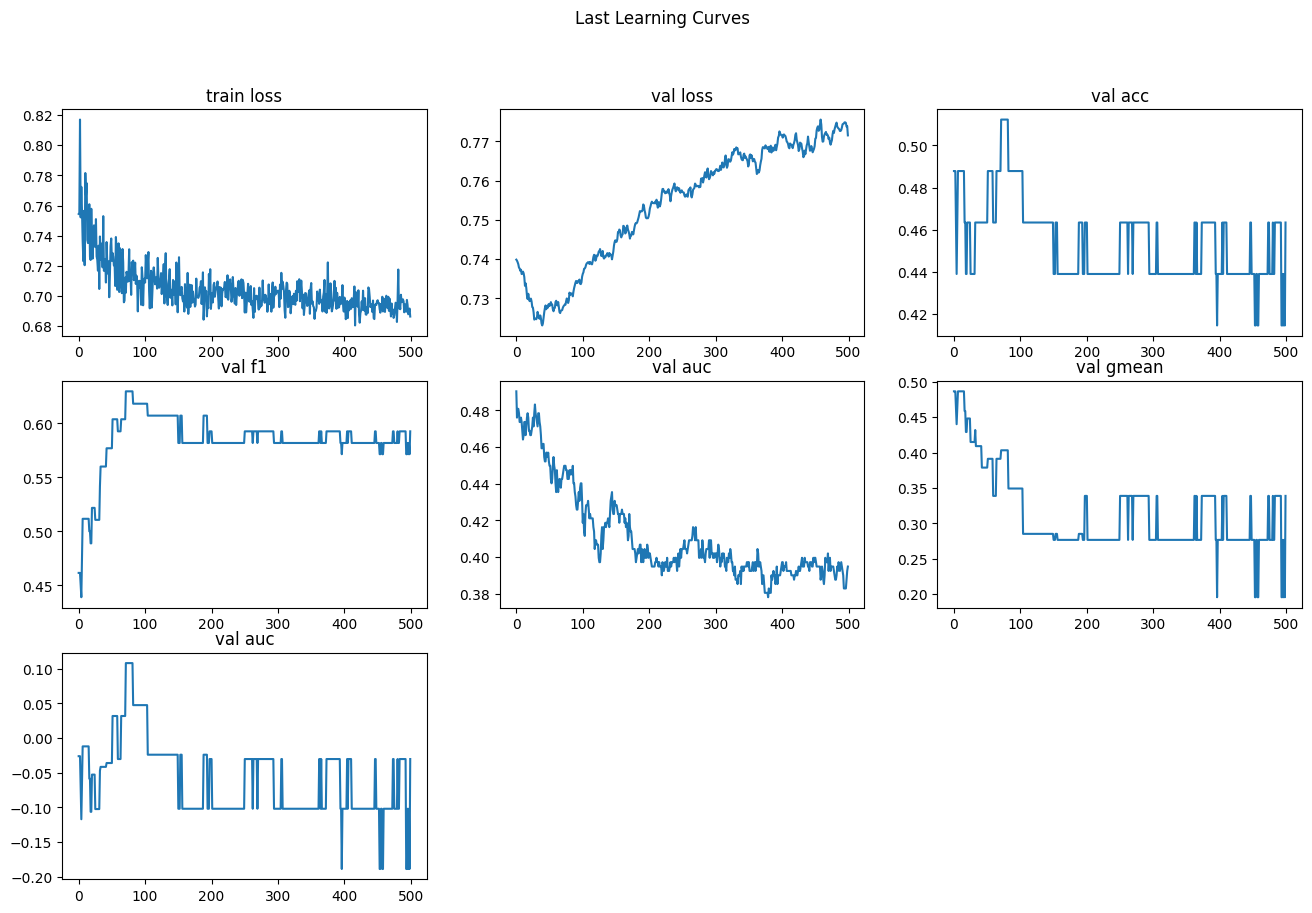

In [31]:
plt.figure(figsize=(16,10))

plt.subplot(331)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(332)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(333)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(334)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(335)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.subplot(336)
plt.plot(val_gmean_buf)
plt.title("val gmean")

plt.subplot(337)
plt.plot(val_mcc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [32]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []
val_gmean_mean = []
val_mcc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, i))
    val_auc_mean.append(val_auc_i)
    
    val_gmean_i = np.load("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, i))
    val_gmean_mean.append(val_gmean_i)
    
    val_mcc_i = np.load("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, i))
    val_mcc_mean.append(val_mcc_i)
    
print("model: {}".format(model_name))
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))
print("val gmean mean: ", np.mean(val_gmean_mean))
print("val mcc mean: ", np.mean(val_mcc_mean))

model: masonscnn_ft
val acc mean:  0.5414634146341464
val f1 mean:  0.6631533886842206
val auc mean:  0.5499714003821219
val gmean mean:  0.3471025090442392
val mcc mean:  -0.008071772479411338


new dataset: augment negative samples to neg:pos=1:1


new dataset - masonscnn

model: masonscnn
val acc mean:  0.5609756097560976
val f1 mean:  0.7080969748642163
val auc mean:  0.5115618347865623
val gmean mean:  0.1176976534230973
val mcc mean:  0.05414104210725135
    
array([[ 48, 135],
       [ 50, 177]])



new dataset - masonscnn finetune

val acc mean:  0.5560975609756099
val f1 mean:  0.66096776615656
val auc mean:  0.5405112851806215
val gmean mean:  0.45399814531300964
val mcc mean:  0.07182380633434679
    
array([[ 84,  99],
       [ 92, 135]])


new dataset - masonscnn finetune FE Fixed

val acc mean:  0.5414634146341464
val f1 mean:  0.6631533886842206
val auc mean:  0.5499714003821219
val gmean mean:  0.3471025090442392
val mcc mean:  -0.008071772479411338

model: PESI

1. de novo
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8472360344258647
- val auc mean:  0.6364248905399801
- val gmean mean:  0.12137665014671031
- val mcc mean:  0.06637028519834769


- val acc mean:  0.7451612903225807
- val f1 mean:  0.8450983571639433
- val auc mean:  0.5999908666213013
- val gmean mean:  0.1544552971674015
- val mcc mean:  0.0980278804259509

2. fine-tune

fixed Frame/Set feature extractor
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5784537830739878
- val gmean mean:  0.0
- val mcc mean:  0.0

L2 + pre-train
- val acc mean:  0.6129032258064516
- val f1 mean:  0.7267589316962282
- val auc mean:  0.5019817458756078
- val gmean mean:  0.46310214588198306
- val mcc mean:  0.03777970650972913

EnsembleModel1

1. de novo

- val acc mean:  0.7258064516129032
- val f1 mean:  0.8357809829448485
- val auc mean:  0.5863614324010744
- val gmean mean:  0.04364357804719847
- val mcc mean:  -0.00243360941090478


model: EnsembleModel1 (based on DeepAAI hyperparameters)
- val acc mean:  0.735483870967742
- val f1 mean:  0.8426296329094451
- val auc mean:  0.576874495354035
- val gmean mean:  0.026726124191242435
- val mcc mean:  0.016785362070740578


model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.6850925941066606
- val gmean mean:  0.0
- val mcc mean:  0.0


2. finetune

model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8368535348629104
- val auc mean:  0.6183667442248005
- val gmean mean:  0.13486832980505137
- val mcc mean:  0.05979789537418943

EnsembleModel

1. de novo

- val acc mean:  0.7225806451612903
- val f1 mean:  0.80938251651044
- val auc mean:  0.6277278343991899
- val gmean mean:  0.20839957350649357
- val mcc mean:  0.1381022811013694

2. finetune

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8468587022064271
- val auc mean:  0.5173764489275998
- val gmean mean:  0.09929549764864425
- val mcc mean:  0.07493838512158786

MasonsCNN
1. de novo
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5409950281318567

flipping
- val acc mean:  0.735483870967742
- val f1 mean:  0.8427516133925679
- val auc mean:  0.5455146192256166

0209
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.5413395687858604
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

2. finetune
- val acc mean:  0.7193548387096775
- val f1 mean:  0.8280684455906437
- val auc mean:  0.5564490021203576
- val gmean mean:  0.1475625995769564
- val mcc mean:  0.04446577910427487


Feature Extractor fixed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8338451090661441
- val auc mean:  0.634319673790262
- val gmean mean:  0.24199404771340785
- val mcc mean:  0.12252410865664765

0216
- val acc mean:  0.7322580645161291
- val f1 mean:  0.834695438627144
- val auc mean:  0.6693377090371975
- val gmean mean:  0.2087328313765909
- val mcc mean:  0.11147883124012761

BiLSTM

1. De novo
- val acc mean:  0.7064516129032258
- val f1 mean:  0.819065850000514
- val auc mean:  0.44001247005339084


- val acc mean:  0.7193548387096774
- val f1 mean:  0.8286013119221826
- val auc mean:  0.5272626716846667
- val gmean mean:  0.08176287840460057
- val mcc mean:  0.00657602704451053

2. Finetune - full
- val acc mean:  0.2838709677419355
- val f1 mean:  0.06804597701149426
- val auc mean:  0.524349864826847
- val gmean mean:  0.08231242234049345
- val mcc mean:  -0.003441800331963846

FE Fixed
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5305428632180551
- val gmean mean:  0.0
- val mcc mean:  0.0

0216
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5296878848630767
- val gmean mean:  0.0
- val mcc mean:  0.0

InteractTransformer

1. De novo
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8460928830582551
- val auc mean:  0.5697268280171094

left/right flipping
- val acc mean:  0.6741935483870967
- val f1 mean:  0.7933415428025153
- val auc mean:  0.5941512822216147

0209
- val acc mean:  0.7387096774193548
- val f1 mean:  0.8444456024636061
- val auc mean:  0.5559159858328655
- val gmean mean:  0.0447213595499958
- val mcc mean:  0.04163331998932266

2. Finetune - full
- val acc mean:  0.7387096774193549
- val f1 mean:  0.837479640502948
- val auc mean:  0.5373362548221883
- val gmean mean:  0.11956972115904681
- val mcc mean:  0.05274808166803078

FE Fixed
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8192963769848788
- val auc mean:  0.5437163596562574
- val gmean mean:  0.18894861461152904
- val mcc mean:  0.043908331255973564

InteractCoattnTransformer

1. De novo

coattn after embed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8384620373723942
- val auc mean:  0.5792465999473672

coattn after transformer
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8389562234502067
- val auc mean:  0.5215266408783032

two coattn
dropout0.3
- val acc mean:  0.6645161290322581
- val f1 mean:  0.7577206864384995
- val auc mean:  0.4894495640761625

dropout0.5
- val acc mean:  0.7032258064516129
- val f1 mean:  0.8148800008196817
- val auc mean:  0.5601084965049159

0209
- val acc mean:  0.7064516129032258
- val f1 mean:  0.8065533962654705
- val auc mean:  0.53074342679202
- val gmean mean:  0.08783456377261516
- val mcc mean:  -0.03089614519177042

0210
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8333675745553654
- val auc mean:  0.5629656307034825
- val gmean mean:  0.19967351371222142
- val mcc mean:  0.08859651752472261

2. Finetune
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8295161019309971
- val auc mean:  0.6776508588030327
- val gmean mean:  0.41048764045233976
- val mcc mean:  0.23726058068617323

0210
- val acc mean:  0.7032258064516129
- val f1 mean:  0.7529802738432863
- val auc mean:  0.5843740140223517
- val gmean mean:  0.11863970769085672
- val mcc mean:  -0.02494321880367

use final model rather than best
- val acc mean:  0.5903225806451613
- val f1 mean:  0.6981662591680293
- val auc mean:  0.5202095768681446
- val gmean mean:  0.43529770732374456
- val mcc mean:  0.035015078636667016

FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8323679177395693
- val auc mean:  0.5757738855347552
- val gmean mean:  0.1772604277248653
- val mcc mean:  0.051826896161838866

SetModel
1. de novo

dropout0.3
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8364886835455663
- val auc mean:  0.6504661560377674

dropout0.5 + CoAttnSkipConnection
- val acc mean:  0.7225806451612904
- val f1 mean:  0.7678373423027144
- val auc mean:  0.649160663150433

dropout0.3 + CoAttn ahead
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8331830945361233
- val auc mean:  0.6217202631128462

dropout0.3 + CoAttn ahead + left/right flipping
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8390957431282627
- val auc mean:  0.566890947358978

0209
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8385743405122875
- val auc mean:  0.646844740510981
- val gmean mean:  0.3499641605118257
- val mcc mean:  0.16989948824073764

2. finetune
- val acc mean:  0.6548387096774194
- val f1 mean:  0.7614356955971864
- val auc mean:  0.5850305370957545
- val gmean mean:  0.4690008572794017
- val mcc mean:  0.09590317756829693

FX Fixed FT
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8304804775765957
- val auc mean:  0.6118961087221957
- val gmean mean:  0.325372891932986
- val mcc mean:  0.1376242188288149

SetCoAttnModel

1. de novo
- val acc mean:  0.7129032258064516
- val f1 mean:  0.8283774426716478
- val auc mean:  0.6031828529526739
- val gmean mean:  0.11381713711118394
- val mcc mean:  0.05107581130651245

2. finetune
- val acc mean:  0.735483870967742
- val f1 mean:  0.8255950018544915
- val auc mean:  0.5836535310384415
- val gmean mean:  0.19683955427239194
- val mcc mean:  0.060401168945660236

FE Fixed FT
- val acc mean:  0.7451612903225807
- val f1 mean:  0.840554625019997
- val auc mean:  0.5332801356075013
- val gmean mean:  0.06351073488299558
- val mcc mean:  0.02796710598995068

SetTransformer

1. de novo
- val acc mean:  0.7387096774193549
- val f1 mean:  0.8361401746369017
- val auc mean:  0.6567989579332291
- val gmean mean:  0.22237169691743341
- val mcc mean:  0.11689544381896444

bi-tower
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8304782251291887
- val auc mean:  0.6367931102713712
- val gmean mean:  0.2632115309684307
- val mcc mean:  0.12791443324565496

2. finetune
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8221135340407786
- val auc mean:  0.6275436241791741
- val gmean mean:  0.2348251415923123
- val mcc mean:  0.09602992408332747


FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5436637051496387
- val gmean mean:  0.0
- val mcc mean:  0.0

SetCoAttnTransformer

1. de novo
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8371426812951388
- val auc mean:  0.6973226134479332
- val gmean mean:  0.08283199089454711
- val mcc mean:  0.03612682646386498

2. finetune
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8381884843645546
- val auc mean:  0.7171163618989707
- val gmean mean:  0.6158503375322386
- val mcc mean:  0.34239057721353133

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8258364526202552
- val auc mean:  0.667494606842433
- val gmean mean:  0.598600578762371
- val mcc mean:  0.327257546356814

FE Fixed FT
- val acc mean:  0.7387096774193549
- val f1 mean:  0.839985269566902
- val auc mean:  0.641870172027461
- val gmean mean:  0.15255182247968152
- val mcc mean:  0.08206384239742148

InteractTransformerLSTM
1. de novo
- ?

2. finetune
- ?

3. finetune - full
- ?

InteractTransformerLSTM + CoAttn
1. de novo
- ?

FTransformer + CoATtn
1. de novo

1layer + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.48571428571428565

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6238095238095238

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6428571428571429

2layers + kmer4
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.3476190476190476

2layers + kmer3 + lr3e-5
- val acc mean:  0.6451612903225806
- val f1 mean:  0.7755102040816326
- val auc mean:  0.3952380952380952

FTransformer
1. de novo

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5285714285714286

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5619047619047619